In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

/tmp/ipykernel_312754/1256517549.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
import torch
import torch_geometric
import os
import os.path as osp
import numpy as np
from tqdm import tqdm as tqdm
#torch.manual_seed(1)
import matplotlib.pyplot as plt


In [74]:
# import datasets
import glob
raw_dir="/grid_mnt/data__data.polcms/cms/sghosh/TESTBEAMDATA/TBDGRAPHS/test31052023_l/"
fnamelist = [filepath for filepath in glob.glob(raw_dir+'tbd*.pt')]
data_list = []
tren = []
ctr = 0
for i in tqdm(fnamelist):
    idx = torch.load(i)
    
    idx.x = idx.cl2d
    #idx.x = idx.rh
    #print(idx.cl2d[:,3])
    
    idx.y = torch.sum(idx.cl2d[:,3])/idx.truen
    
    data_list.append(idx)
    #tren.append(idx.truen)
    tren.append(idx.y)
    #ctr += 1
    #if ctr > 200:
    #    break

100%|██████████| 30237/30237 [00:32<00:00, 929.29it/s] 


total samples: 30237


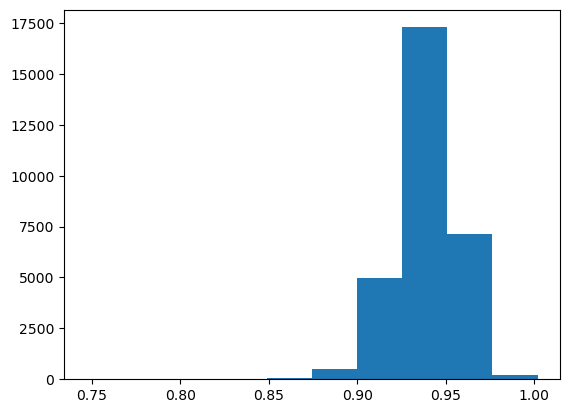

In [75]:
print("total samples:",len(data_list))
plt.hist(tren)
plt.show()

In [76]:
totalev = len(data_list)
ntrain = int(0.8*totalev)
import random
random.shuffle(data_list)
ntrainbatch = 200
ntestbatch = 100
trainloader = torch_geometric.data.DataLoader(data_list[:ntrain], batch_size=ntrainbatch)
testloader = torch_geometric.data.DataLoader(data_list[ntrain:], batch_size=ntestbatch)
#batch_size = ntrainbatch
epoch_size = len(data_list[:ntrain])
print("epoch size,batch_size:",epoch_size,ntrainbatch)

epoch size,batch_size: 24189 200


In [13]:
import gc
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch.utils.checkpoint import checkpoint
from torch_cluster import knn_graph

from torch_geometric.nn import EdgeConv, NNConv
#from torch_geometric.nn.pool.edge_pool import EdgePooling

from torch_geometric.utils import normalized_cut
from torch_geometric.utils import remove_self_loops
from torch_geometric.utils.undirected import to_undirected
from torch_geometric.nn import (graclus, max_pool, max_pool_x,
                                global_mean_pool, global_max_pool,
                                global_add_pool,BatchNorm)

transform = T.Cartesian(cat=False)

def normalized_cut_2d(edge_index, pos):
    row, col = edge_index
    edge_attr = torch.norm(pos[row] - pos[col], p=2, dim=1)
    return normalized_cut(edge_index, edge_attr, num_nodes=pos.size(0))

class DynamicReductionNetwork(nn.Module):
    # This model iteratively contracts nearest neighbour graphs 
    # until there is one output node.
    # The latent space trained to group useful features at each level
    # of aggregration.
    # This allows single quantities to be regressed from complex point counts
    # in a location and orientation invariant way.
    # One encoding layer is used to abstract away the input features.
    def __init__(self, input_dim=5, hidden_dim=64, output_dim=1, k=16, aggr='add',
                 norm=torch.tensor([1./500., 1./500., 1./54., 1/25., 1./1000.])):
 #                norm=torch.tensor([1., 1., 1., 1., 1.])):
        super(DynamicReductionNetwork, self).__init__()

        self.datanorm = nn.Parameter(norm,requires_grad=True)
        
        self.k = k
        start_width = 2 * hidden_dim
        middle_width = 3 * hidden_dim // 2

        
        
        self.inputnet =  nn.Sequential(
            nn.Linear(input_dim, hidden_dim*2),            
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim*2, hidden_dim*2),
            nn.ELU(),
            nn.Dropout(0.2),
#            nn.Linear(hidden_dim*2, hidden_dim*2),
#            nn.ELU(),
#            nn.Dropout(0.2),
#            nn.Linear(hidden_dim*2, hidden_dim*2),
#            nn.ELU(),
#            nn.Dropout(0.2),
#            nn.Linear(hidden_dim*2, hidden_dim*2),
#            nn.ELU(),
#            nn.Linear(hidden_dim*2, hidden_dim*2),
#            nn.ELU(),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ELU(),
        )
        
        
        convnn1 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
        convnn2 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
        
        convnn3 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
                
        self.edgeconv1 = EdgeConv(nn=convnn1, aggr=aggr)
        self.edgeconv2 = EdgeConv(nn=convnn2, aggr=aggr)
        self.edgeconv3 = EdgeConv(nn=convnn3, aggr=aggr)
        
        self.output = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                    nn.ELU(),
                                    nn.Dropout(0.2),
                                    #nn.Softplus(),
                                    nn.Linear(hidden_dim, hidden_dim//2),
                                    nn.ELU(),
                                    nn.Dropout(0.2),
                                    #nn.Softplus(),
                                    nn.Linear(hidden_dim//2, hidden_dim//2),#added
                                    nn.ELU(),
                                    nn.Dropout(0.2),
                                    #nn.Softplus(),
                                    nn.Linear(hidden_dim//2, output_dim)
                                   )
        self.batchnorm1 = BatchNorm(hidden_dim)
        
    def forward(self, data):        
        data.x = self.datanorm * data.x
        data.x = self.inputnet(data.x)
        
        #print(data.batch)
#        data.x = self.batchnorm1(data.x)
        data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv1.flow))
        data.x = self.edgeconv1(data.x, data.edge_index)
        
        weight = normalized_cut_2d(data.edge_index, data.x)
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        data.edge_attr = None
        data = max_pool(cluster, data)
        
        ####
#        data.x = self.batchnorm1(data.x)
        data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv3.flow))
        data.x = self.edgeconv3(data.x, data.edge_index)
        
        weight = normalized_cut_2d(data.edge_index, data.x)
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        data.edge_attr = None
        data = max_pool(cluster, data)
        ####
        ####
        #data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv1.flow))
        #data.x = self.edgeconv3(data.x, data.edge_index)
        
        #weight = normalized_cut_2d(data.edge_index, data.x)
        #cluster = graclus(data.edge_index, weight, data.x.size(0))
        #data.edge_attr = None
        #data = max_pool(cluster, data)
        ####
#        data.x = self.batchnorm1(data.x)
        data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv2.flow))
        data.x = self.edgeconv2(data.x, data.edge_index)
        
        weight = normalized_cut_2d(data.edge_index, data.x)
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        x, batch = max_pool_x(cluster, data.x, data.batch)

        x = global_max_pool(x, batch)
#        print(self.output(x))
        return self.output(x).squeeze(-1)

In [14]:
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler
import math
import torch
import sys

class ReduceMaxLROnRestart:
    def __init__(self, ratio=0.75):
        self.ratio = ratio
        
        def __call__(self, eta_min, eta_max):
            return eta_min, eta_max * self.ratio
        
        
class ExpReduceMaxLROnIteration:
    def __init__(self, gamma=1):
        self.gamma = gamma
        
    def __call__(self, eta_min, eta_max, iterations):
        return eta_min, eta_max * self.gamma ** iterations


class CosinePolicy:
    def __call__(self, t_cur, restart_period):
        return 0.5 * (1. + math.cos(math.pi *
                                    (t_cur / restart_period)))
    
    
class ArccosinePolicy:
    def __call__(self, t_cur, restart_period):
        return (math.acos(max(-1, min(1, 2 * t_cur
                                      / restart_period - 1))) / math.pi)
    
    
class TriangularPolicy:
    def __init__(self, triangular_step=0.5):
        self.triangular_step = triangular_step
        
    def __call__(self, t_cur, restart_period):
        inflection_point = self.triangular_step * restart_period
        point_of_triangle = (t_cur / inflection_point
                             if t_cur < inflection_point
                             else 1.0 - (t_cur - inflection_point)
                             / (restart_period - inflection_point))
        return point_of_triangle
    
    
class CyclicLRWithRestarts(_LRScheduler):
    """Decays learning rate with cosine annealing, normalizes weight decay
    hyperparameter value, implements restarts.
    https://arxiv.org/abs/1711.05101
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        batch_size: minibatch size
        epoch_size: training samples per epoch
        restart_period: epoch count in the first restart period
        t_mult: multiplication factor by which the next restart period will expand/shrink
        policy: ["cosine", "arccosine", "triangular", "triangular2", "exp_range"]
        min_lr: minimum allowed learning rate
        verbose: print a message on every restart
        gamma: exponent used in "exp_range" policy
        eta_on_restart_cb: callback executed on every restart, adjusts max or min lr
        eta_on_iteration_cb: callback executed on every iteration, adjusts max or min lr
        triangular_step: adjusts ratio of increasing/decreasing phases for triangular policy
    Example:
        >>> scheduler = CyclicLRWithRestarts(optimizer, 32, 1024, restart_period=5, t_mult=1.2)
        >>> for epoch in range(100):
        >>>     scheduler.step()
        >>>     train(...)
        >>>         ...
        >>>         optimizer.zero_grad()
        >>>         loss.backward()
        >>>         optimizer.step()
        >>>         scheduler.batch_step()
        >>>     validate(...)
    """
    
    def __init__(self, optimizer, batch_size, epoch_size, restart_period=100,
                 t_mult=2, last_epoch=-1, verbose=False,
                 policy="cosine", policy_fn=None, min_lr=1e-7,
                 eta_on_restart_cb=None, eta_on_iteration_cb=None,
                 gamma=1.0, triangular_step=0.5):
        
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        
        self.optimizer = optimizer
        
        if last_epoch == -1:
            for group in optimizer.param_groups:
                group.setdefault('initial_lr', group['lr'])
                group.setdefault('minimum_lr', min_lr)
        else:
            for i, group in enumerate(optimizer.param_groups):
                if 'initial_lr' not in group:
                    raise KeyError("param 'initial_lr' is not specified "
                                   "in param_groups[{}] when resuming an"
                                   " optimizer".format(i))
                
        self.base_lrs = [group['initial_lr'] for group
                         in optimizer.param_groups]
        
        self.min_lrs = [group['minimum_lr'] for group
                        in optimizer.param_groups]
        
        self.base_weight_decays = [group['weight_decay'] for group
                                   in optimizer.param_groups]
        
        self.policy = policy
        self.eta_on_restart_cb = eta_on_restart_cb
        self.eta_on_iteration_cb = eta_on_iteration_cb
        if policy_fn is not None:
            self.policy_fn = policy_fn
        elif self.policy == "cosine":
            self.policy_fn = CosinePolicy()
        elif self.policy == "arccosine":
            self.policy_fn = ArccosinePolicy()
        elif self.policy == "triangular":
            self.policy_fn = TriangularPolicy(triangular_step=triangular_step)
        elif self.policy == "triangular2":
            self.policy_fn = TriangularPolicy(triangular_step=triangular_step)
            self.eta_on_restart_cb = ReduceMaxLROnRestart(ratio=0.5)
        elif self.policy == "exp_range":
            self.policy_fn = TriangularPolicy(triangular_step=triangular_step)
            self.eta_on_iteration_cb = ExpReduceMaxLROnIteration(gamma=gamma)
            
        self.last_epoch = last_epoch
        self.batch_size = batch_size
        self.epoch_size = epoch_size
        
        self.iteration = 0
        self.total_iterations = 0
        
        self.t_mult = t_mult
        self.verbose = verbose
        self.restart_period = math.ceil(restart_period)
        self.restarts = 0
        self.t_epoch = -1
        self.epoch = -1
        
        self.eta_min = 0
        self.eta_max = 1
        
        self.end_of_period = False
        self.batch_increments = []
        self._set_batch_increment()
        
    def _on_restart(self):
        if self.eta_on_restart_cb is not None:
            self.eta_min, self.eta_max = self.eta_on_restart_cb(self.eta_min,
                                                                self.eta_max)
            
    def _on_iteration(self):
        if self.eta_on_iteration_cb is not None:
            self.eta_min, self.eta_max = self.eta_on_iteration_cb(self.eta_min,
                                                                  self.eta_max,
                                                                  self.total_iterations)
            
    def get_lr(self, t_cur):
        eta_t = (self.eta_min + (self.eta_max - self.eta_min)
                 * self.policy_fn(t_cur, self.restart_period))
        
        weight_decay_norm_multi = math.sqrt(self.batch_size /
                                            (self.epoch_size *
                                             self.restart_period))
        
        lrs = [min_lr + (base_lr - min_lr) * eta_t for base_lr, min_lr
               in zip(self.base_lrs, self.min_lrs)]
        weight_decays = [base_weight_decay #* eta_t * weight_decay_norm_multi
                         for base_weight_decay in self.base_weight_decays]
        
        if (self.t_epoch + 1) % self.restart_period < self.t_epoch:
            self.end_of_period = True
            
        if self.t_epoch % self.restart_period < self.t_epoch:
            if self.verbose:
                print("Restart {} at epoch {}".format(self.restarts + 1,
                                                      self.last_epoch))
            self.restart_period = math.ceil(self.restart_period * self.t_mult)
            self.restarts += 1
            self.t_epoch = 0
            self._on_restart()
            self.end_of_period = False
            
        return zip(lrs, weight_decays)
        
    def _set_batch_increment(self):
        d, r = divmod(self.epoch_size, self.batch_size)
        batches_in_epoch = d + 2 if r > 0 else d + 1
        self.iteration = 0
        self.batch_increments = torch.linspace(0, 1, batches_in_epoch).tolist()
        
    def step(self):
        self.last_epoch += 1
        self.t_epoch += 1
        self._set_batch_increment()
        self.batch_step()
        
    def batch_step(self):
        try:
            t_cur = self.t_epoch + self.batch_increments[self.iteration]
            self._on_iteration()
            self.iteration += 1
            self.total_iterations += 1
        except (IndexError):
            raise StopIteration("Epoch size and batch size used in the "
                                "training loop and while initializing "
                                "scheduler should be the same.")
        
        for param_group, (lr, weight_decay) in zip(self.optimizer.param_groups,
                                                   self.get_lr(t_cur)):
            param_group['lr'] = lr
            param_group['weight_decay'] = weight_decay

In [87]:


#from models.DynamicReductionNetwork import DynamicReductionNetwork

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.drn = DynamicReductionNetwork(input_dim=4,hidden_dim=20,k=10,output_dim=1,norm=torch.tensor([ 1., 1., 1., 1.]))
        
    def forward(self, data):
        logits = self.drn(data)
        #return F.softplus(logits)
        return logits
device = torch.device('cuda:2')#('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
#optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-3)
scheduler = CyclicLRWithRestarts(optimizer, ntrainbatch, epoch_size, restart_period=80, t_mult=1.2, policy="cosine")
#criterion = torch.nn.MSELoss()

#lossmse = nn.MSELoss()
def resoloss2(output,truth):
    batch_size = output.size()[0]
    #mse = F.mse_loss(output, truth, reduction='mean')  ### works as well
    #mse = torch.sum((output-truth)**2/truth)/batch_size
    #mse = torch.sum(((output-truth)/truth)**2)/batch_size ### worked reduces reso not scale
    #mse = torch.mean(torch.abs((output - truth)))
    mse = torch.mean(torch.exp(torch.abs(output - truth)))
    #res = 
    return (mse)

def resoloss3(output,truth):
    #batch_size = output.size()[0]
    #mse = F.mse_loss(output, truth, reduction='mean')
    #mse = torch.sum((output-truth)**2/truth)/batch_size
    #mse = torch.sum(((output-truth)/truth)**2)/batch_size
    #mse = torch.mean(torch.abs((output - truth)))
    #outputa = output[truth < 1.0]
    #outputa = output[truth > 1.0]
    loss1 = torch.mean(torch.abs((output[truth < 1.0] - truth[truth < 1.0])))
    batch_size = len(output[truth > 1.0])
    #loss2 = torch.sum((output[truth > 1.0] -truth[truth > 1.0] )**2/truth[truth > 1.0] )/batch_size
    loss2 = torch.sum((output[truth > 1.0] -truth[truth > 1.0] )**2 )/batch_size

    #res = 
    return loss1+loss2
    

    
def resoloss(outputa,trutha):
    n_bins = np.random.poisson(20) + 2
    minx = torch.min(trutha).detach().cpu()
    maxx = torch.max(trutha).detach().cpu()
    minx = np.exp(minx)
    maxx = np.exp(maxx)
    
    binss = np.arange(minx,maxx,(maxx-minx)/n_bins)
    binss = np.log(binss)
    loss = 0.
    for i in range(binss.size-1):
        tmpo = outputa[ (trutha > binss[i]) &  (trutha < binss[i+1])  ]
        tmpt = trutha[ (trutha > binss[i]) &  (trutha < binss[i+1])  ]
        #print("tmpo,tmpt:",tmpo,tmpt)
        if (list(tmpo.size())[0] == 0 or list(tmpt.size())[0] == 0):
            continue
        #print(list(tmpo.size())[0],list(tmpt.size())[0])
        tmpom = torch.mean(tmpo)
        tmptm = torch.mean(tmpt)
        #print (tmpom,tmptm)
        #if (tmptm == 0):
        #    continue
        
        #    if ((tmpom - tmptm)**2/tmptm is not np.nan):
        #        print ("(tmpom - tmptm)**2/tmptm",(tmpom - tmptm)**2/tmptm)
        loss += (tmpom - tmptm)**2/tmptm
    
    
    if (loss == 0.):
        print("minx,maxx,binss,n_bins:",minx,maxx,binss,n_bins)    
        print(outputa,trutha)
        for i in range(binss.size-1):
            tmpo = outputa[ (trutha > binss[i]) &  (trutha < binss[i+1])  ]
            tmpt = trutha[ (trutha > binss[i]) &  (trutha < binss[i+1])  ]
            print("tmpo,tmpt:",tmpo,tmpt)
            if (list(tmpo.size())[0] == 0 or list(tmpt.size())[0] == 0):
                continue
            #print(list(tmpo.size())[0],list(tmpt.size())[0])
            tmpom = torch.mean(tmpo)
            tmptm = torch.mean(tmpt)
            print (tmpom,tmptm)
            loss += (tmpom - tmptm)**2/tmptm
            print(loss)
        
    #print("loss: ",loss)
    return loss        
losscat = torch.nn.CrossEntropyLoss()    
def categorical_loss(outputa,trutha,alpha):
    total_loss =  losscat(outputa[:,:2],trutha[:,0].long()) + alpha*resoloss(outputa[:,2],trutha[:,1])
    return total_loss


def categorical_loss_only(outputa,trutha):
    total_loss =  losscat(outputa[:,:2],trutha[:,0].long()) 
    return total_loss


#model.train()
def train(epoch):
    model.train()
    torch.cuda.empty_cache()
    scheduler.step()
    loss = []
    for data in tqdm(trainloader):
            data = data.to(device)
            optimizer.zero_grad()
            result = model(data)
            lossc = resoloss2(result, data.y)
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            scheduler.batch_step()
    print( 'batches for train:',len(loss)) 
    print('train loss:',np.mean(np.array(loss)))
    return np.mean(np.array(loss))

from scipy.stats import norm
import matplotlib.mlab as mlab
import scipy.stats as scs
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
#%matplotlib inline

def gaussian(x,  mean,a, sigma):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2)))

def evaluate(epoch):
        """"Evaluate the model"""
        model.zero_grad()
        torch.cuda.empty_cache()
        model.eval()
        pred = []
        true = []
        loss= []
        
        correct = 0
        predc = []
        truec = []
        for data in tqdm(testloader):
            data = data.to(device)        
            result = model(data)
            lossc = resoloss2(result, data.y)

            loss.append(lossc.item())

            for i in result:
                pred.append(i.detach().cpu())
                #predc.append(i.detach().cpu().argmax())
            for i in data.y.detach():
                true.append(i.detach().cpu())

        print('batches for test:', len(loss)) 
        print('test loss:',np.mean(np.array(loss)))
#        fracarr = np.array(frac

        
        preda = np.array(pred)
        truea = np.array(true)
        #preda = preda[:,2] ### added
        #truea = truea[:,1] ### added
        fracarr = (preda - truea)/truea
        #print(preda,truea,fracarr)
        print('pred - true / true mean:',(np.mean(fracarr)))
        print('pred - true / true std:',(np.std(fracarr)))
        (mu, sigma) = norm.fit(fracarr)
        print('mu,sig:',mu,sigma)
        

        #bin_heights, bin_borders, _ = plt.hist(fracarr,range=[-2,2], bins=100, label='histogram')
        #bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
        
        from matplotlib.pyplot import figure
        figure(figsize=(30, 20), dpi=40)
        plt.rcParams['axes.labelsize'] = 36
        plt.rcParams['axes.titlesize'] = 36
        plt.hist(fracarr,bins=100,range=[-2,2])
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.axvline(x=0.0,c='r')
        plt.show()
        
        '''
        bins =  np.linspace(0,18,19)

        fig, axs = plt.subplots(6,3, figsize=(40, 40), facecolor='w', edgecolor='k')
        axs = axs.ravel()

        for i in tqdm(range (bins.size - 1)):
            predaa = preda[(truea >bins[i]) & (truea <bins[i+1]) ]
            trueaa = truea[(truea >bins[i]) & (truea <bins[i+1]) ]
            fracarr = (predaa - trueaa)/trueaa
            #if (fracarr < 0):
            axs[i].hist(fracarr,bins=100,range=[-4,4],)
            axs[i].set_xlabel('pred - true / true')
            axs[i].set_ylabel('counts')
            axs[i].set_title(str(bins[i])+" to "+str(bins[i+1]))
            #print (vals)
        if (epoch%5==0):
            plt.savefig('%s/mt-mp_frac_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        plt.show()'''
        
        '''try:
            from matplotlib.pyplot import figure
            figure(figsize=(20, 10), dpi=30)
            plt.rcParams['axes.labelsize'] = 16
            plt.rcParams['axes.titlesize'] = 16
            popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[0., 100., 1.],bounds = ([-np.inf,0,0],[np.inf,np.inf,np.inf]))
            x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 100)
            plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
            plt.legend()


            plt.xlabel('pred - true / true')
            plt.ylabel('counts')
            #plt.yscale("log")
            #plt.title(r'$\mathrm{pred - true / true:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
            plt.title(r'$\mathrm{pred - true / true:}\ \mu=%.3f,\ \sigma=%.3f$' %(popt[0], popt[2]))
            plt.grid(True)

            plt.show()

        except RuntimeError:
            print("Error - curve_fit failed")
            plt.xlabel('pred - true / true')
            plt.ylabel('counts')
            #plt.title(r'$\mathrm{pred - true / true:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
            plt.title('pred - true / true fit failed')
            #plt.yscale("log")
            plt.grid(True)

            plt.show()'''
        from matplotlib.pyplot import figure
        figure(figsize=(30, 30), dpi=40)
        #plt.rcParams['axes.labelsize'] = 36
        #plt.rcParams['axes.titlesize'] = 36
        #plt.hist2d(truea,preda,bins=200)
        plt.scatter(truea,preda,alpha=0.4)
        plt.plot([0,2], [0,2], 'k-')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        #plt.xlim([-2, 18])
        #plt.ylim([-2, 20])
        plt.axvline(x=1.0,c='r')
        plt.axhline(y=1.0,c='r')
        plt.show()
        if (epoch%5 ==0):
            plt.savefig('%s/mpredVsmtrue_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        #plt.show()
        return np.mean(np.array(loss))
        #del pred,true,loss,preda,truea,fracarr  #memtest


epoch: 0


100%|██████████| 121/121 [00:03<00:00, 31.41it/s]


batches for train: 121
train loss: 1.855854292546422


100%|██████████| 61/61 [00:01<00:00, 44.81it/s]


batches for test: 61
test loss: 1.2900405320964876
pred - true / true mean: -0.26964056
pred - true / true std: 0.05503981
mu,sig: -0.26964056 0.05503981


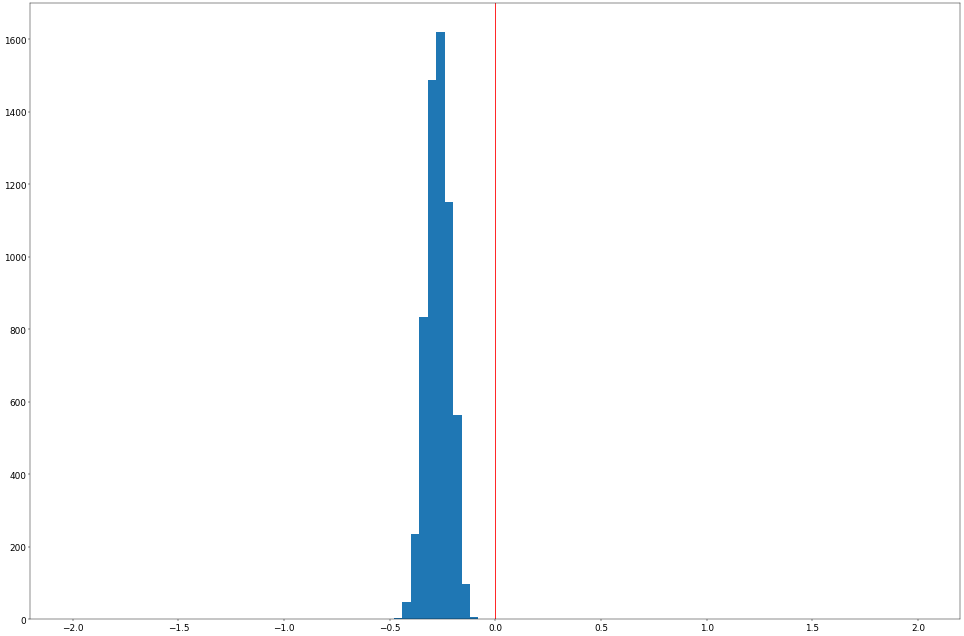

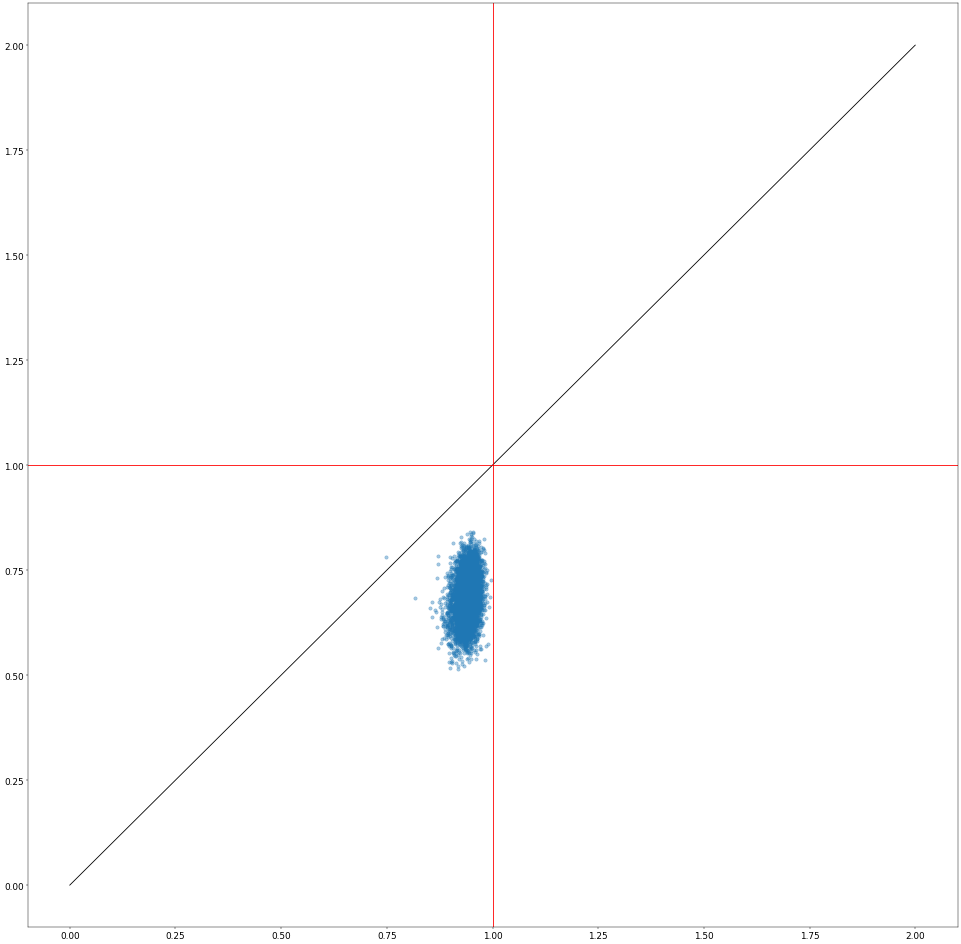

new best test loss: 1.2900405320964876
epoch: 1


100%|██████████| 121/121 [00:03<00:00, 36.72it/s]


batches for train: 121
train loss: 1.2459996712109274


100%|██████████| 61/61 [00:01<00:00, 53.12it/s]


batches for test: 61
test loss: 1.1841203970987288
pred - true / true mean: -0.17929107
pred - true / true std: 0.029005142
mu,sig: -0.17929107 0.029005142


<Figure size 640x480 with 0 Axes>

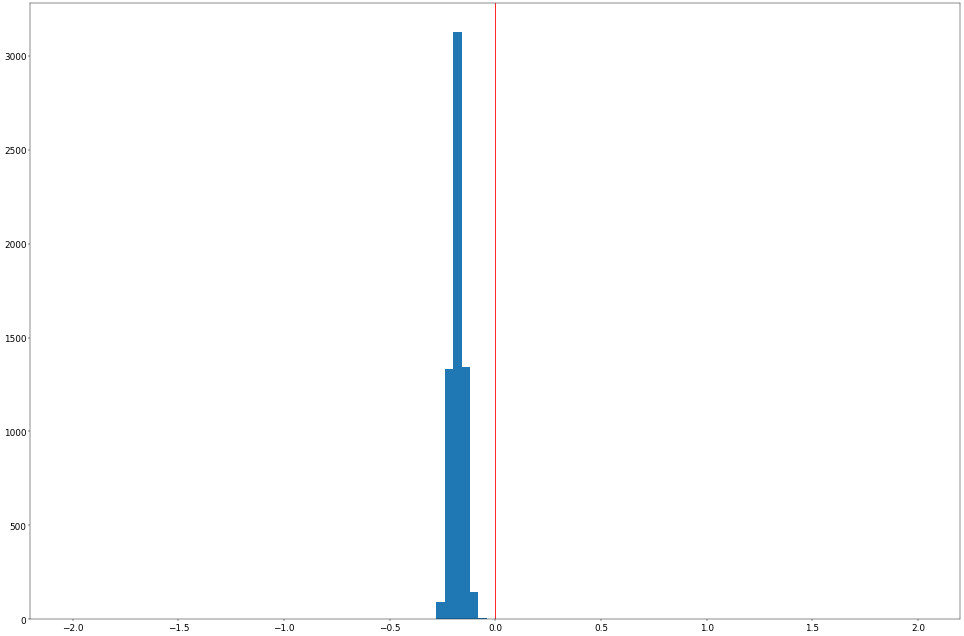

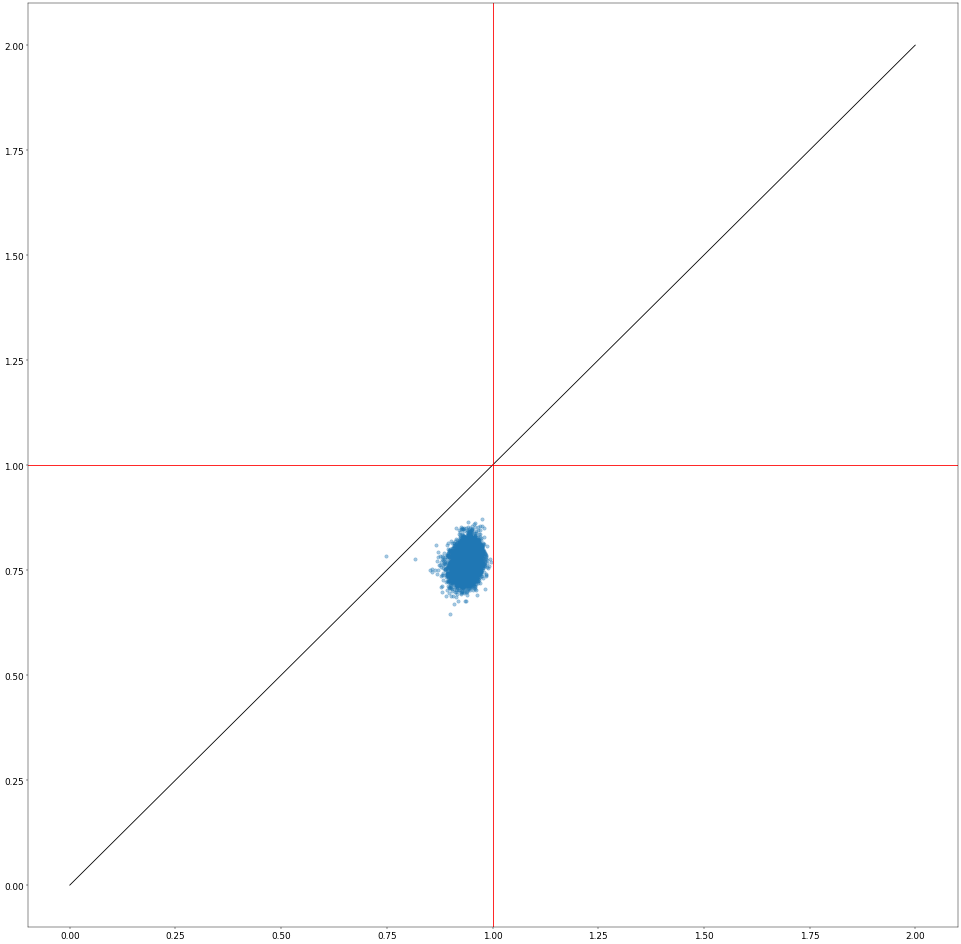

new best test loss: 1.1841203970987288
epoch: 2


100%|██████████| 121/121 [00:02<00:00, 44.12it/s]


batches for train: 121
train loss: 1.2089702334285768


100%|██████████| 61/61 [00:01<00:00, 55.07it/s]


batches for test: 61
test loss: 1.1362462375984816
pred - true / true mean: -0.13541223
pred - true / true std: 0.022552073
mu,sig: -0.13541223 0.022552073


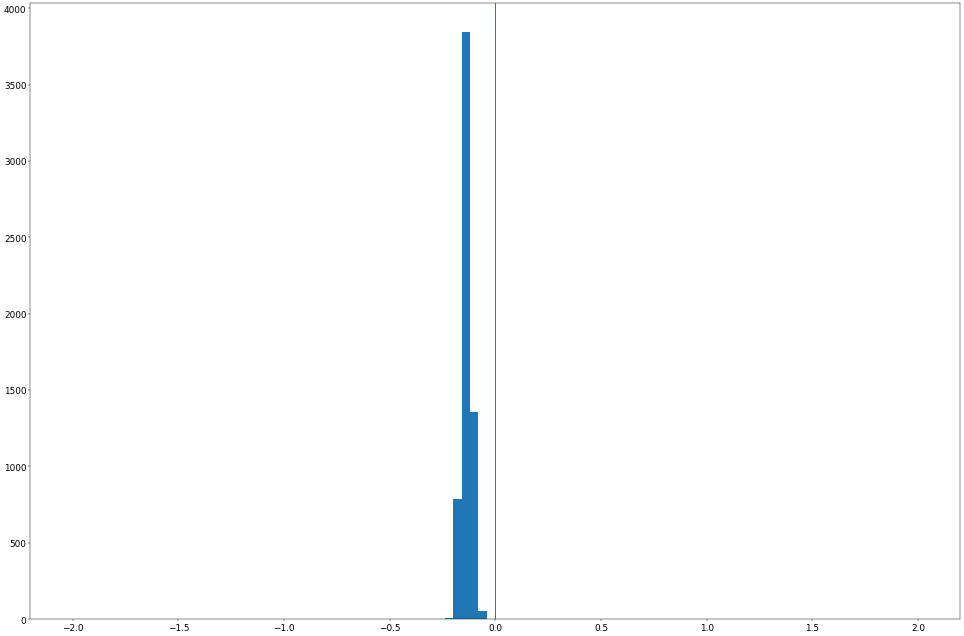

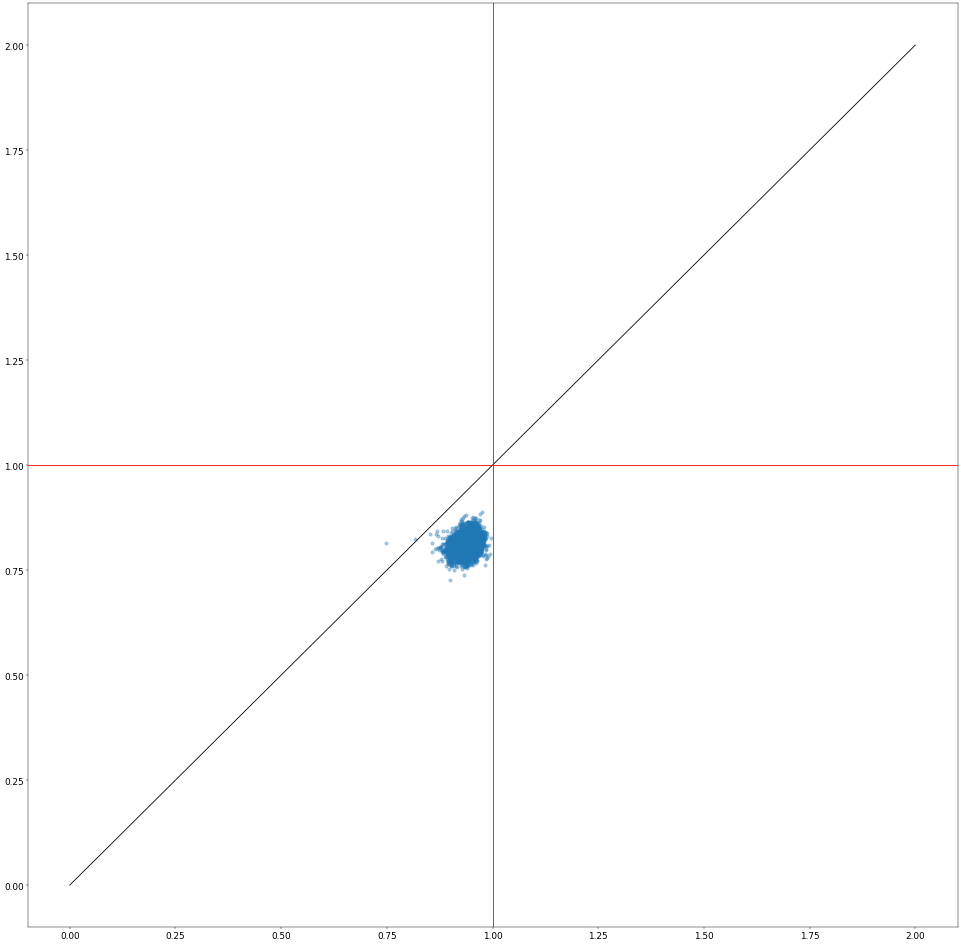

new best test loss: 1.1362462375984816
epoch: 3


100%|██████████| 121/121 [00:02<00:00, 44.27it/s]


batches for train: 121
train loss: 1.1839661115457203


100%|██████████| 61/61 [00:01<00:00, 54.86it/s]


batches for test: 61
test loss: 1.10164110777808
pred - true / true mean: -0.10252514
pred - true / true std: 0.019604225
mu,sig: -0.10252514 0.019604225


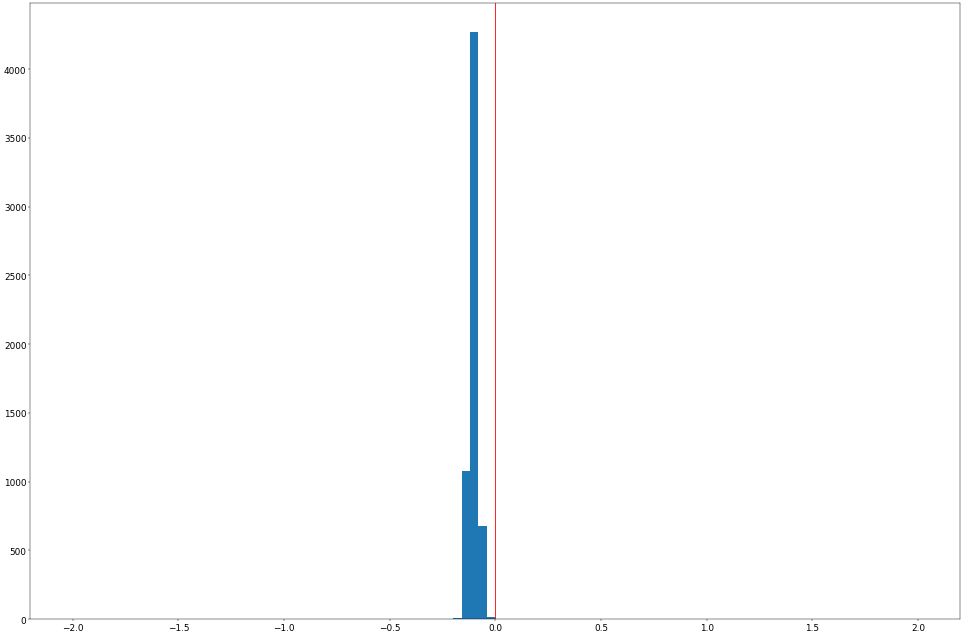

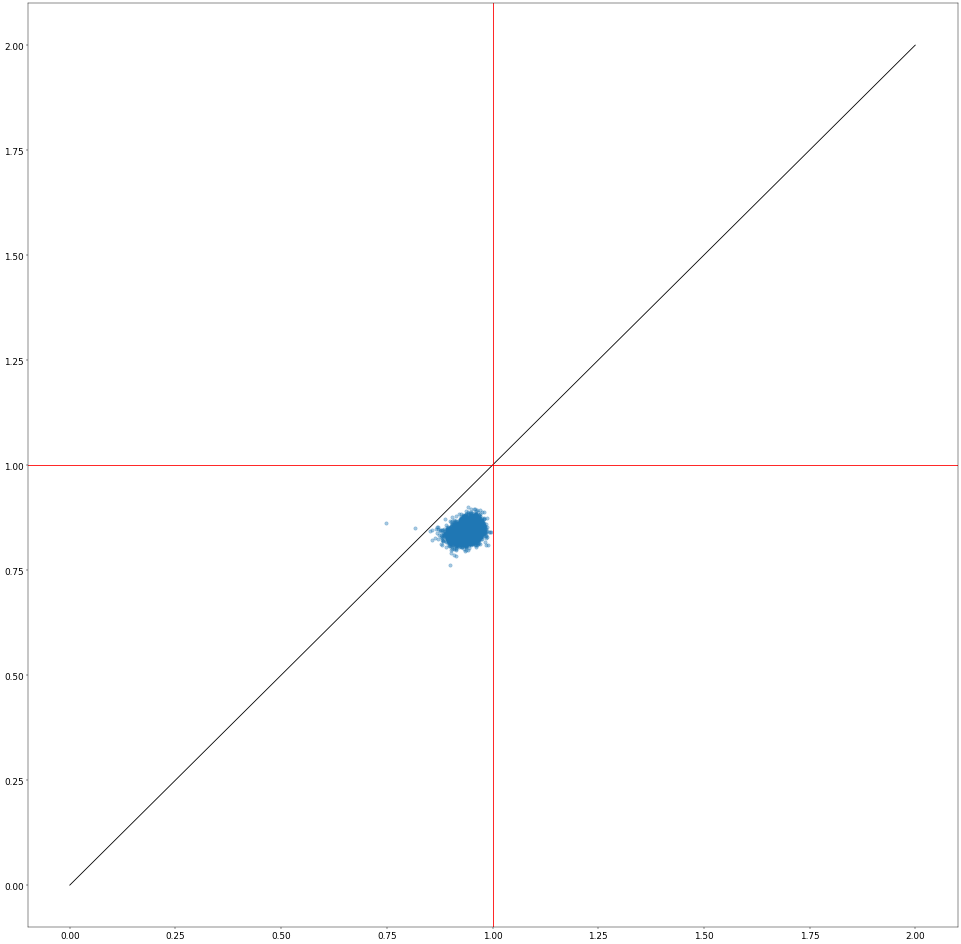

new best test loss: 1.10164110777808
epoch: 4


100%|██████████| 121/121 [00:02<00:00, 42.24it/s]


batches for train: 121
train loss: 1.1643095499227856


100%|██████████| 61/61 [00:01<00:00, 55.27it/s]


batches for test: 61
test loss: 1.0775550662494096
pred - true / true mean: -0.07896435
pred - true / true std: 0.019255597
mu,sig: -0.07896435 0.019255597


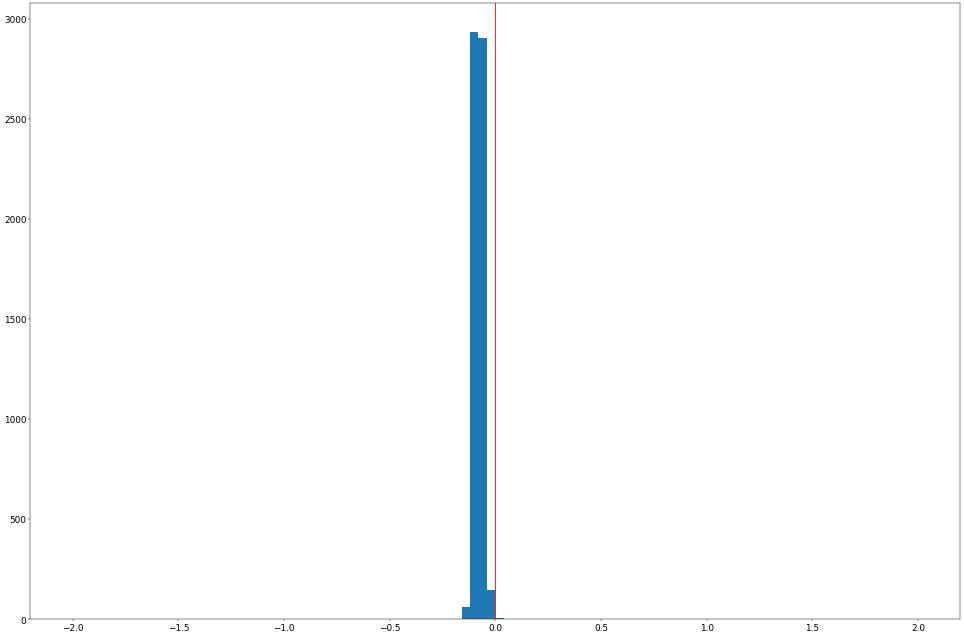

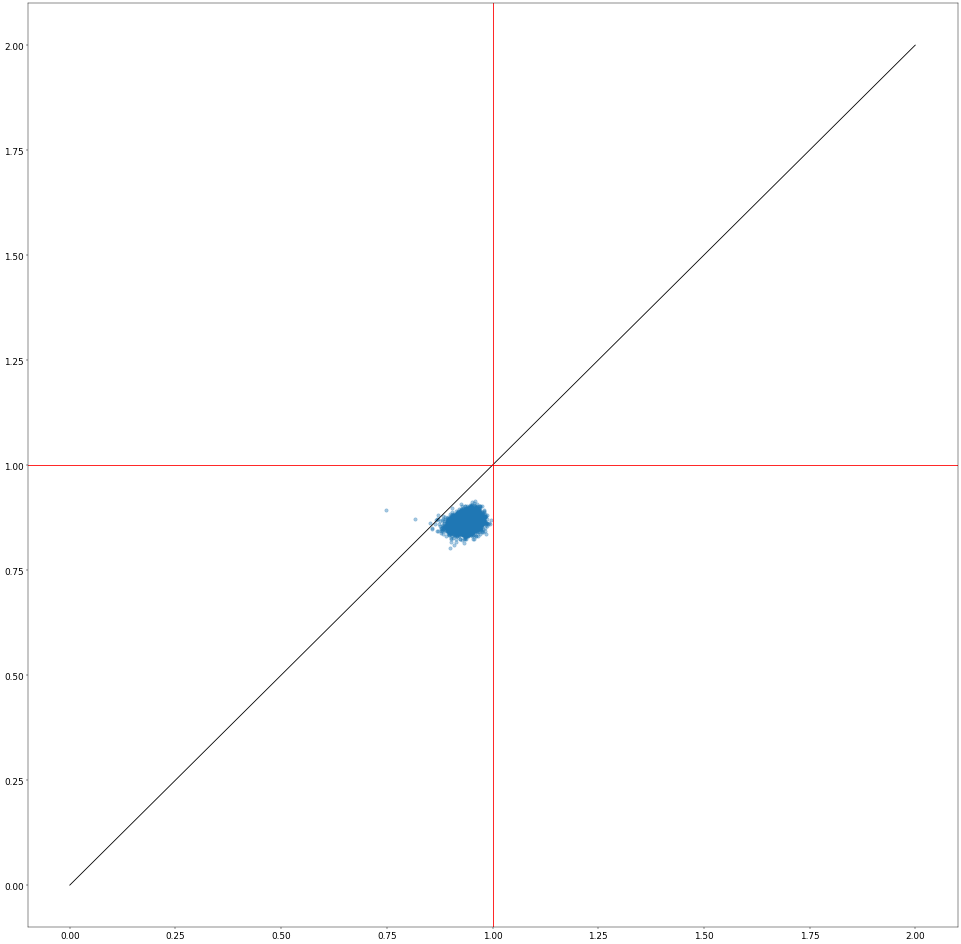

new best test loss: 1.0775550662494096
epoch: 5


100%|██████████| 121/121 [00:02<00:00, 42.37it/s]


batches for train: 121
train loss: 1.1443932204207112


100%|██████████| 61/61 [00:01<00:00, 53.83it/s]


batches for test: 61
test loss: 1.076096390114456
pred - true / true mean: -0.07753897
pred - true / true std: 0.018094618
mu,sig: -0.07753897 0.018094618


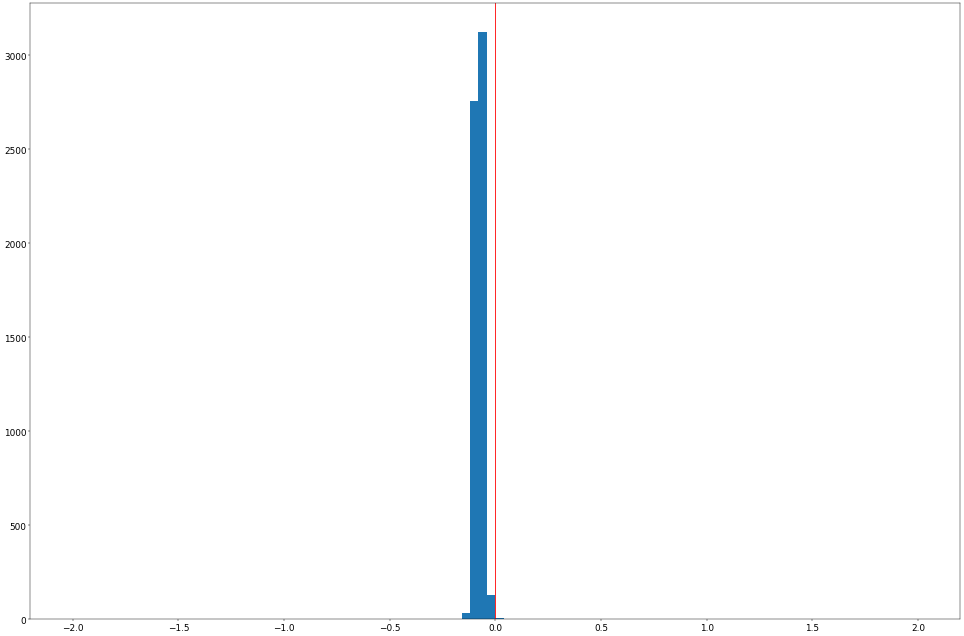

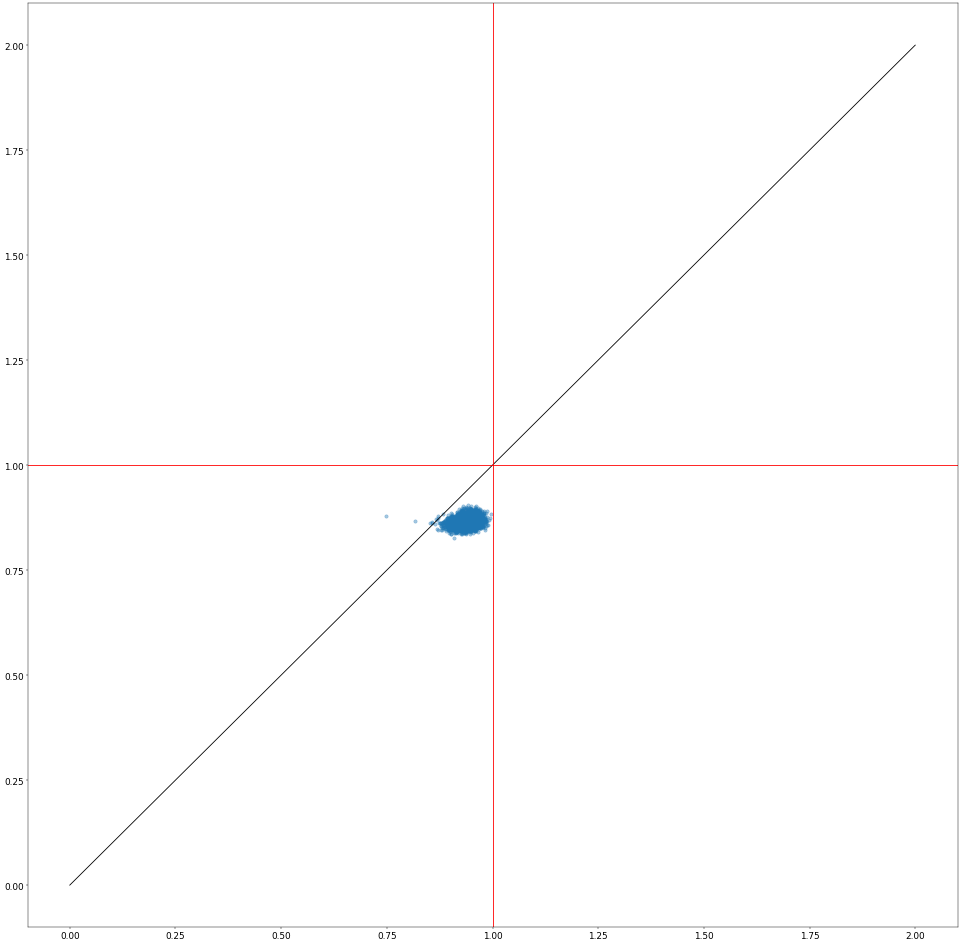

new best test loss: 1.076096390114456
epoch: 6


100%|██████████| 121/121 [00:02<00:00, 43.52it/s]


batches for train: 121
train loss: 1.1289926225488836


100%|██████████| 61/61 [00:01<00:00, 46.18it/s]


batches for test: 61
test loss: 1.0638602209872887
pred - true / true mean: -0.06532782
pred - true / true std: 0.017910305
mu,sig: -0.06532782 0.017910305


<Figure size 640x480 with 0 Axes>

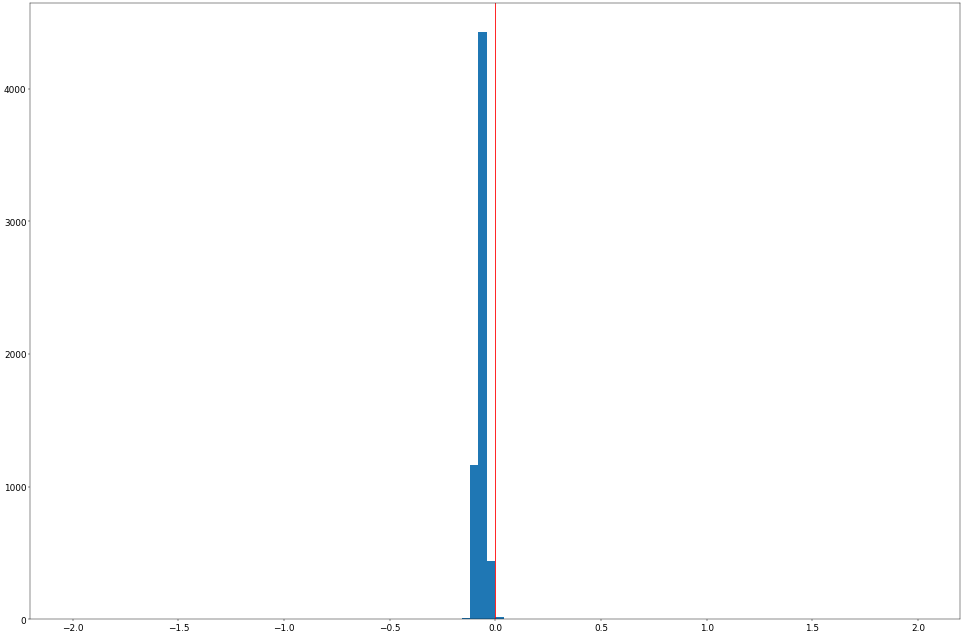

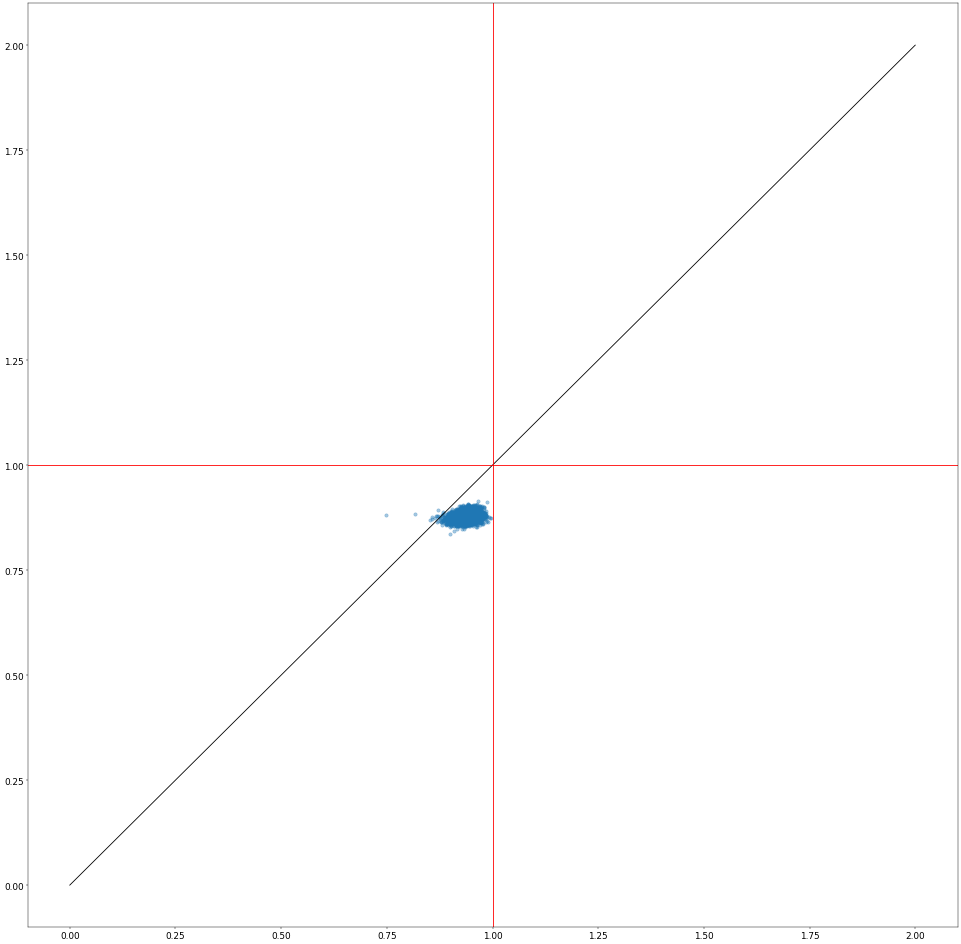

new best test loss: 1.0638602209872887
epoch: 7


100%|██████████| 121/121 [00:03<00:00, 33.46it/s]


batches for train: 121
train loss: 1.1156860668797137


100%|██████████| 61/61 [00:01<00:00, 45.92it/s]


batches for test: 61
test loss: 1.0524848836367247
pred - true / true mean: -0.053782478
pred - true / true std: 0.018029377
mu,sig: -0.053782478 0.018029377


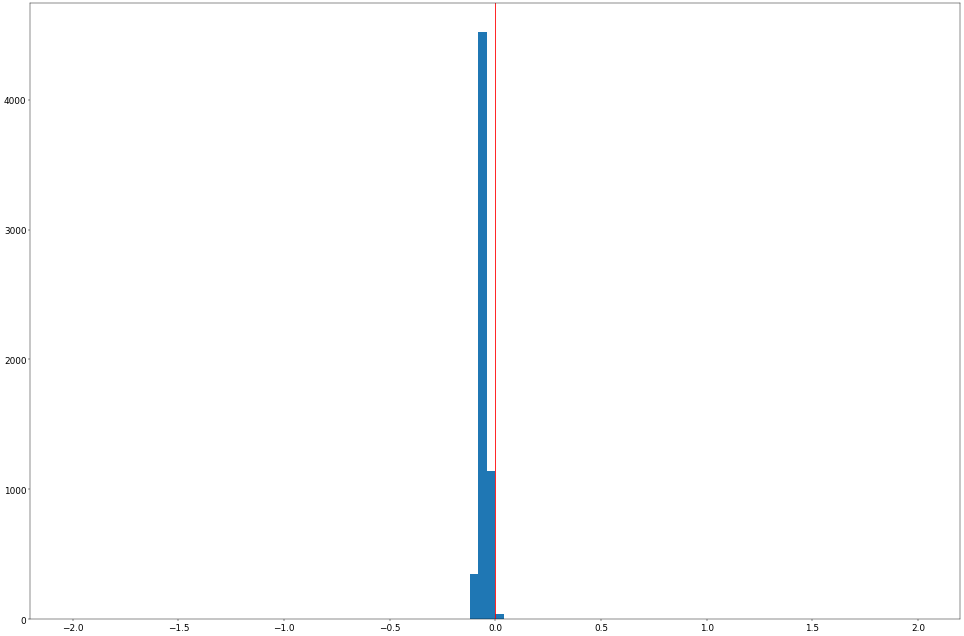

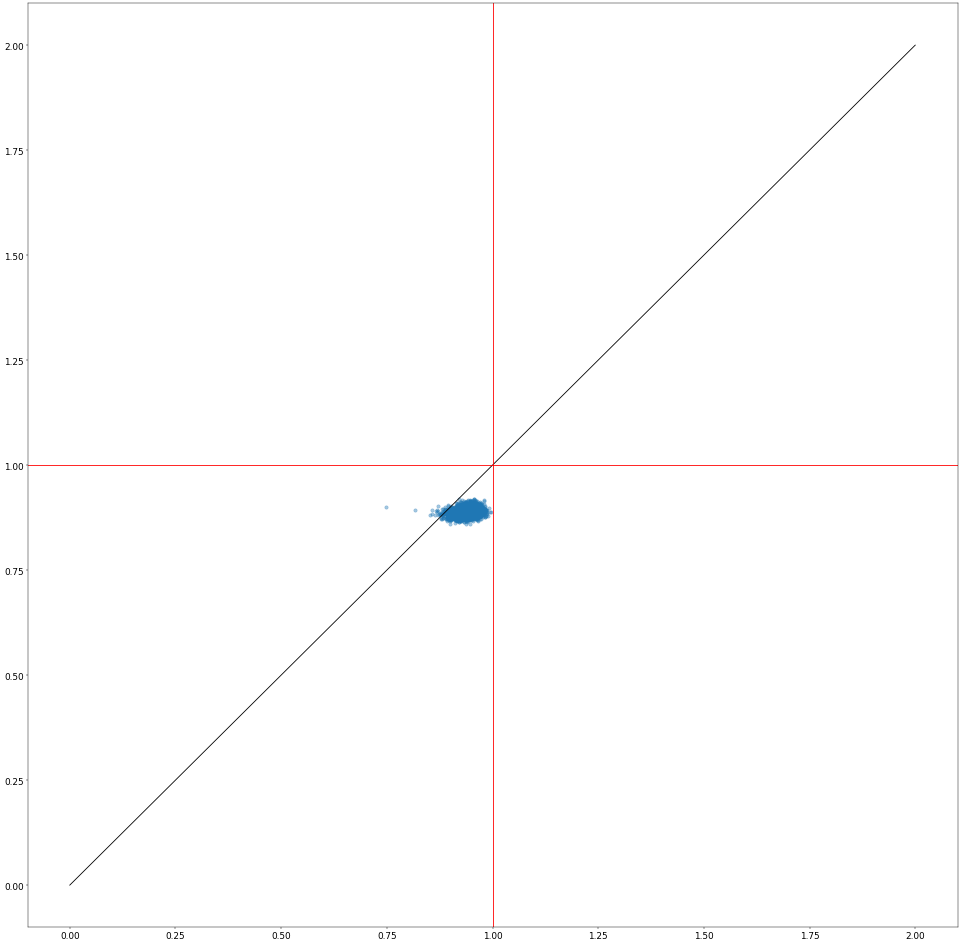

new best test loss: 1.0524848836367247
epoch: 8


100%|██████████| 121/121 [00:03<00:00, 35.03it/s]


batches for train: 121
train loss: 1.1044185861083102


100%|██████████| 61/61 [00:01<00:00, 46.20it/s]


batches for test: 61
test loss: 1.0547315859403767
pred - true / true mean: -0.05606616
pred - true / true std: 0.018538775
mu,sig: -0.05606616 0.018538775


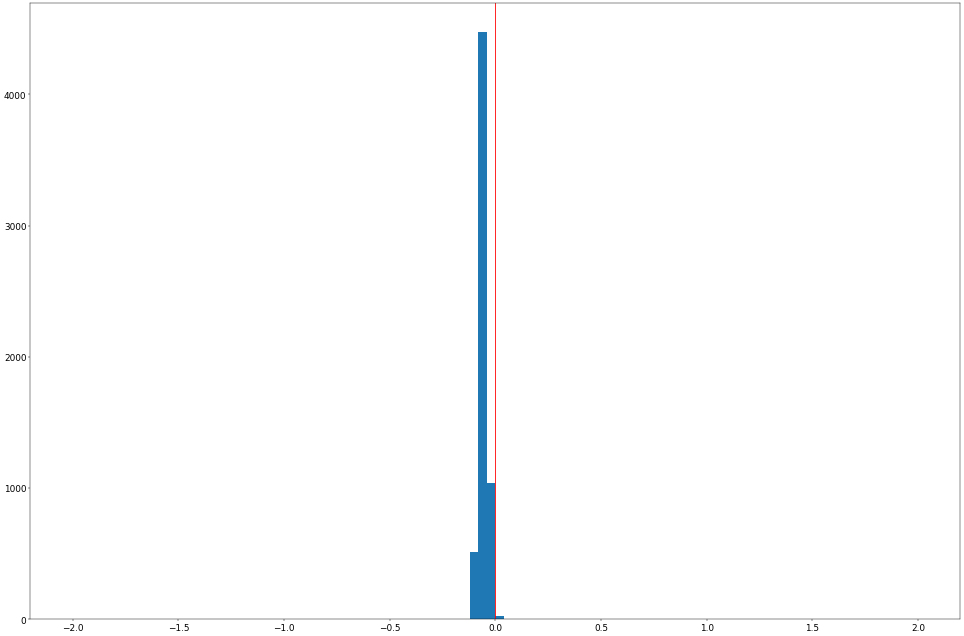

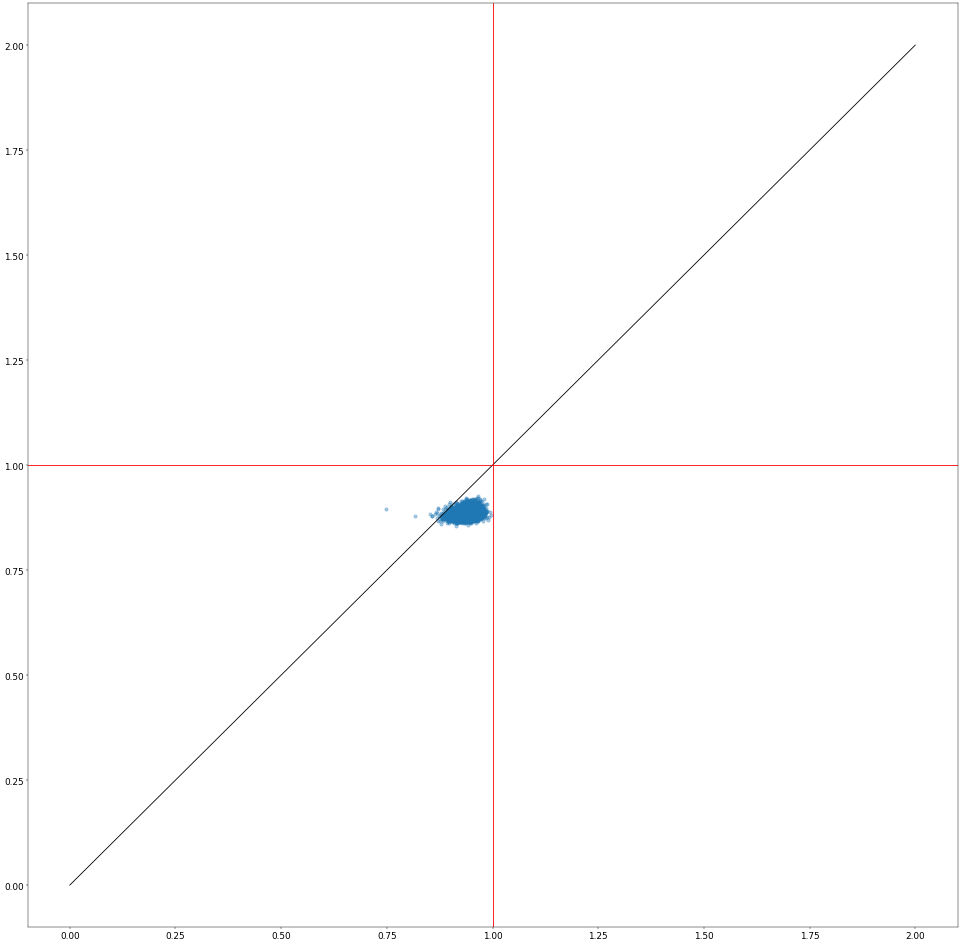

epoch: 9


100%|██████████| 121/121 [00:03<00:00, 33.28it/s]


batches for train: 121
train loss: 1.09351622959799


100%|██████████| 61/61 [00:01<00:00, 54.84it/s]


batches for test: 61
test loss: 1.0387349070095626
pred - true / true mean: -0.039493617
pred - true / true std: 0.018082775
mu,sig: -0.039493617 0.018082775


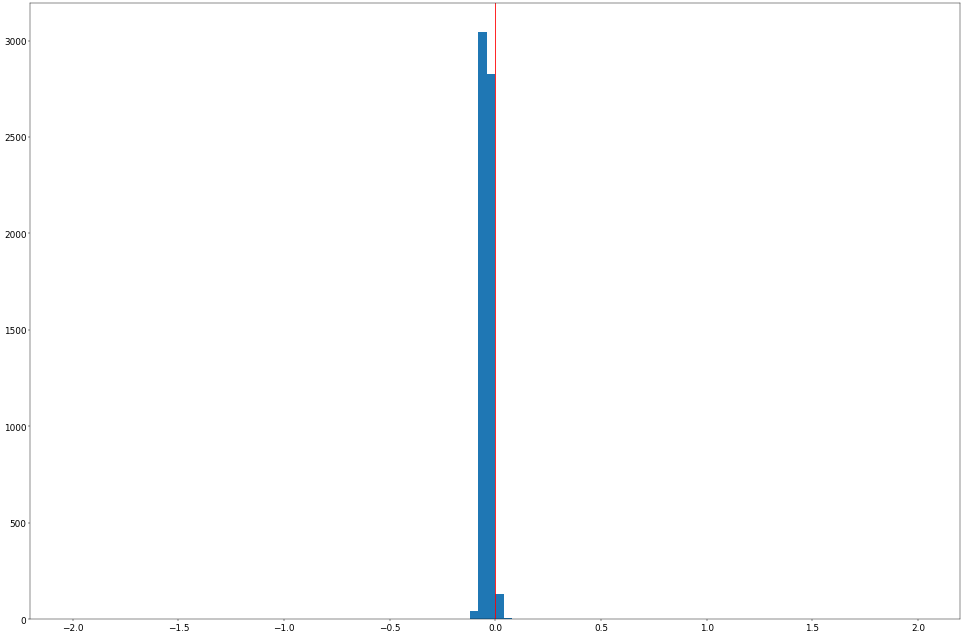

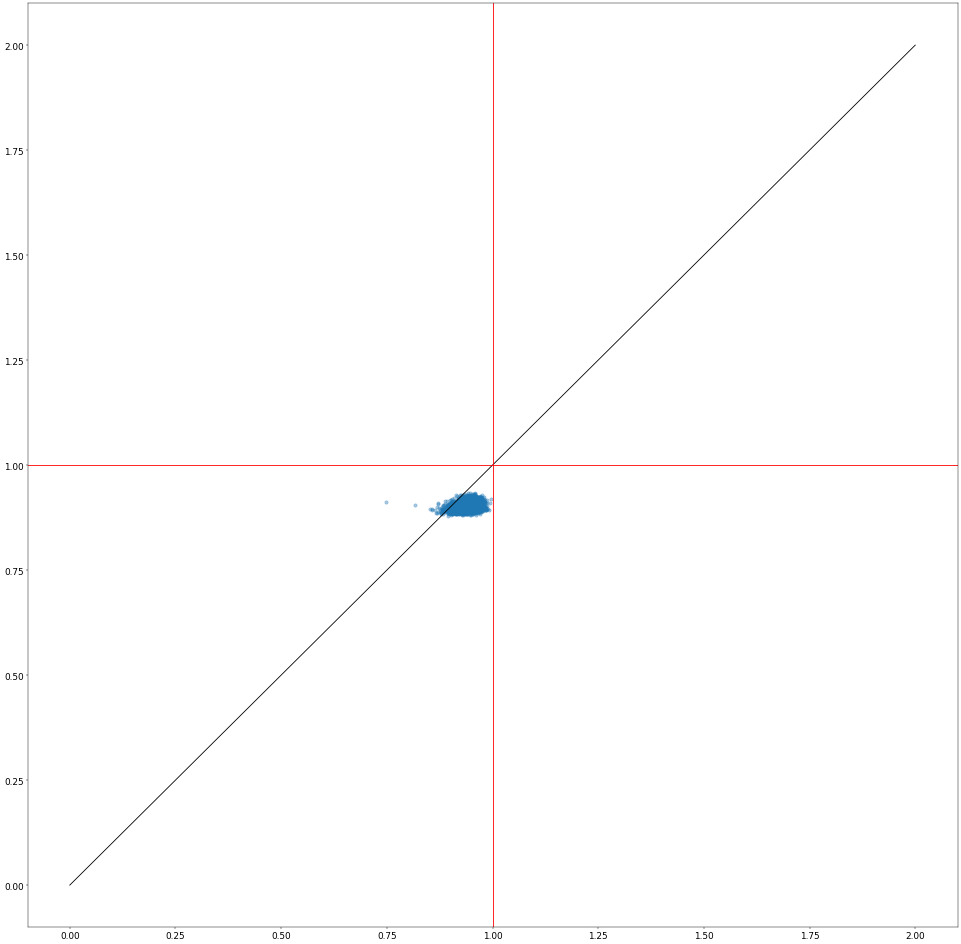

new best test loss: 1.0387349070095626


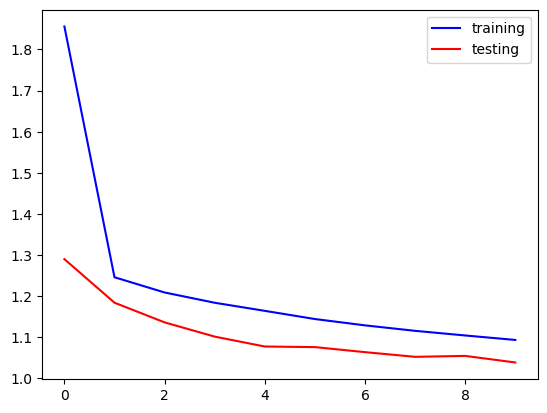

epoch: 10


100%|██████████| 121/121 [00:02<00:00, 43.30it/s]


batches for train: 121
train loss: 1.0858681930983363


100%|██████████| 61/61 [00:01<00:00, 55.72it/s]


batches for test: 61
test loss: 1.062180636359043
pred - true / true mean: -0.0635939
pred - true / true std: 0.019588862
mu,sig: -0.0635939 0.019588862


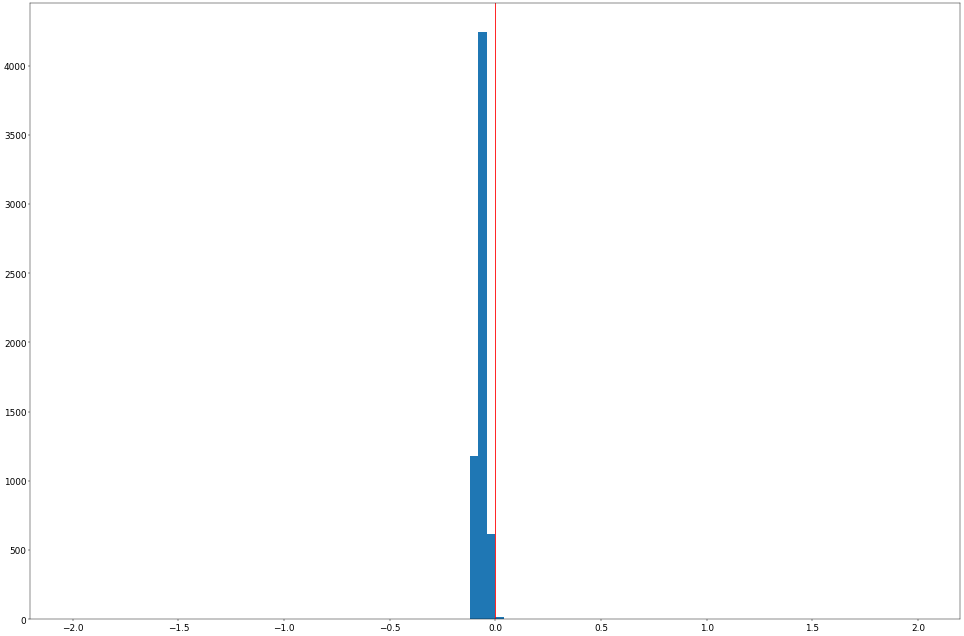

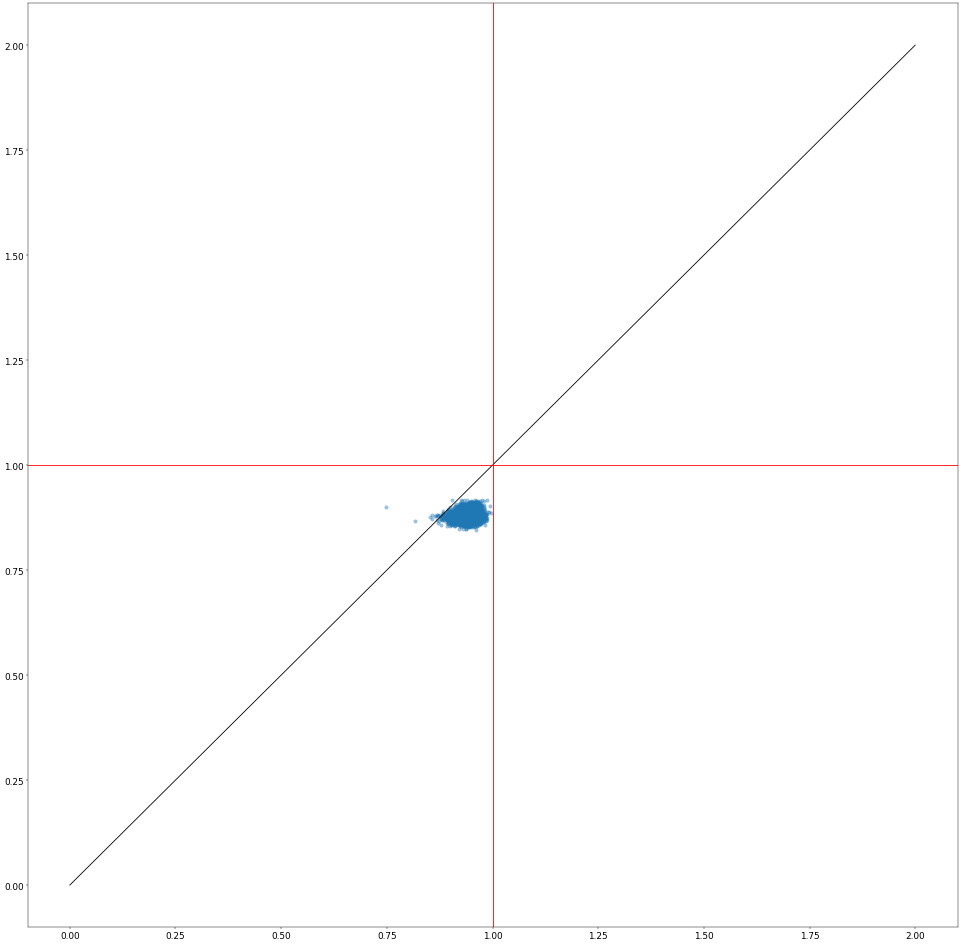

epoch: 11


100%|██████████| 121/121 [00:02<00:00, 42.23it/s]


batches for train: 121
train loss: 1.0782702501155128


100%|██████████| 61/61 [00:01<00:00, 53.80it/s]


batches for test: 61
test loss: 1.0639534074752057
pred - true / true mean: -0.0653579
pred - true / true std: 0.020274824
mu,sig: -0.0653579 0.020274824


<Figure size 640x480 with 0 Axes>

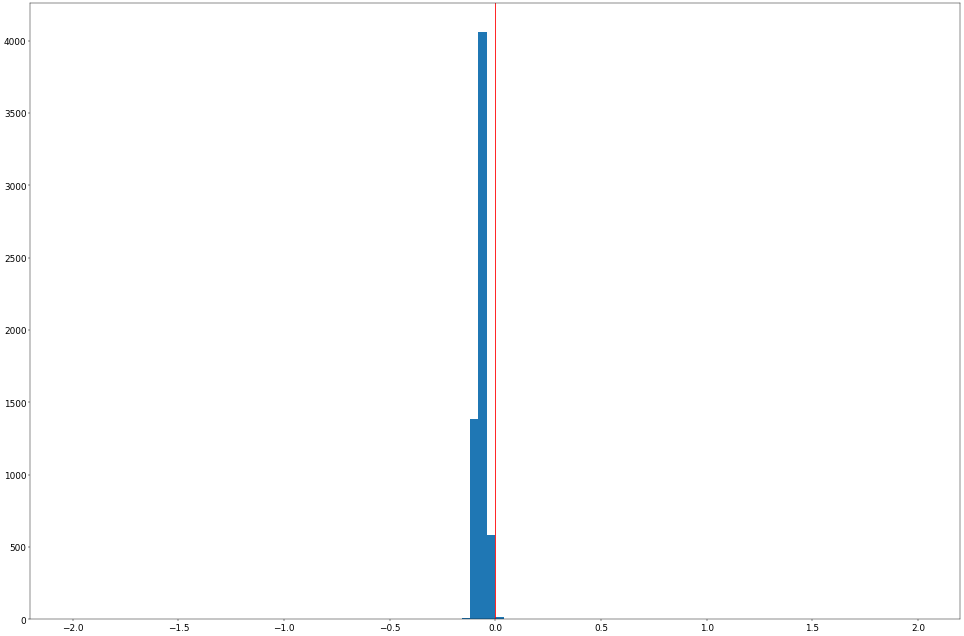

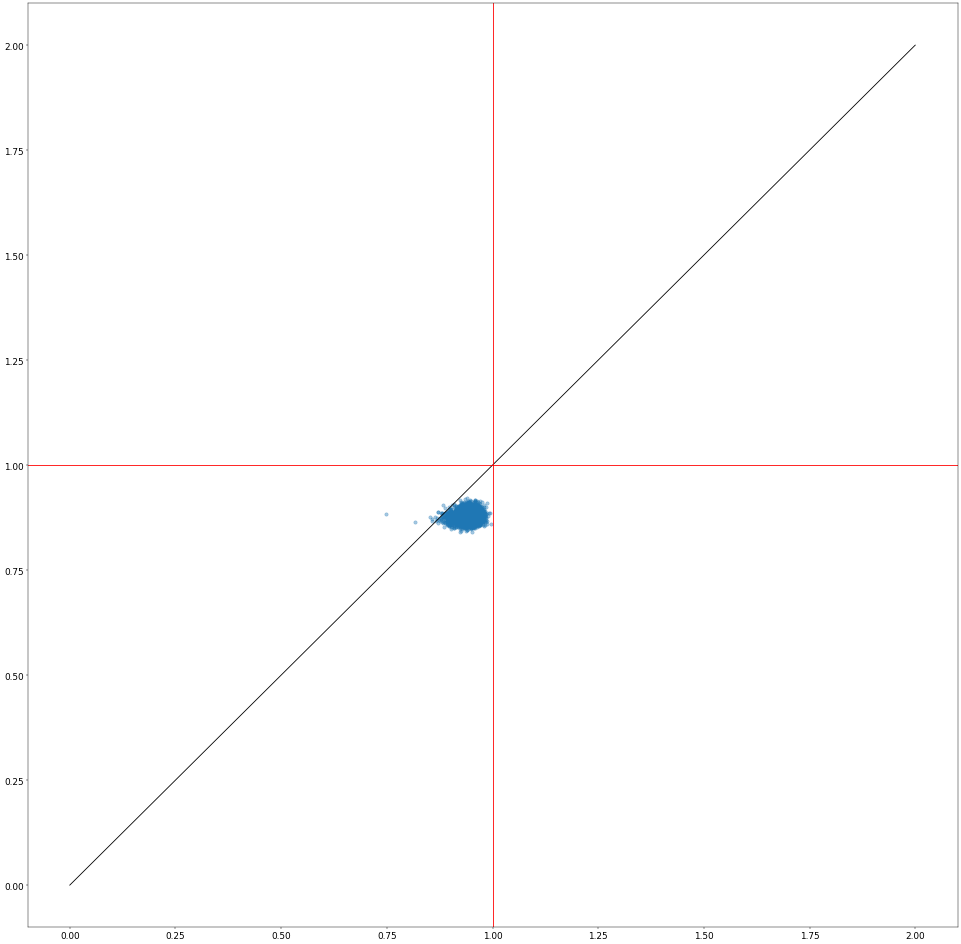

epoch: 12


100%|██████████| 121/121 [00:02<00:00, 44.04it/s]


batches for train: 121
train loss: 1.0723685558177223


100%|██████████| 61/61 [00:01<00:00, 52.28it/s]


batches for test: 61
test loss: 1.0384521718885078
pred - true / true mean: -0.03893639
pred - true / true std: 0.018837934
mu,sig: -0.03893639 0.018837934


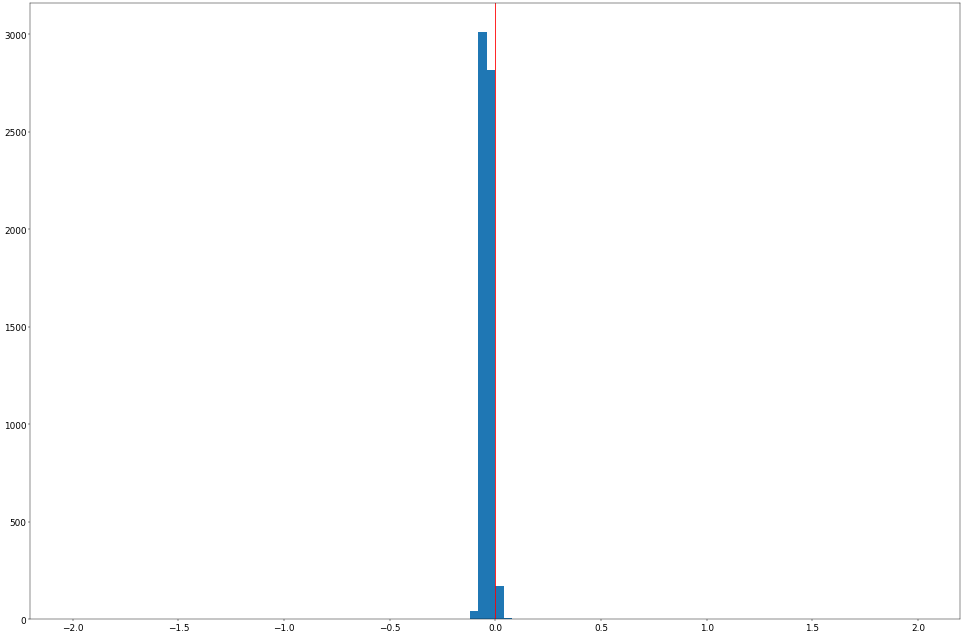

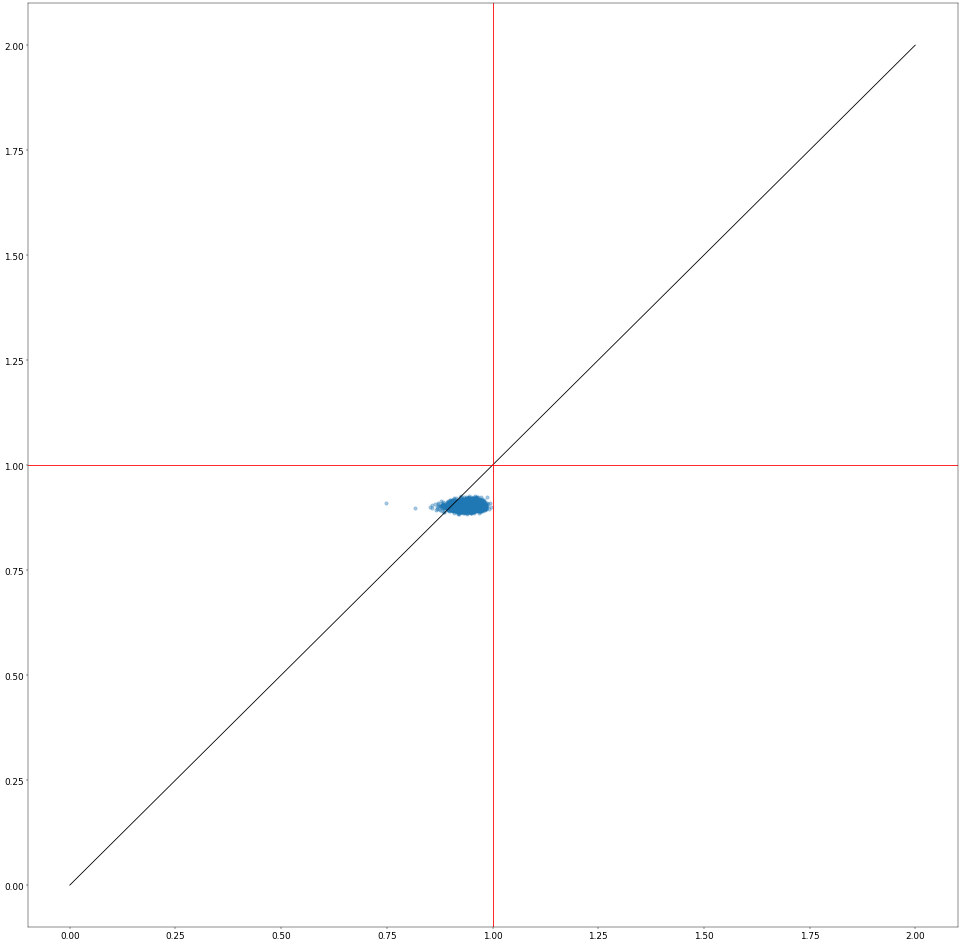

new best test loss: 1.0384521718885078
epoch: 13


100%|██████████| 121/121 [00:03<00:00, 34.06it/s]


batches for train: 121
train loss: 1.067370042328007


100%|██████████| 61/61 [00:01<00:00, 49.13it/s]


batches for test: 61
test loss: 1.0366439057178185
pred - true / true mean: -0.03698261
pred - true / true std: 0.018606398
mu,sig: -0.03698261 0.018606398


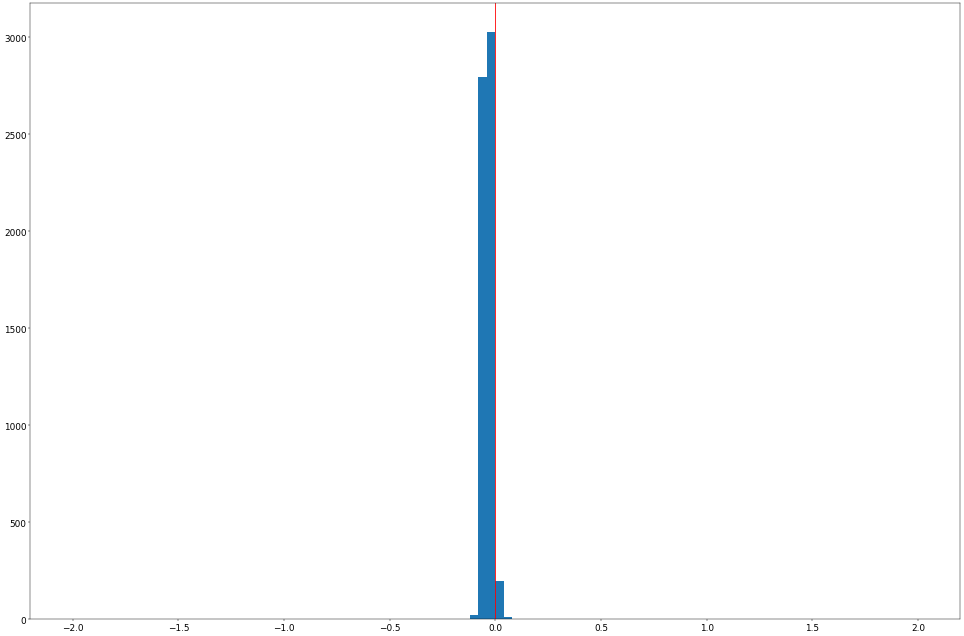

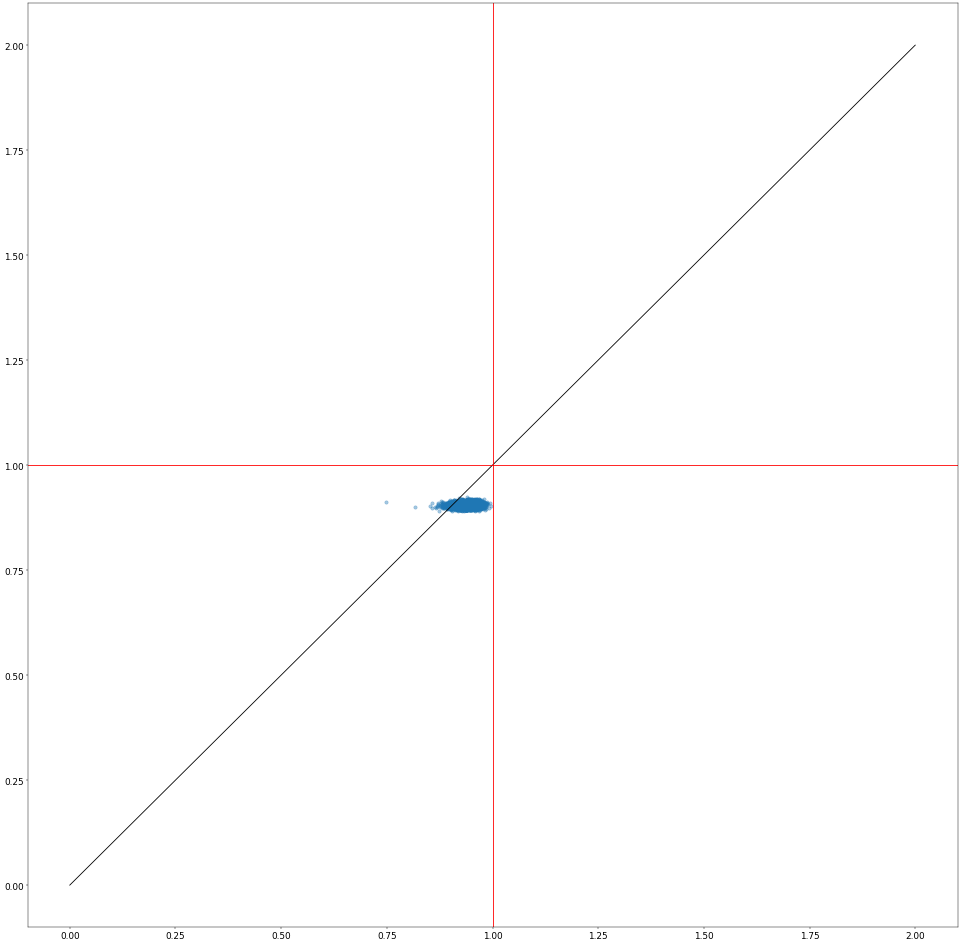

new best test loss: 1.0366439057178185
epoch: 14


100%|██████████| 121/121 [00:02<00:00, 41.91it/s]


batches for train: 121
train loss: 1.0621742295824792


100%|██████████| 61/61 [00:01<00:00, 52.39it/s]


batches for test: 61
test loss: 1.0258131046764185
pred - true / true mean: -0.02445283
pred - true / true std: 0.018541621
mu,sig: -0.02445283 0.018541621


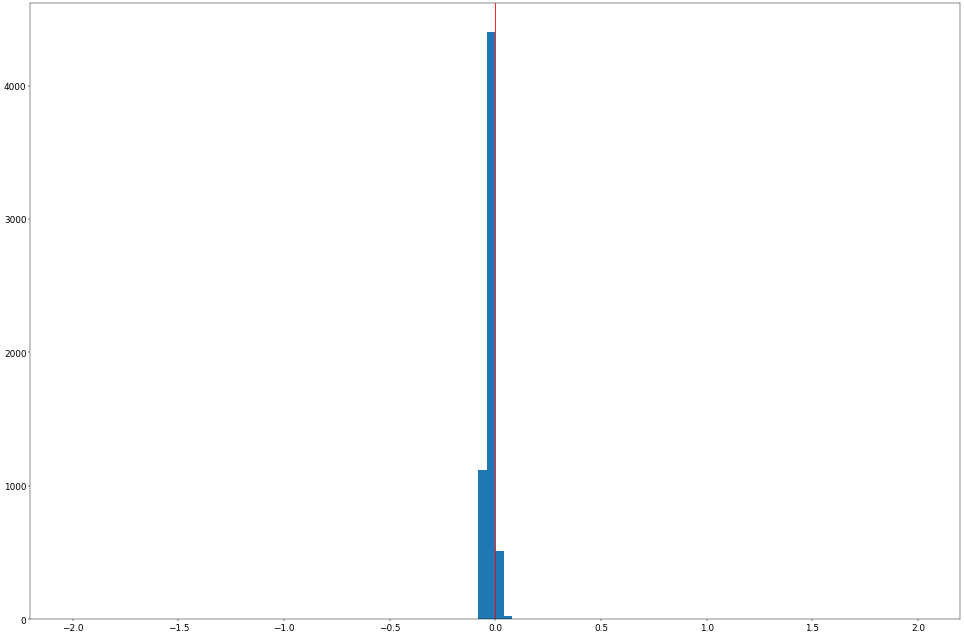

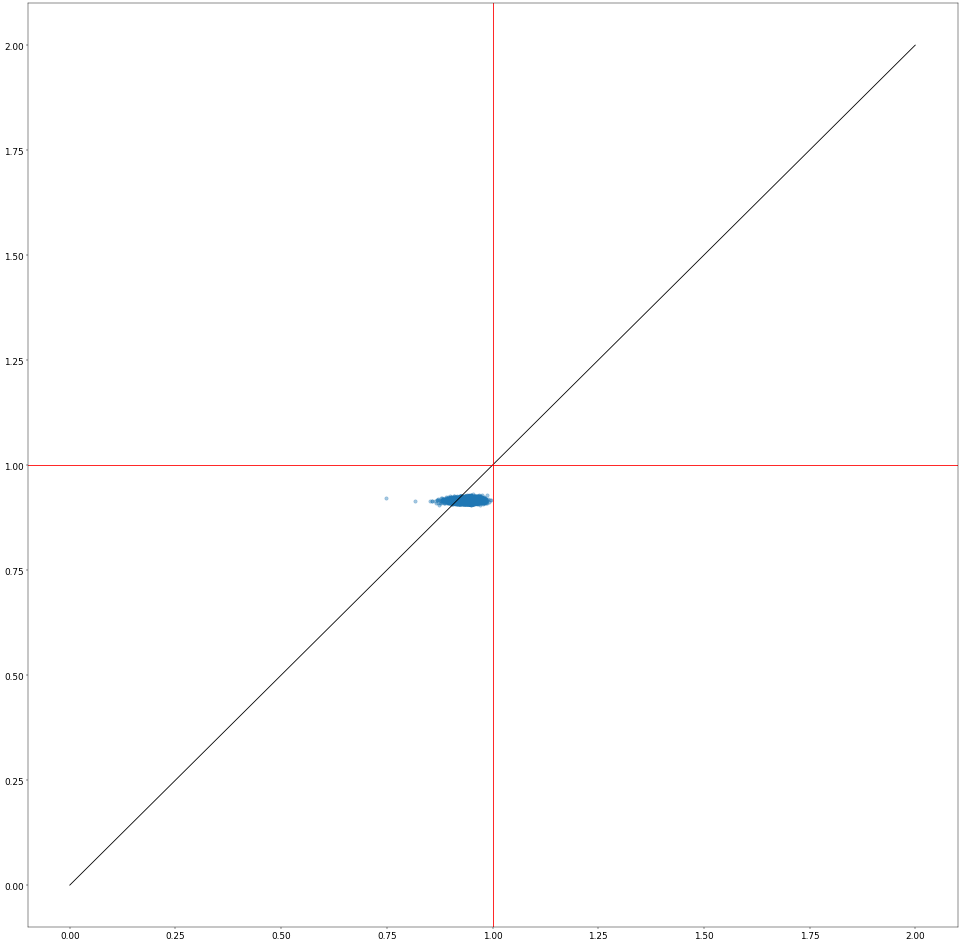

new best test loss: 1.0258131046764185
epoch: 15


100%|██████████| 121/121 [00:03<00:00, 38.83it/s]


batches for train: 121
train loss: 1.0580151652501635


100%|██████████| 61/61 [00:01<00:00, 52.67it/s]


batches for test: 61
test loss: 1.0189914410231544
pred - true / true mean: -0.0148748895
pred - true / true std: 0.01868645
mu,sig: -0.0148748895 0.01868645


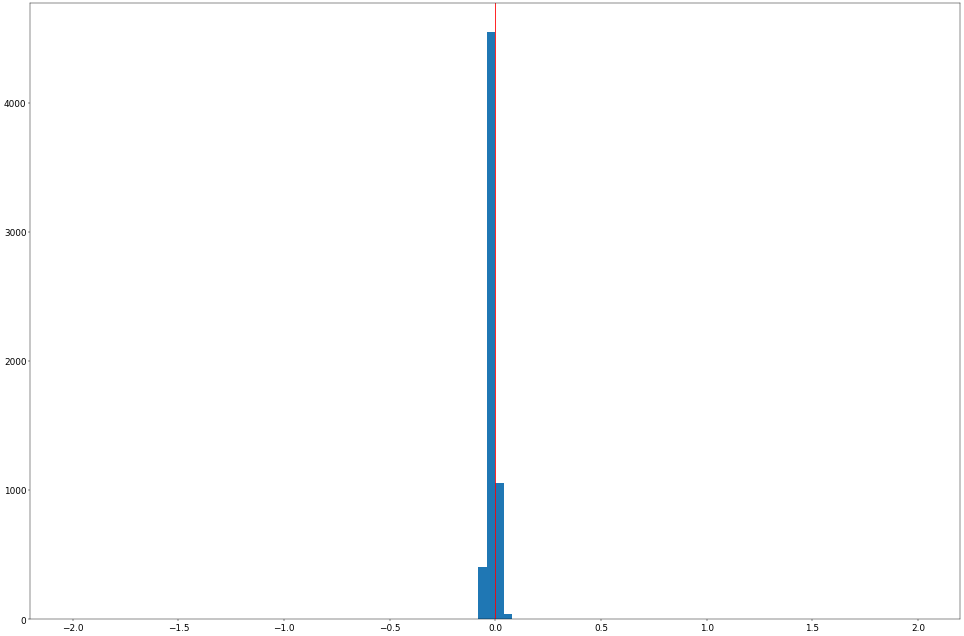

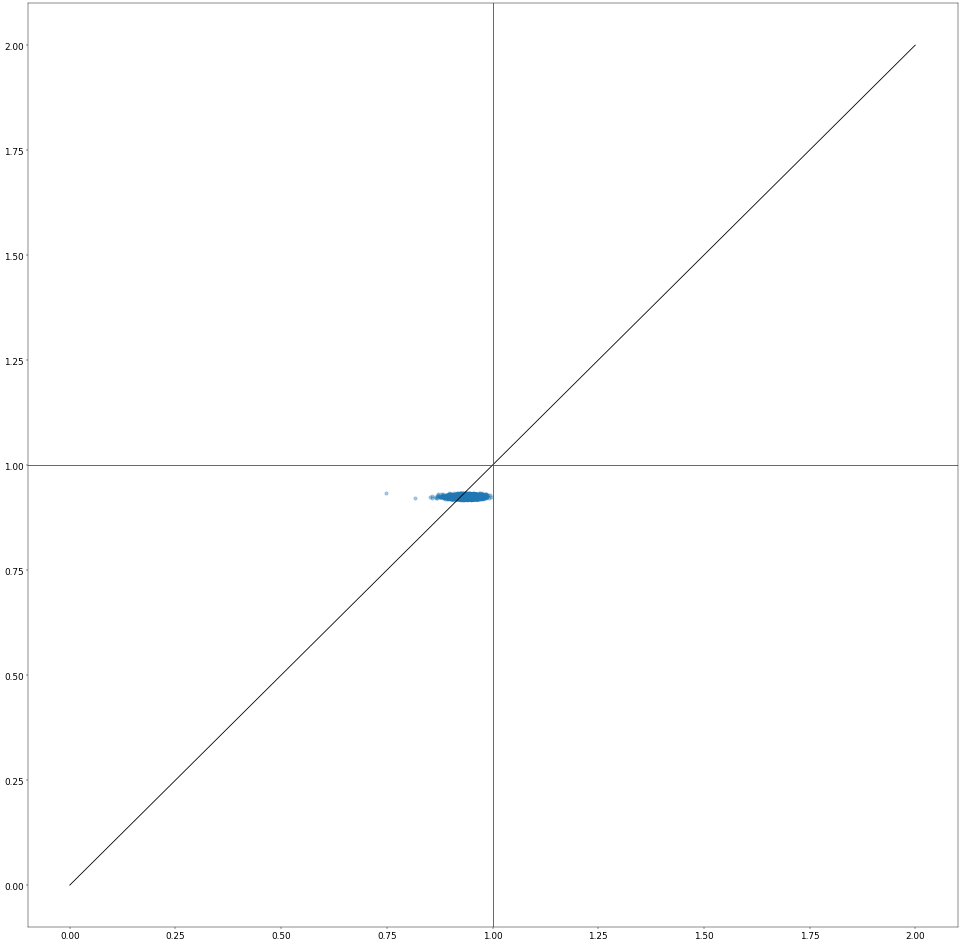

new best test loss: 1.0189914410231544
epoch: 16


100%|██████████| 121/121 [00:03<00:00, 40.29it/s]


batches for train: 121
train loss: 1.0539068367855609


100%|██████████| 61/61 [00:01<00:00, 54.73it/s]


batches for test: 61
test loss: 1.0185952049786928
pred - true / true mean: -0.014220422
pred - true / true std: 0.018674478
mu,sig: -0.014220422 0.018674478


<Figure size 640x480 with 0 Axes>

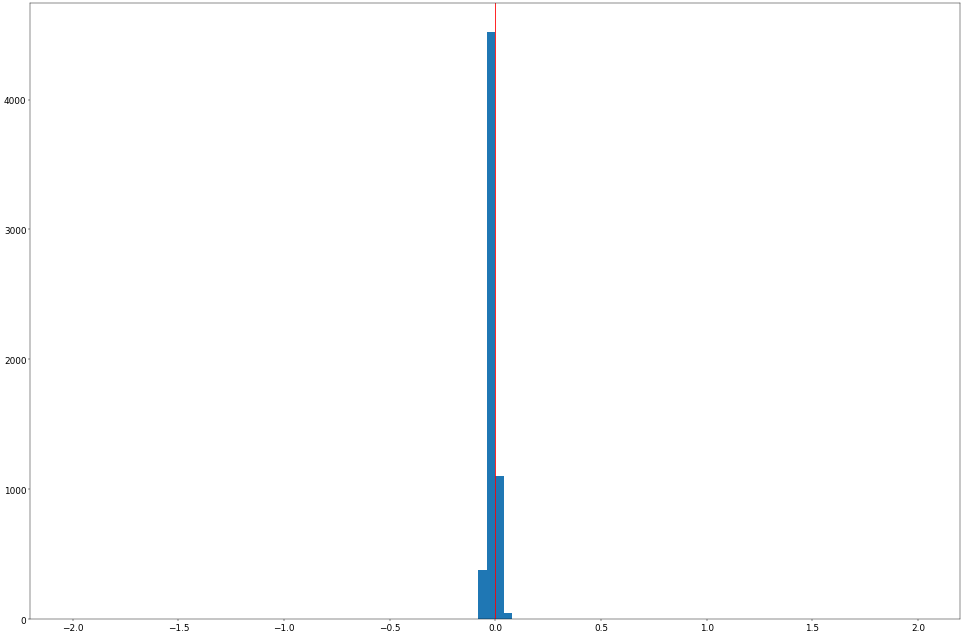

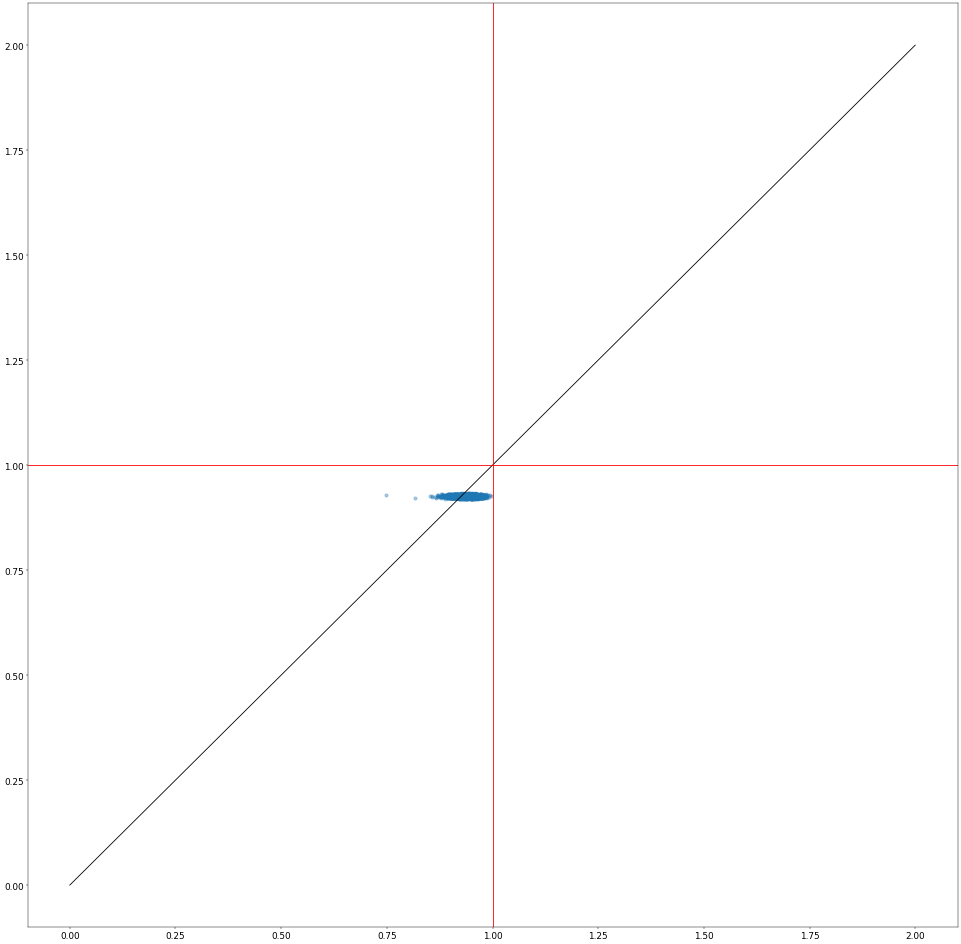

new best test loss: 1.0185952049786928
epoch: 17


100%|██████████| 121/121 [00:03<00:00, 39.11it/s]


batches for train: 121
train loss: 1.0500214513668344


100%|██████████| 61/61 [00:01<00:00, 53.27it/s]


batches for test: 61
test loss: 1.017854127727571
pred - true / true mean: -0.012846929
pred - true / true std: 0.018795794
mu,sig: -0.012846929 0.018795794


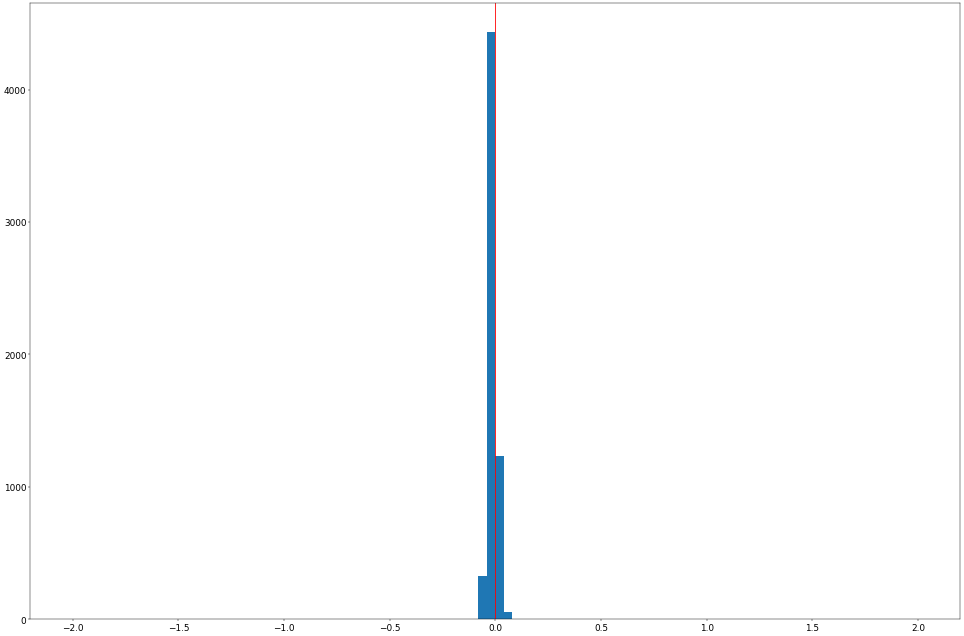

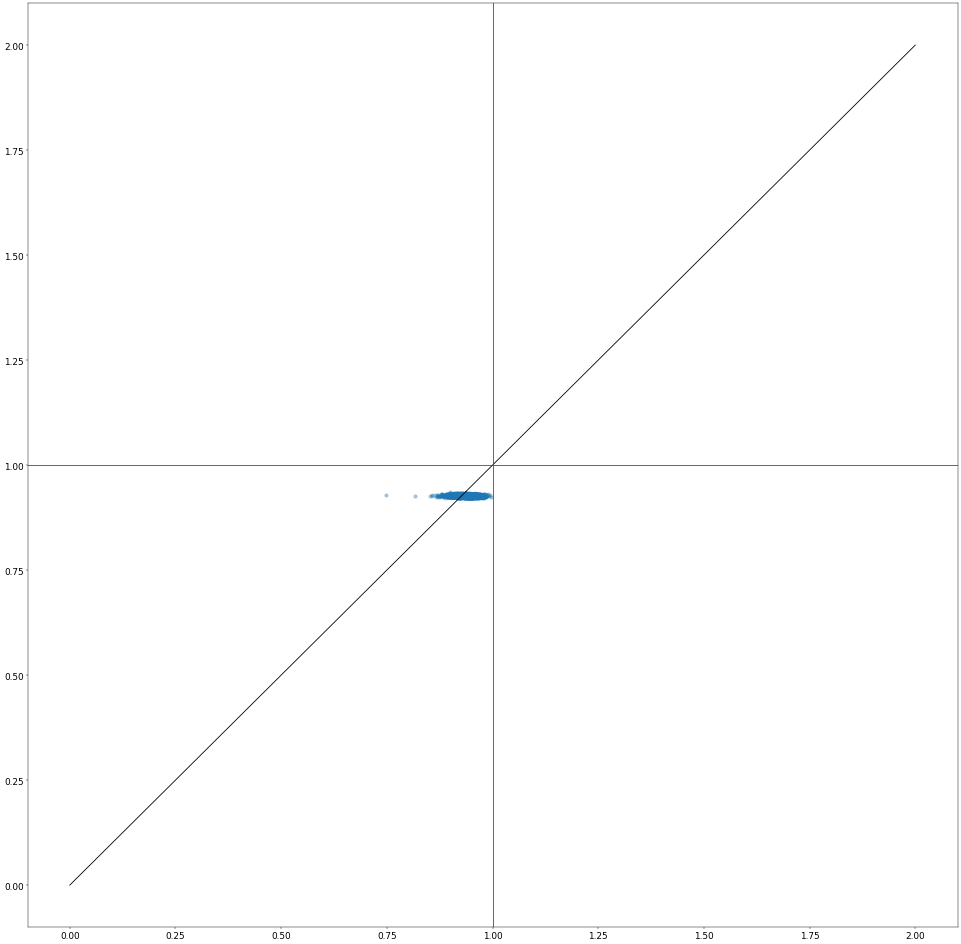

new best test loss: 1.017854127727571
epoch: 18


100%|██████████| 121/121 [00:03<00:00, 40.29it/s]


batches for train: 121
train loss: 1.0464429037630065


100%|██████████| 61/61 [00:01<00:00, 50.30it/s]


batches for test: 61
test loss: 1.018570215975652
pred - true / true mean: -0.014012115
pred - true / true std: 0.01882731
mu,sig: -0.014012115 0.01882731


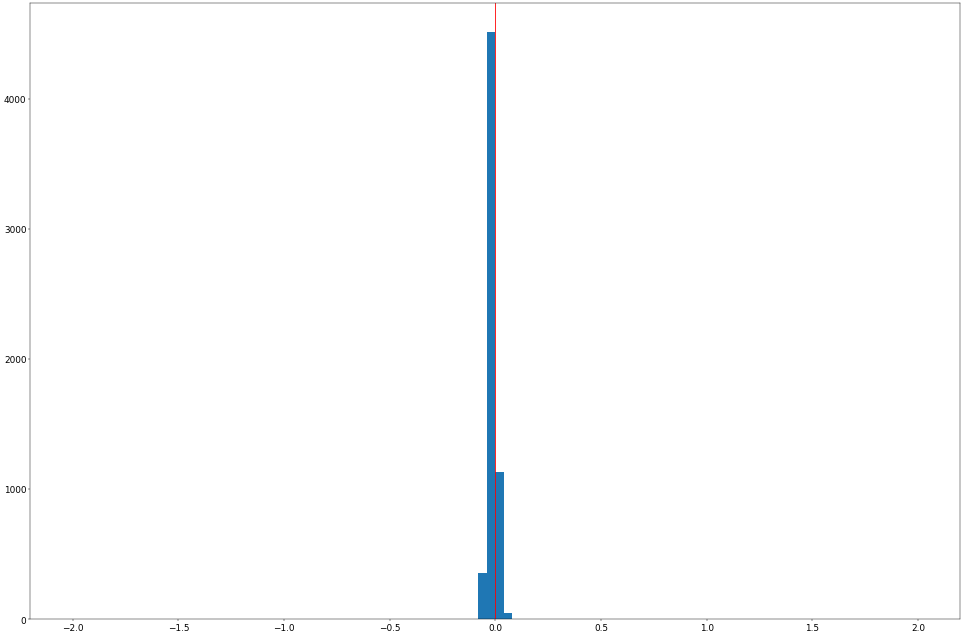

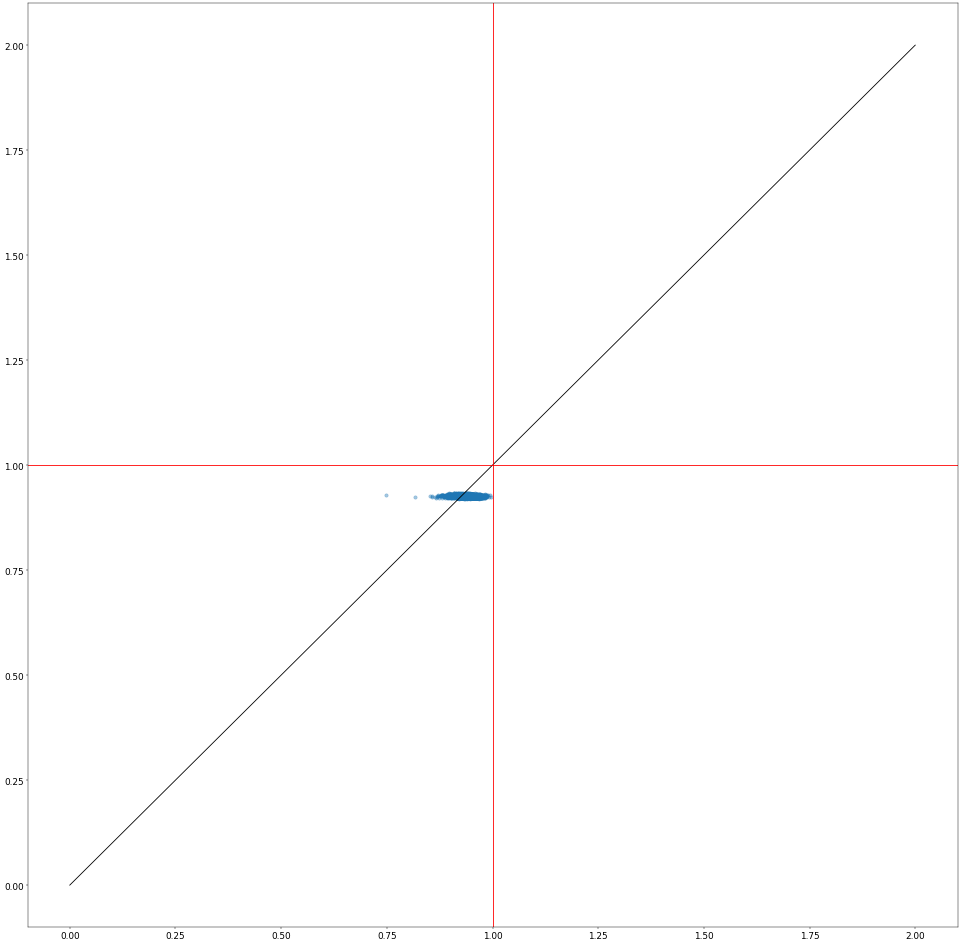

epoch: 19


100%|██████████| 121/121 [00:03<00:00, 33.09it/s]


batches for train: 121
train loss: 1.0425131902221805


100%|██████████| 61/61 [00:01<00:00, 54.14it/s]


batches for test: 61
test loss: 1.018249312385184
pred - true / true mean: -0.013526902
pred - true / true std: 0.01877008
mu,sig: -0.013526902 0.01877008


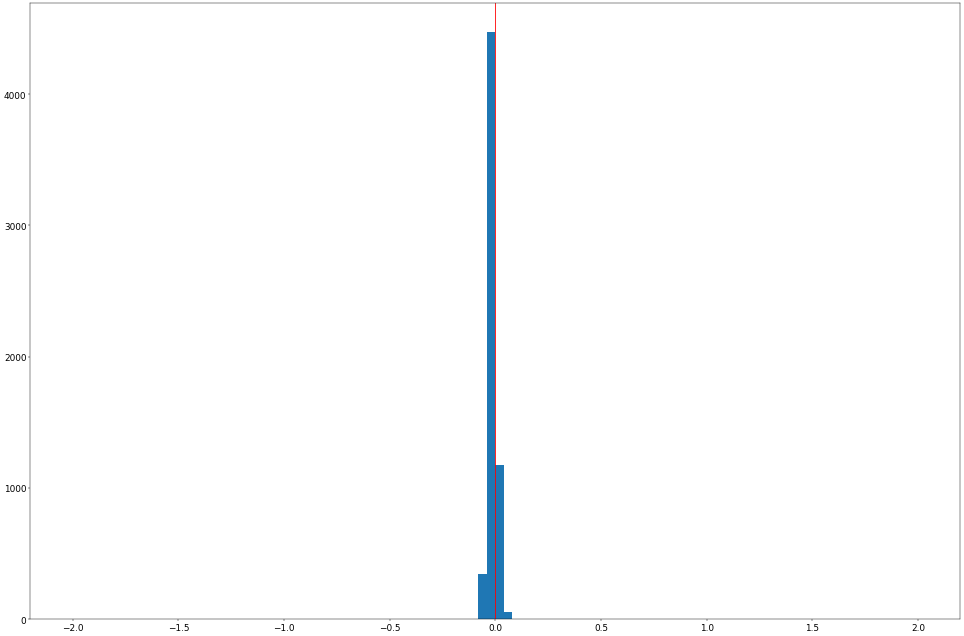

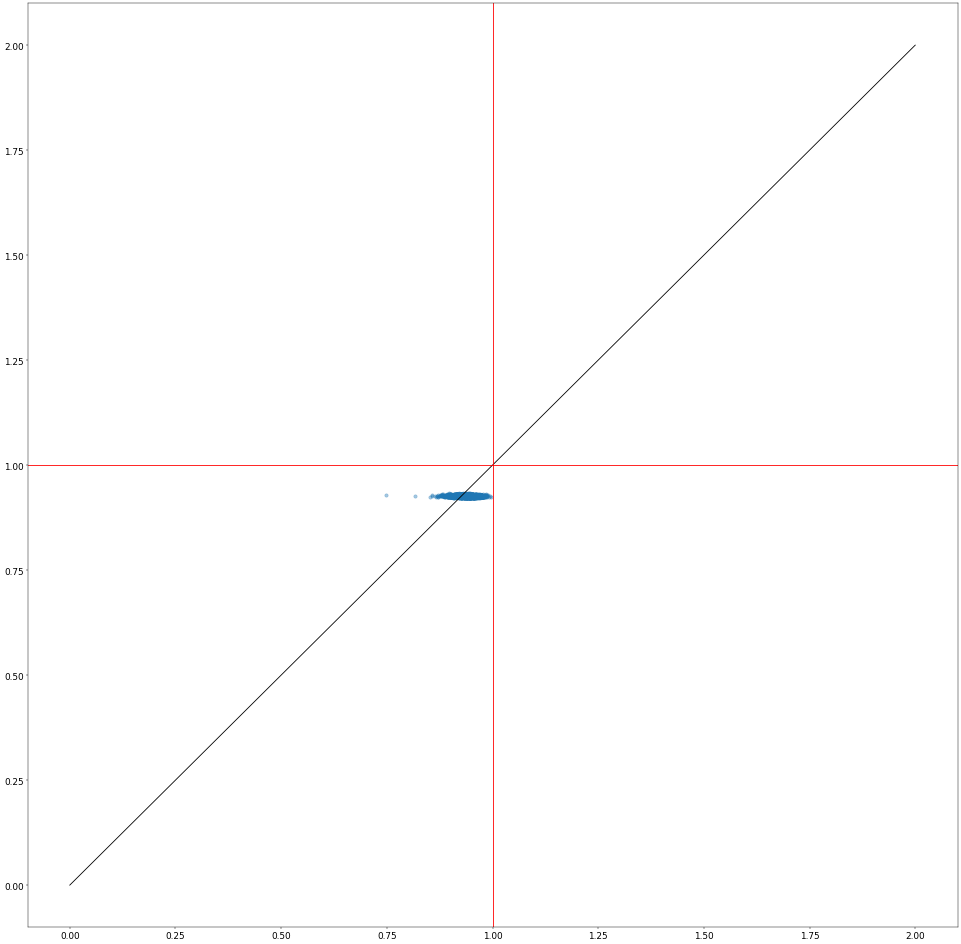

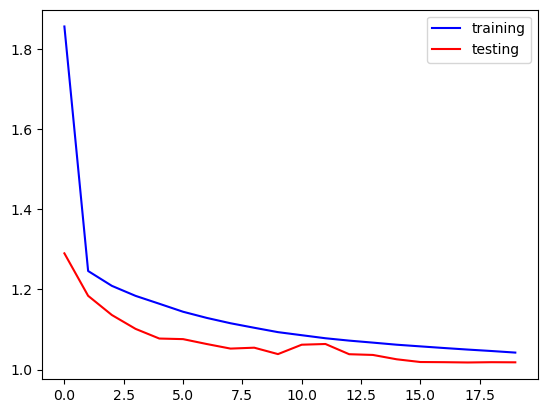

epoch: 20


100%|██████████| 121/121 [00:03<00:00, 37.65it/s]


batches for train: 121
train loss: 1.0397125738711397


100%|██████████| 61/61 [00:01<00:00, 54.38it/s]


batches for test: 61
test loss: 1.0176209289519513
pred - true / true mean: -0.012516339
pred - true / true std: 0.01870429
mu,sig: -0.012516339 0.01870429


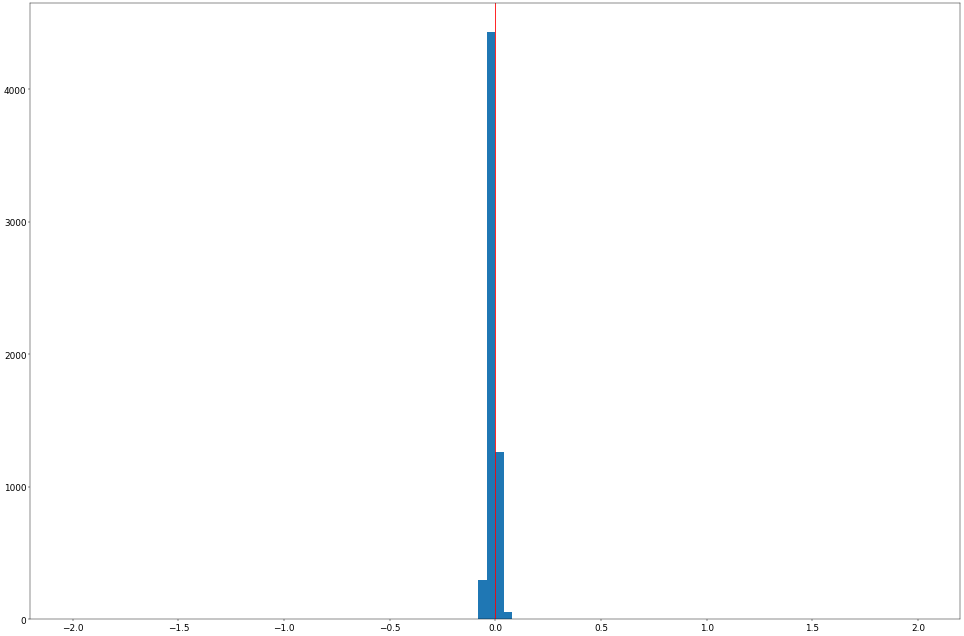

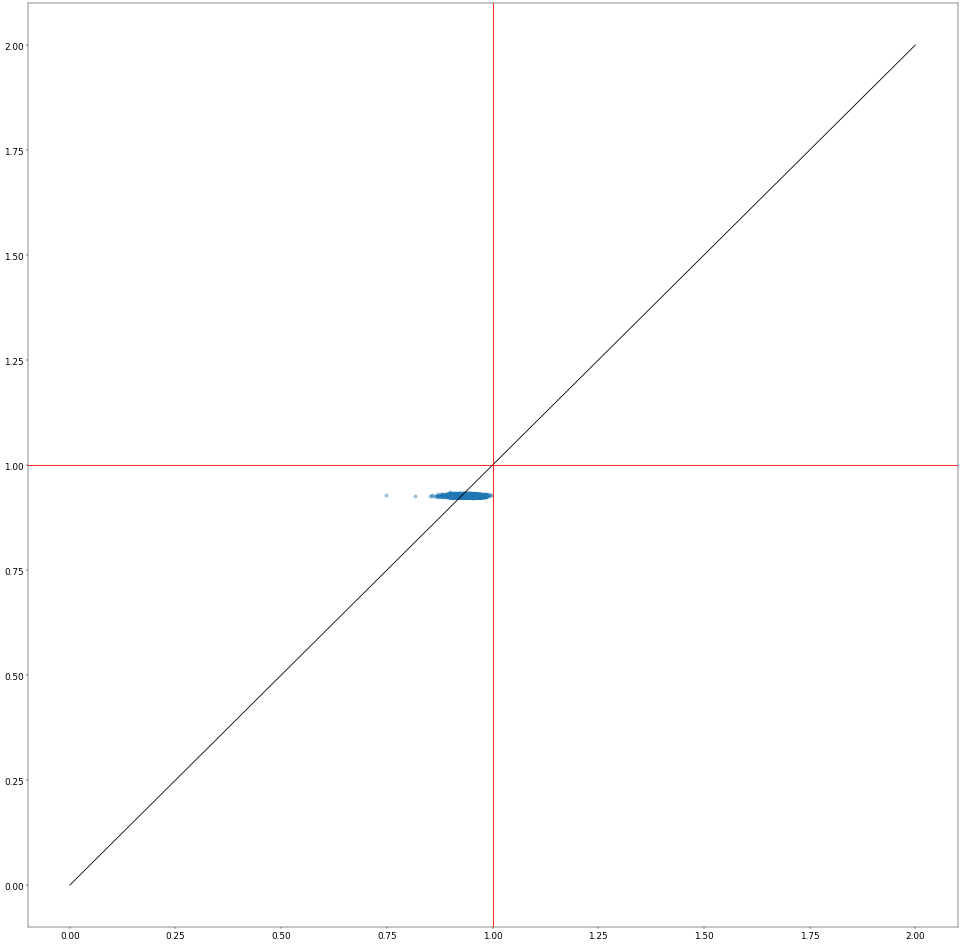

new best test loss: 1.0176209289519513
epoch: 21


100%|██████████| 121/121 [00:03<00:00, 36.76it/s]


batches for train: 121
train loss: 1.0361396626007457


100%|██████████| 61/61 [00:01<00:00, 46.47it/s]


batches for test: 61
test loss: 1.0188692319588584
pred - true / true mean: -0.014572833
pred - true / true std: 0.018754616
mu,sig: -0.014572833 0.018754616


<Figure size 640x480 with 0 Axes>

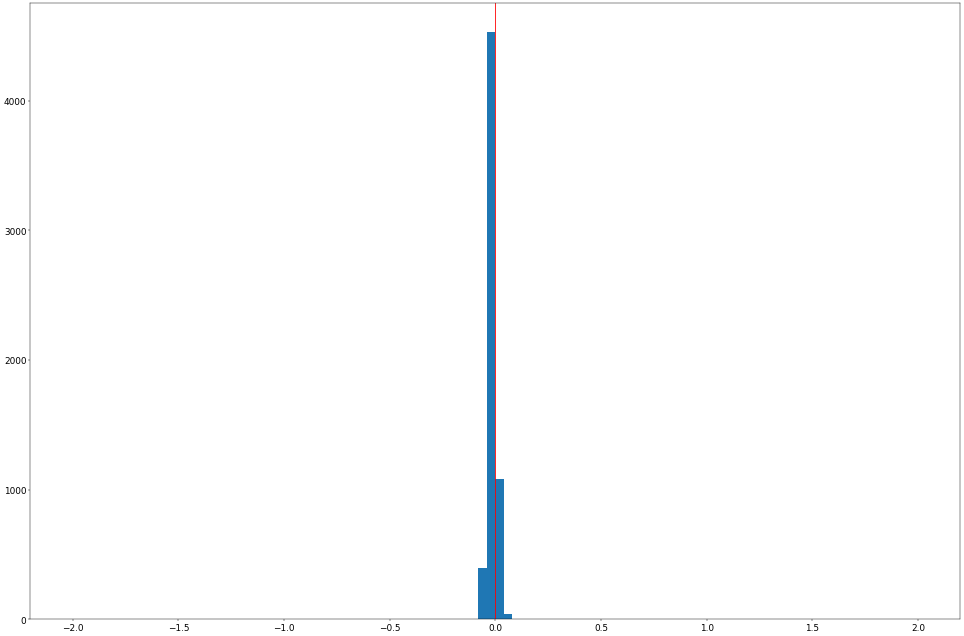

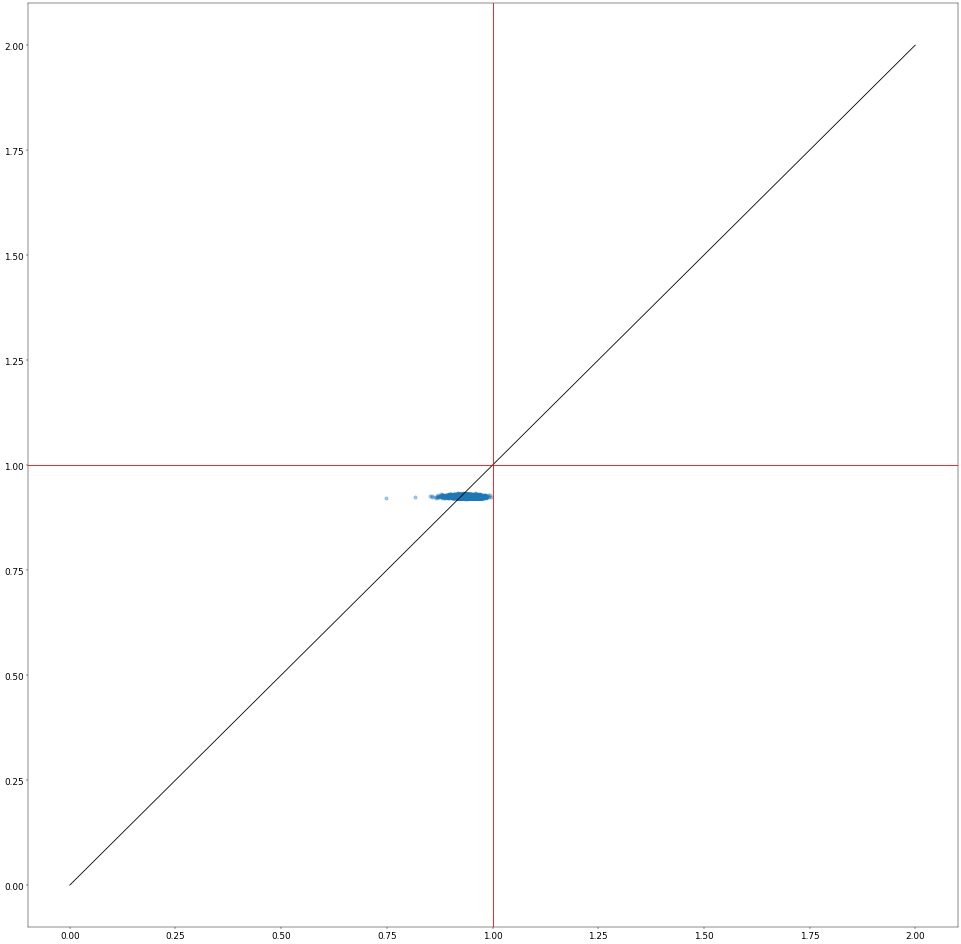

epoch: 22


100%|██████████| 121/121 [00:02<00:00, 42.46it/s]


batches for train: 121
train loss: 1.0326384443882084


100%|██████████| 61/61 [00:01<00:00, 54.47it/s]


batches for test: 61
test loss: 1.01668511257797
pred - true / true mean: -0.010796259
pred - true / true std: 0.018649502
mu,sig: -0.010796259 0.018649502


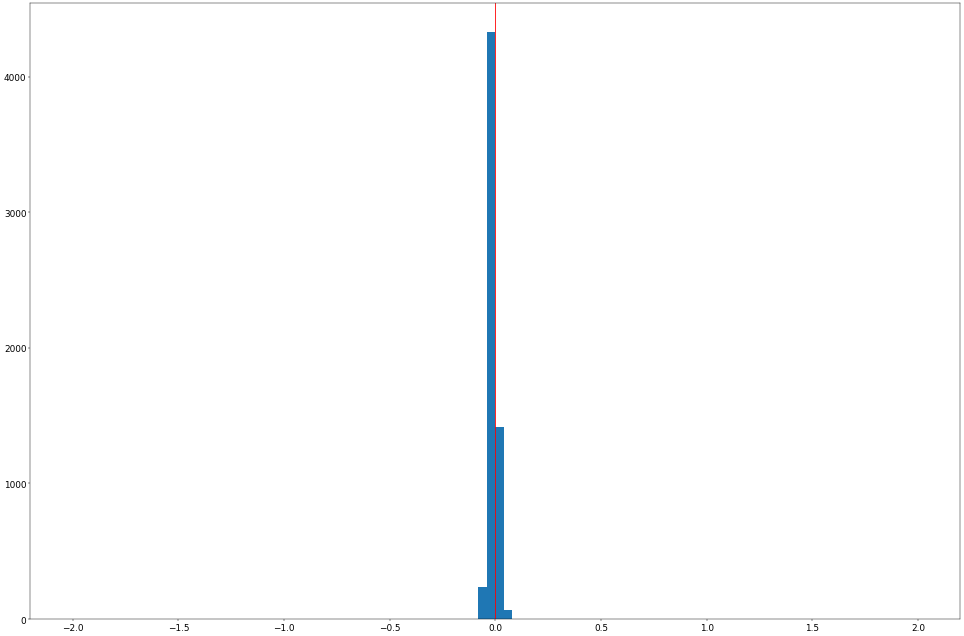

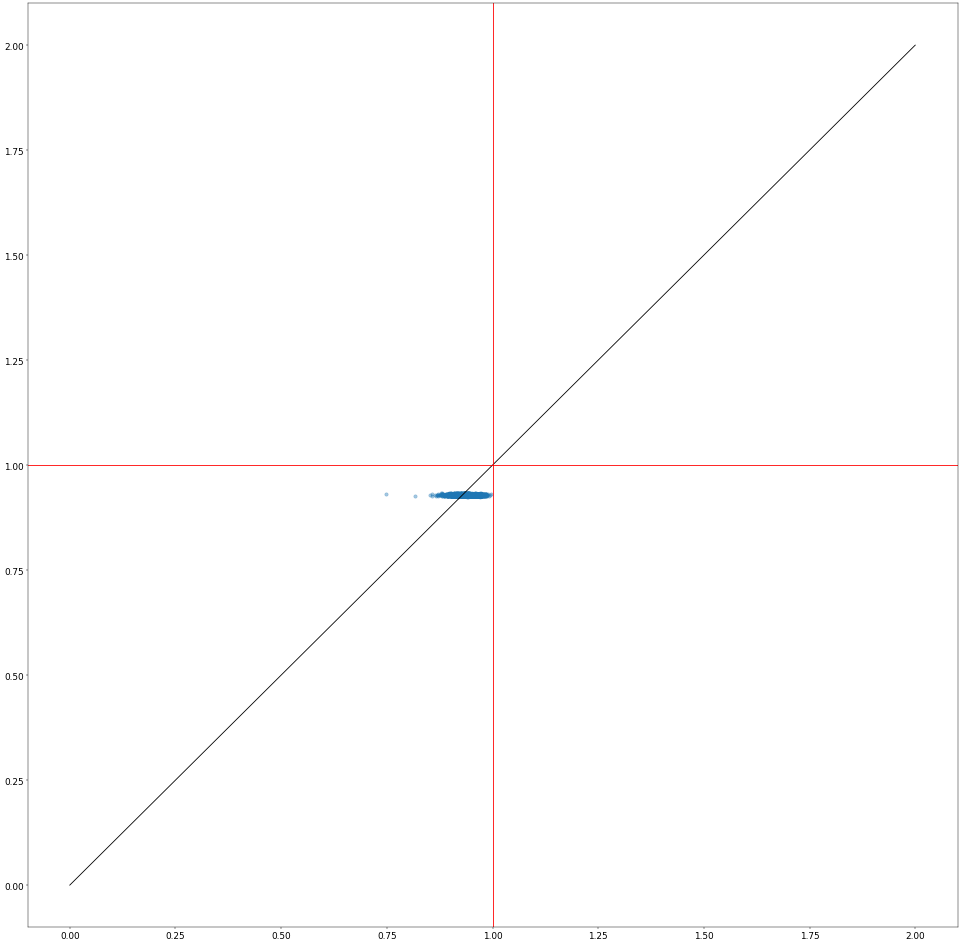

new best test loss: 1.01668511257797
epoch: 23


100%|██████████| 121/121 [00:02<00:00, 43.26it/s]


batches for train: 121
train loss: 1.0297043126476697


100%|██████████| 61/61 [00:01<00:00, 55.12it/s]


batches for test: 61
test loss: 1.015858570083243
pred - true / true mean: -0.008992885
pred - true / true std: 0.018682867
mu,sig: -0.008992885 0.018682867


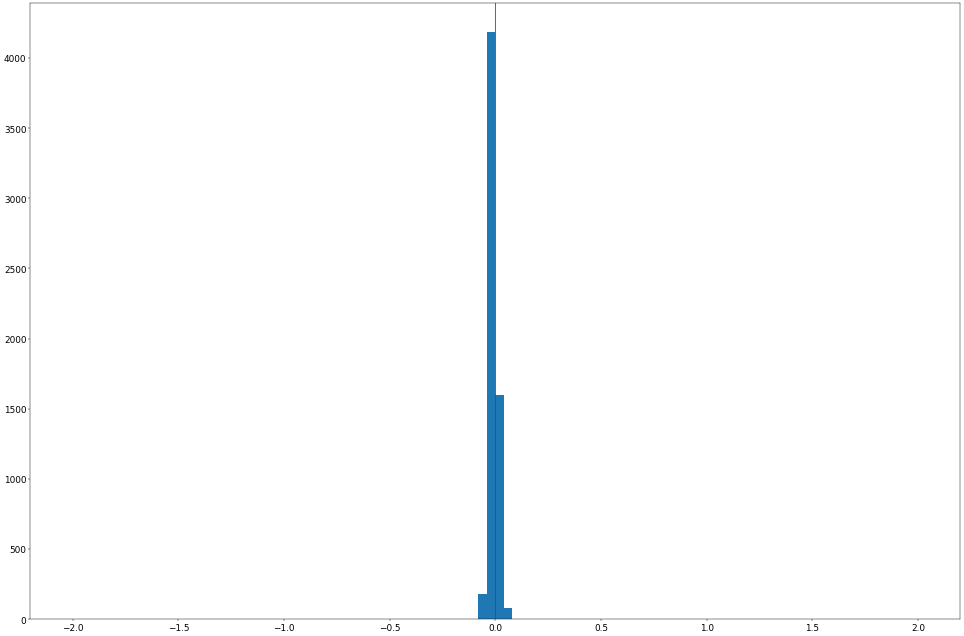

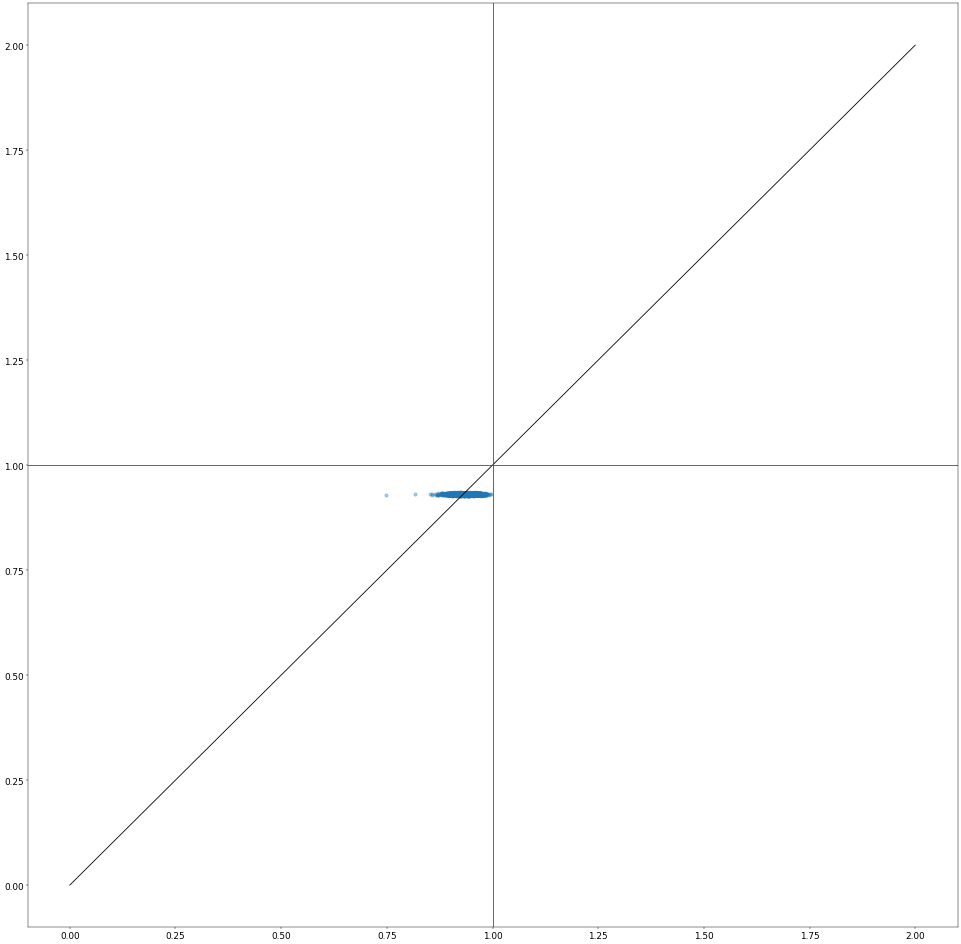

new best test loss: 1.015858570083243
epoch: 24


100%|██████████| 121/121 [00:03<00:00, 32.90it/s]


batches for train: 121
train loss: 1.027308733010095


100%|██████████| 61/61 [00:01<00:00, 55.52it/s]


batches for test: 61
test loss: 1.0150680053429526
pred - true / true mean: -0.0071119
pred - true / true std: 0.018639758
mu,sig: -0.0071119 0.018639758


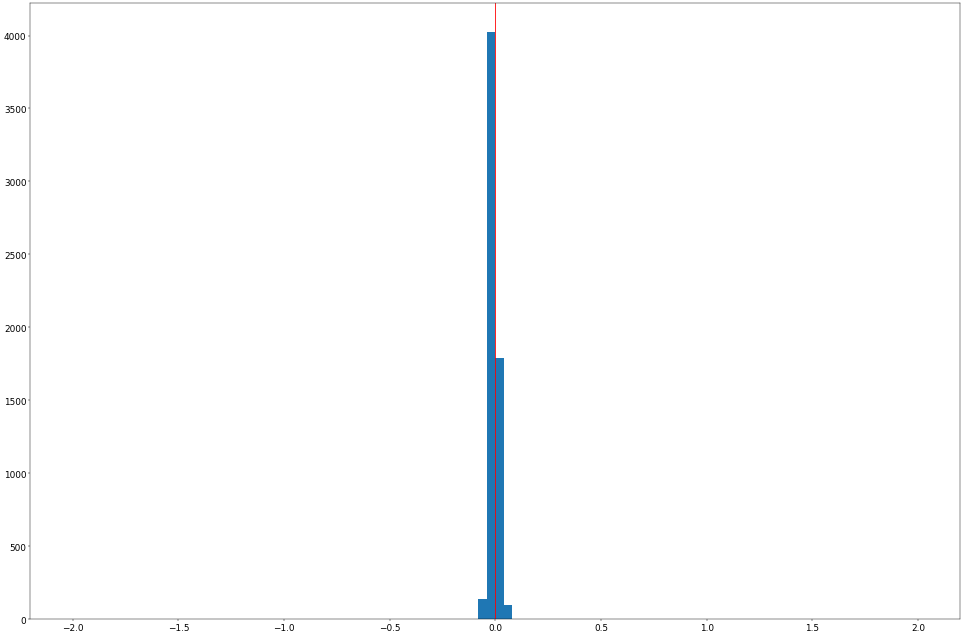

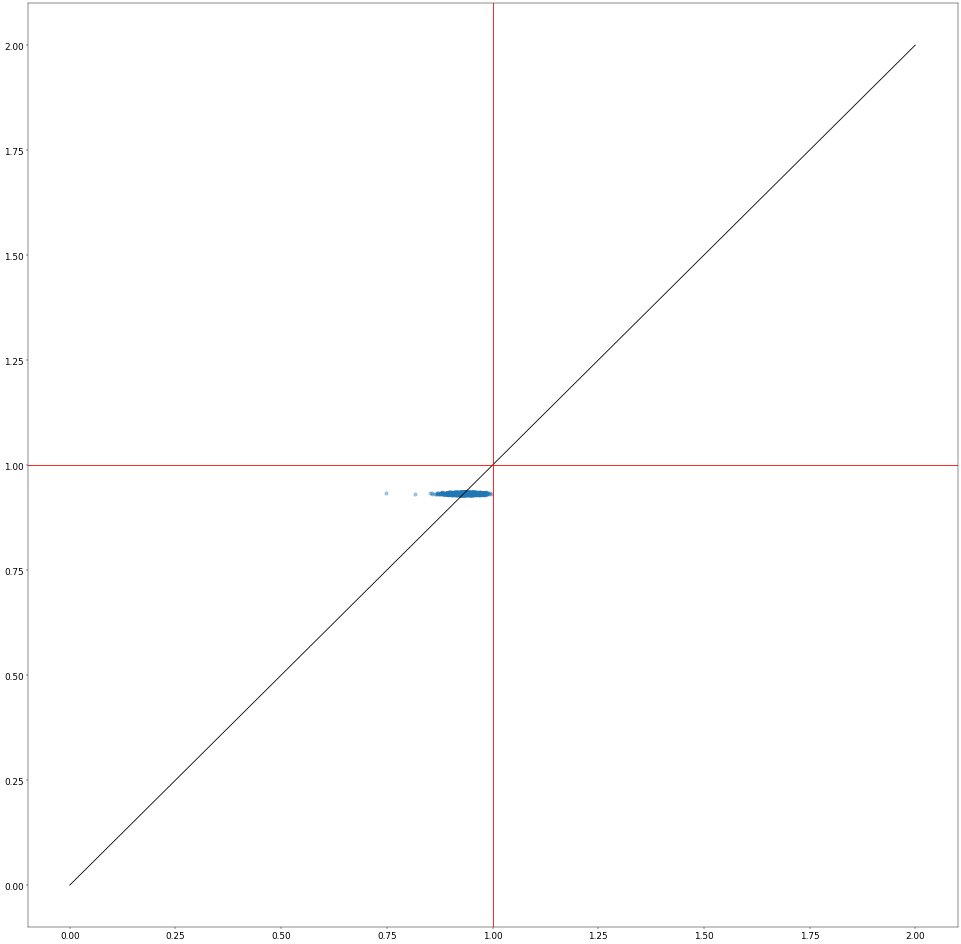

new best test loss: 1.0150680053429526
epoch: 25


100%|██████████| 121/121 [00:03<00:00, 32.95it/s]


batches for train: 121
train loss: 1.0248220026000472


100%|██████████| 61/61 [00:01<00:00, 46.09it/s]


batches for test: 61
test loss: 1.015280330767397
pred - true / true mean: -0.0077943765
pred - true / true std: 0.018580256
mu,sig: -0.0077943765 0.018580256


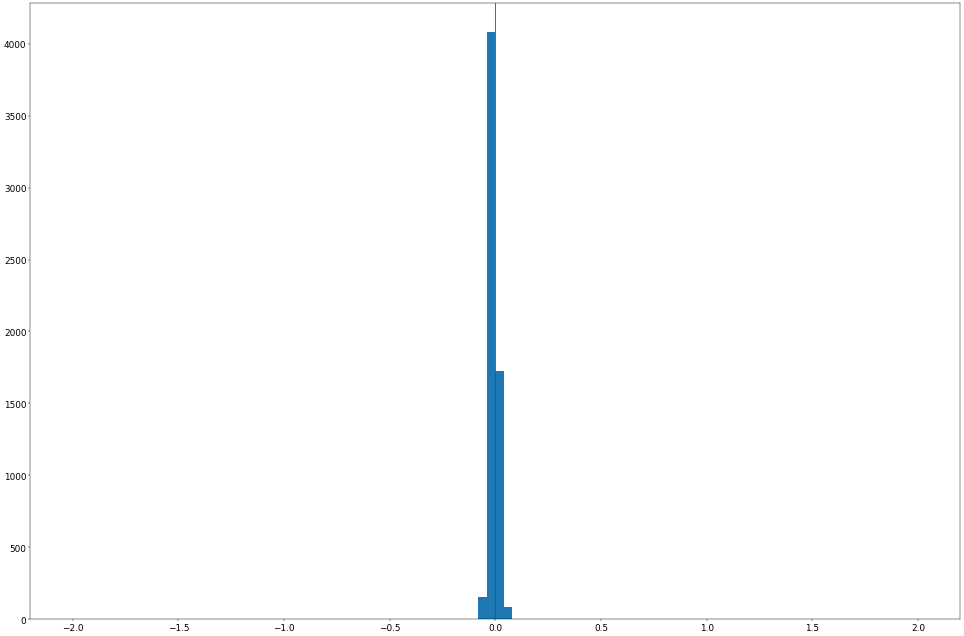

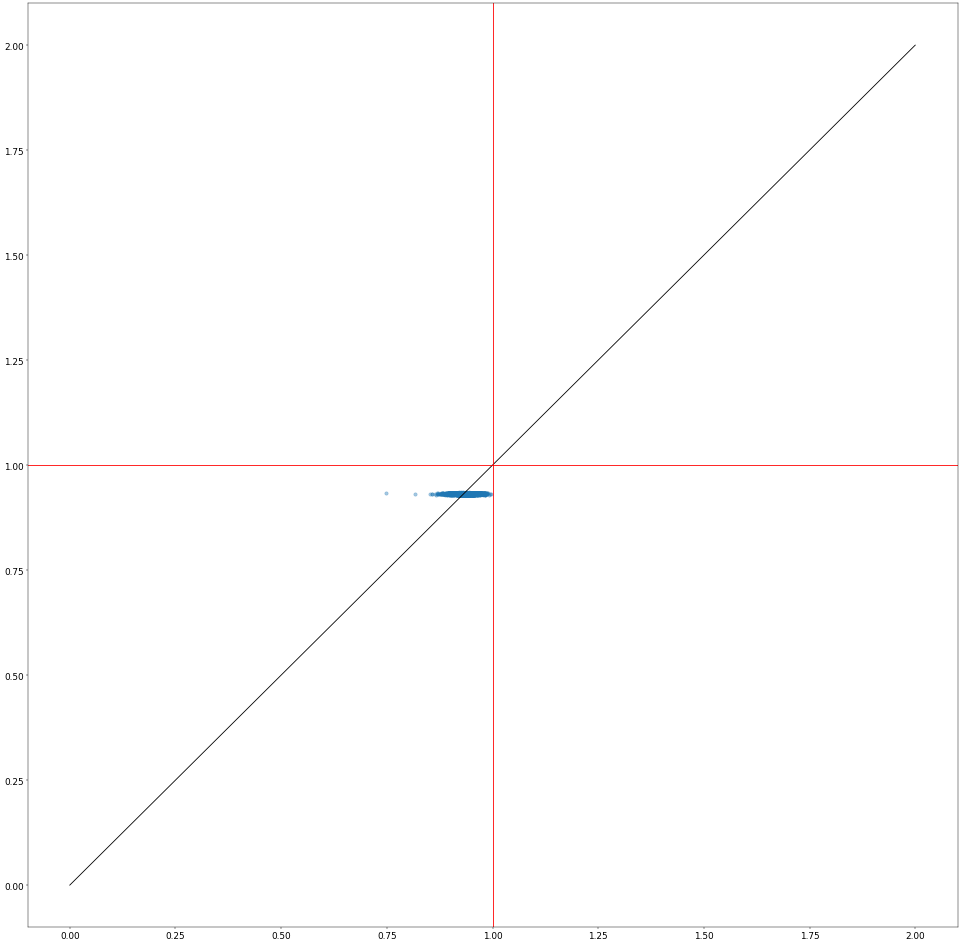

epoch: 26


100%|██████████| 121/121 [00:03<00:00, 39.62it/s]


batches for train: 121
train loss: 1.0225928982427297


100%|██████████| 61/61 [00:01<00:00, 54.52it/s]


batches for test: 61
test loss: 1.0144456116879572
pred - true / true mean: -0.005526679
pred - true / true std: 0.018518949
mu,sig: -0.005526679 0.018518949


<Figure size 640x480 with 0 Axes>

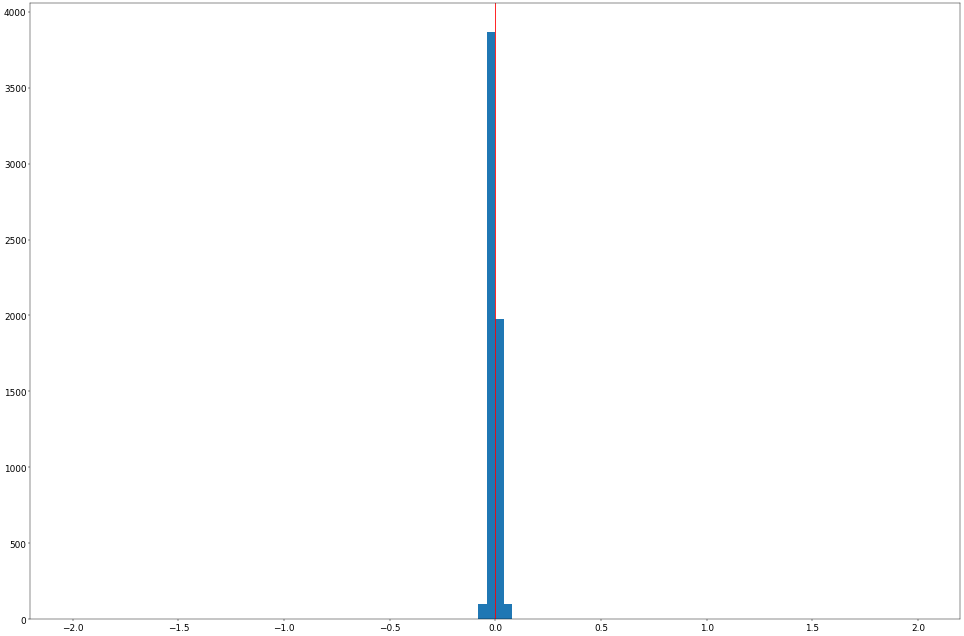

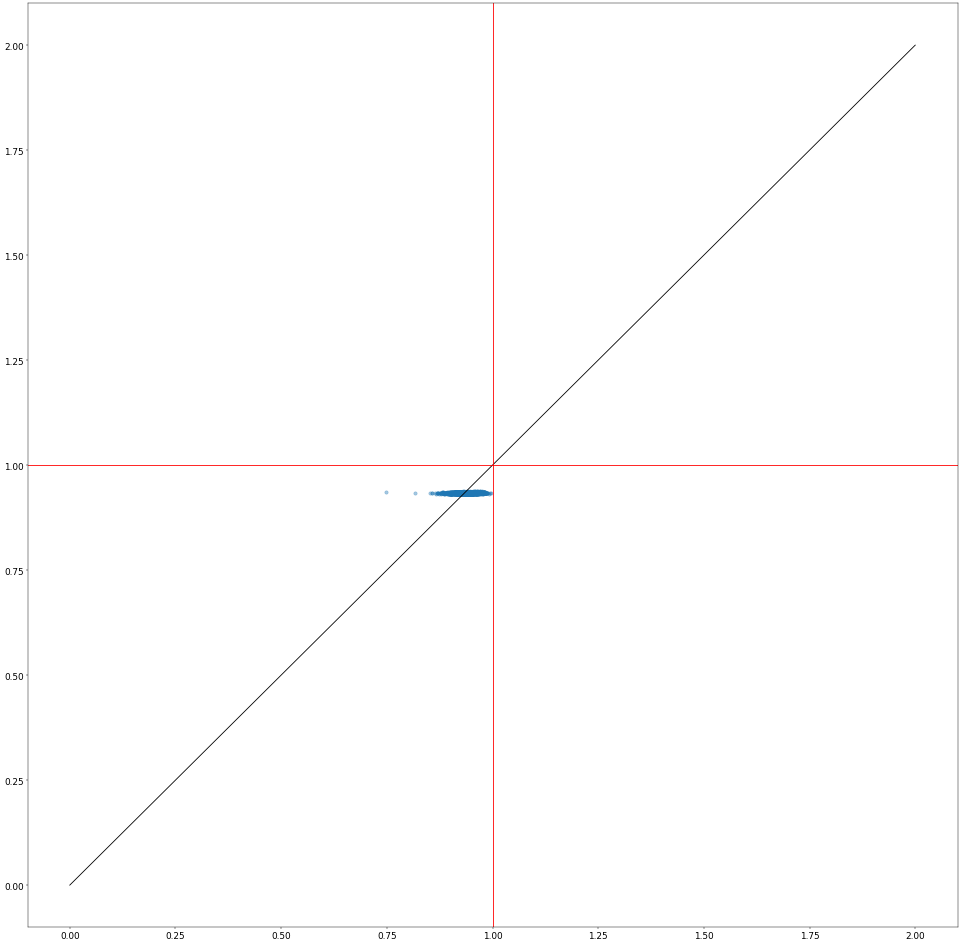

new best test loss: 1.0144456116879572
epoch: 27


100%|██████████| 121/121 [00:02<00:00, 43.31it/s]


batches for train: 121
train loss: 1.0206850836099672


100%|██████████| 61/61 [00:01<00:00, 55.51it/s]


batches for test: 61
test loss: 1.0144783023928032
pred - true / true mean: -0.0057716407
pred - true / true std: 0.018460795
mu,sig: -0.0057716407 0.018460795


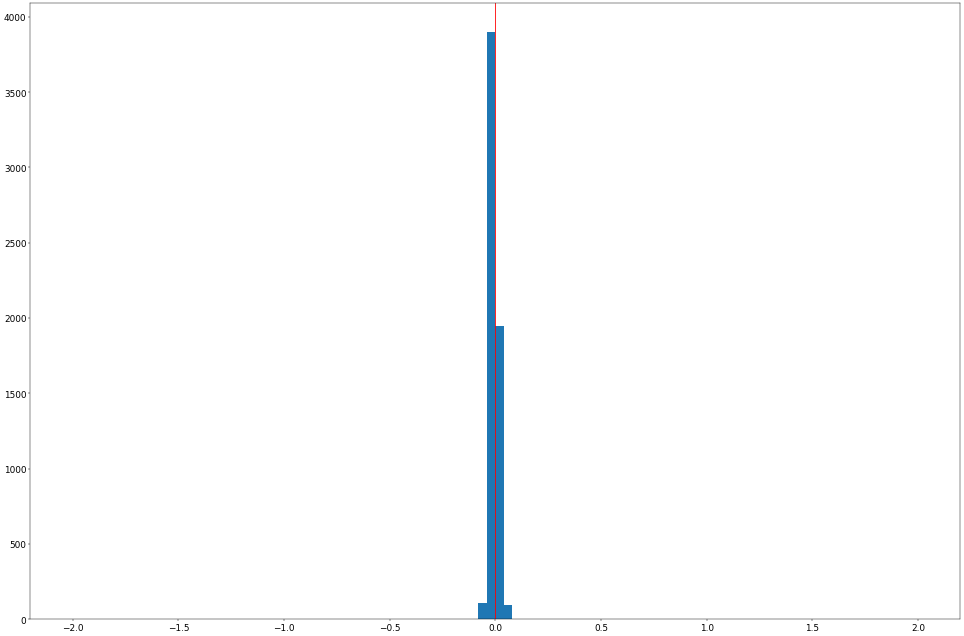

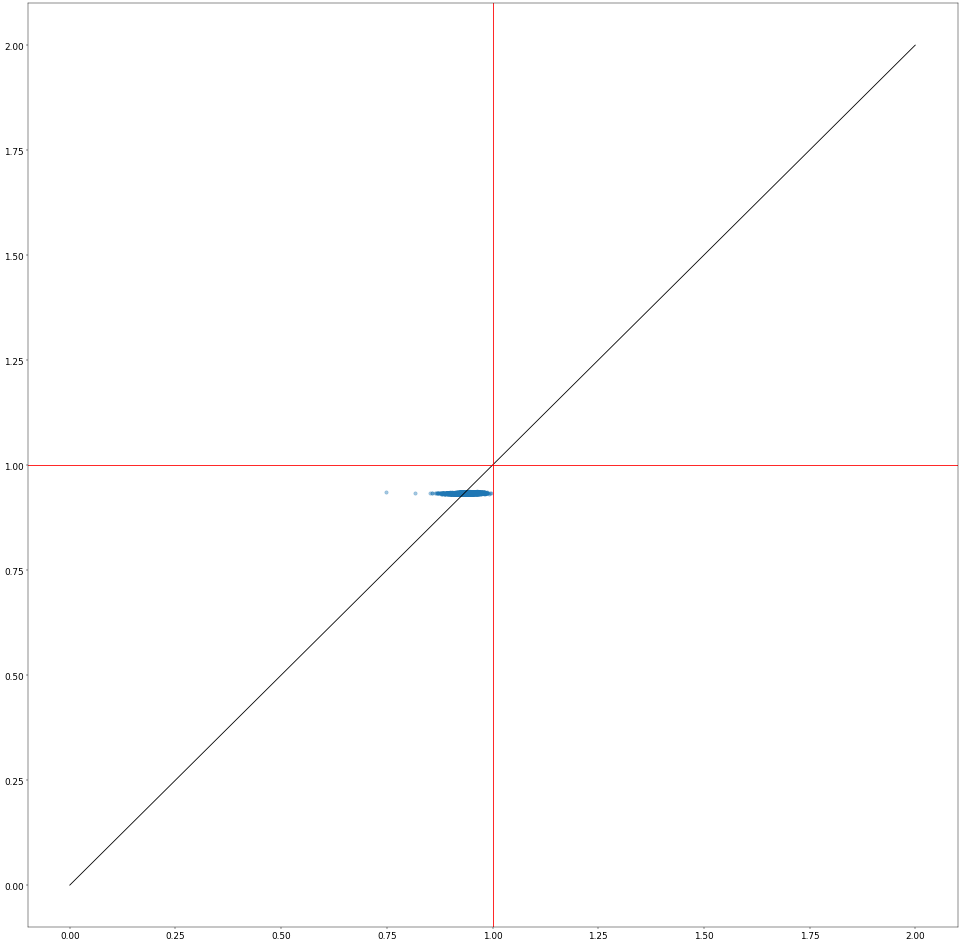

epoch: 28


100%|██████████| 121/121 [00:02<00:00, 43.65it/s]


batches for train: 121
train loss: 1.0193737085200538


100%|██████████| 61/61 [00:01<00:00, 55.48it/s]


batches for test: 61
test loss: 1.0142111172441577
pred - true / true mean: -0.004783843
pred - true / true std: 0.018492693
mu,sig: -0.004783843 0.018492693


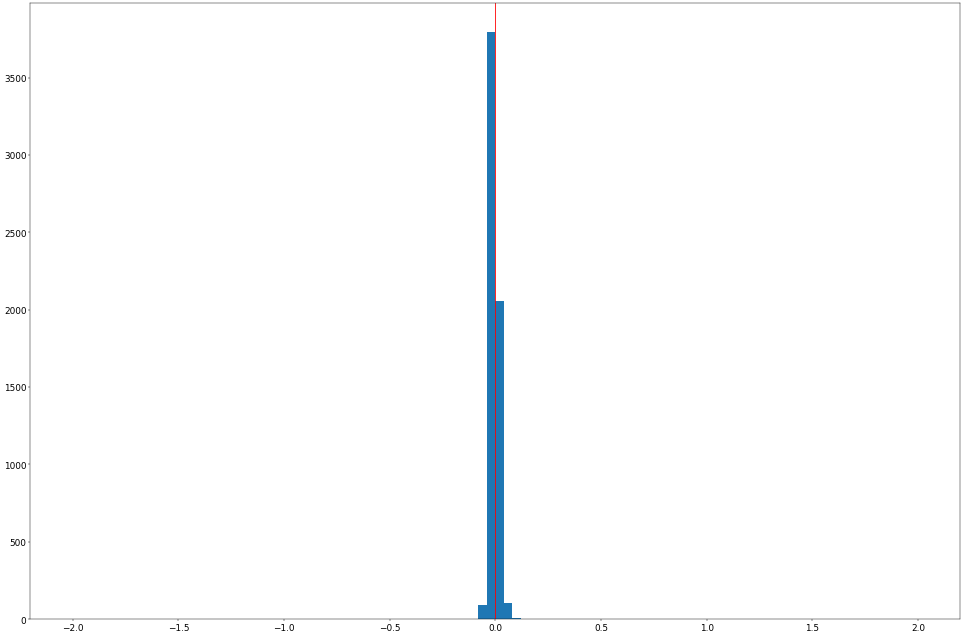

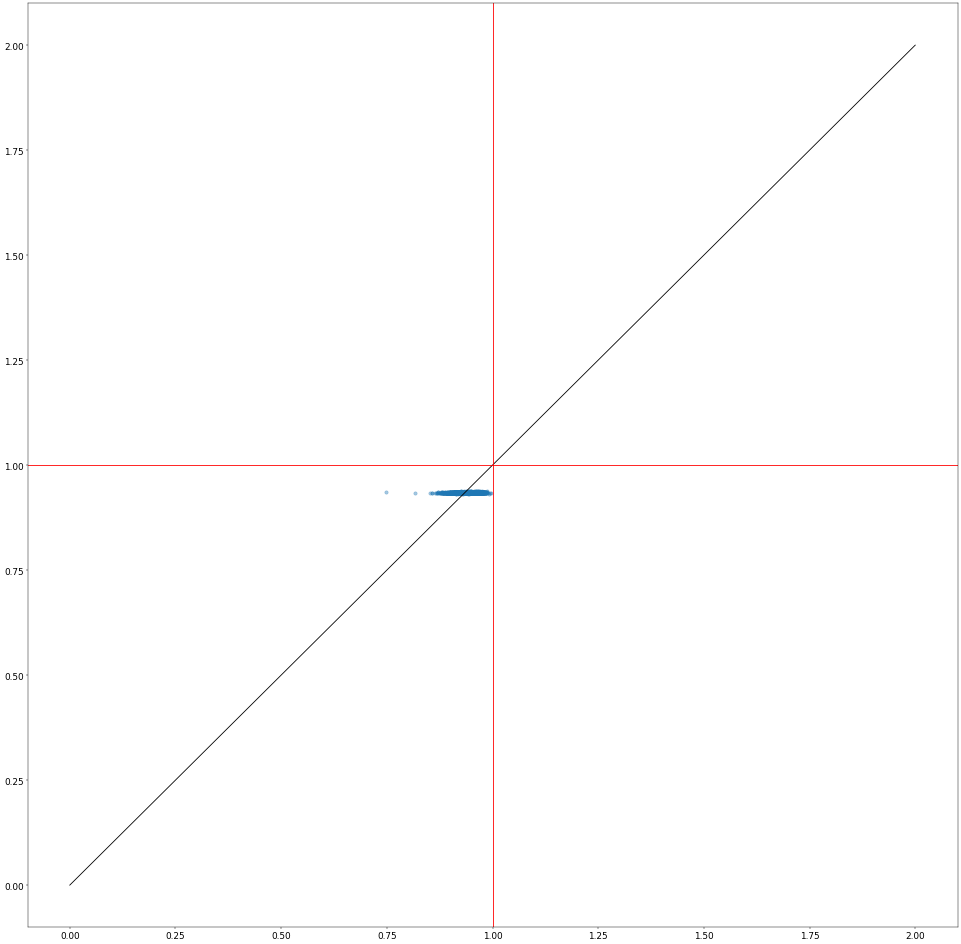

new best test loss: 1.0142111172441577
epoch: 29


100%|██████████| 121/121 [00:02<00:00, 43.66it/s]


batches for train: 121
train loss: 1.0179414079209004


100%|██████████| 61/61 [00:01<00:00, 46.75it/s]


batches for test: 61
test loss: 1.0138873194084792
pred - true / true mean: -0.0035646665
pred - true / true std: 0.018479388
mu,sig: -0.0035646665 0.018479388


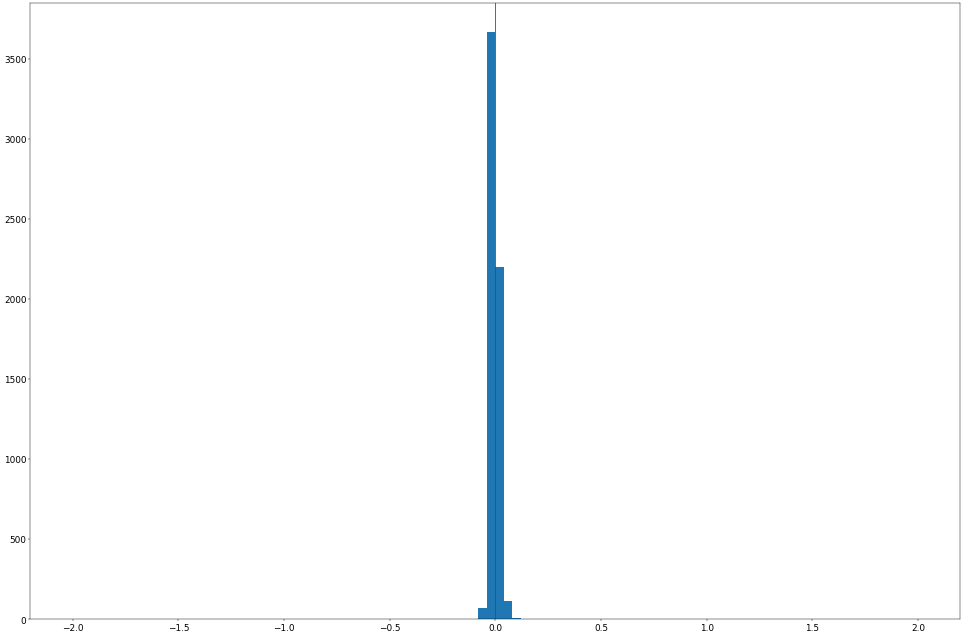

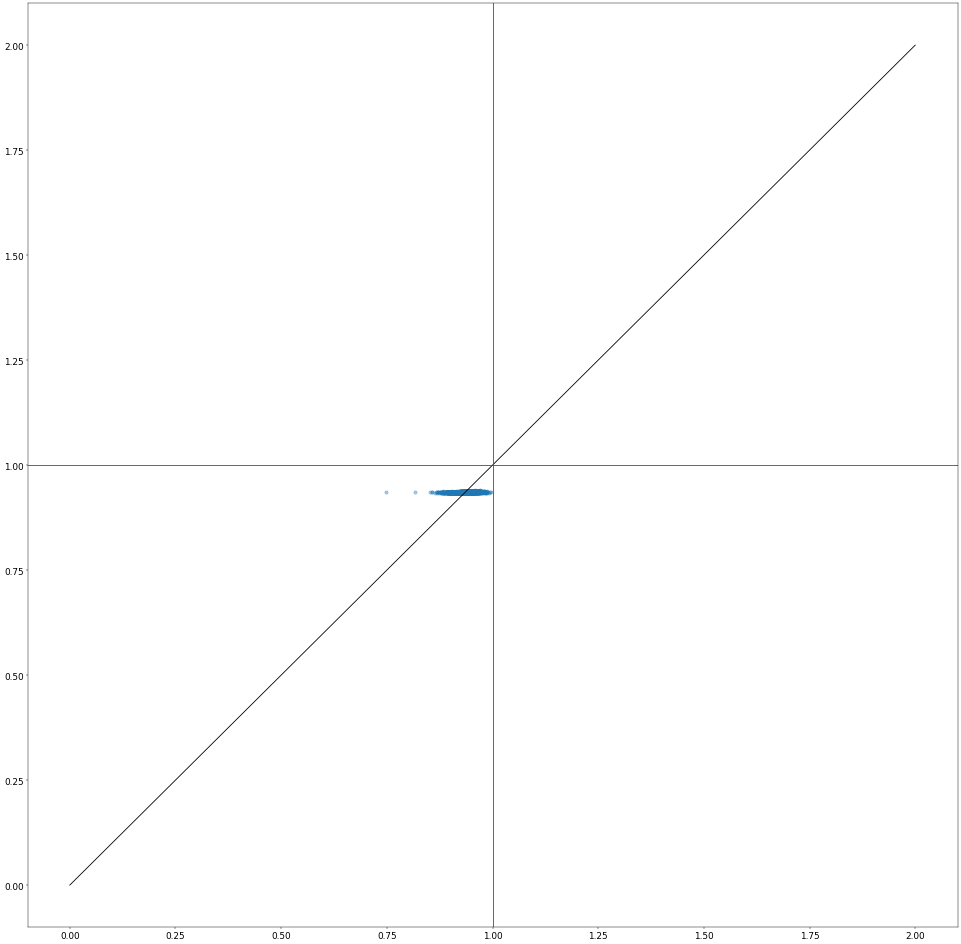

new best test loss: 1.0138873194084792


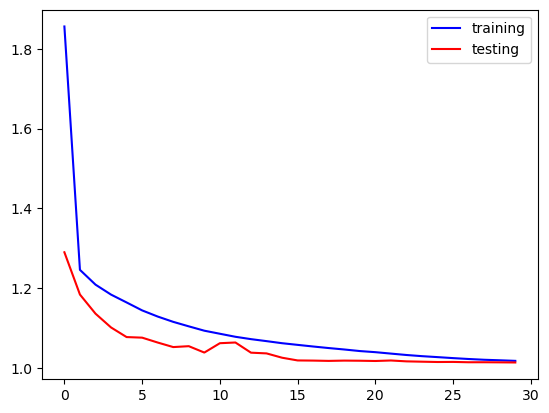

epoch: 30


100%|██████████| 121/121 [00:03<00:00, 40.24it/s]


batches for train: 121
train loss: 1.0169083333212483


100%|██████████| 61/61 [00:01<00:00, 53.37it/s]


batches for test: 61
test loss: 1.014998480921886
pred - true / true mean: -0.007373931
pred - true / true std: 0.018395936
mu,sig: -0.007373931 0.018395936


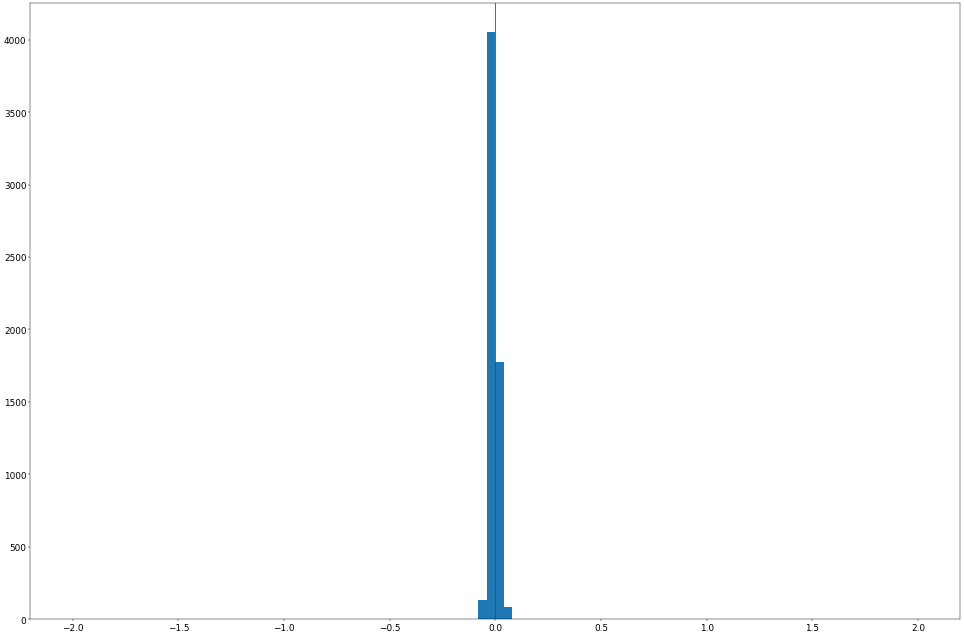

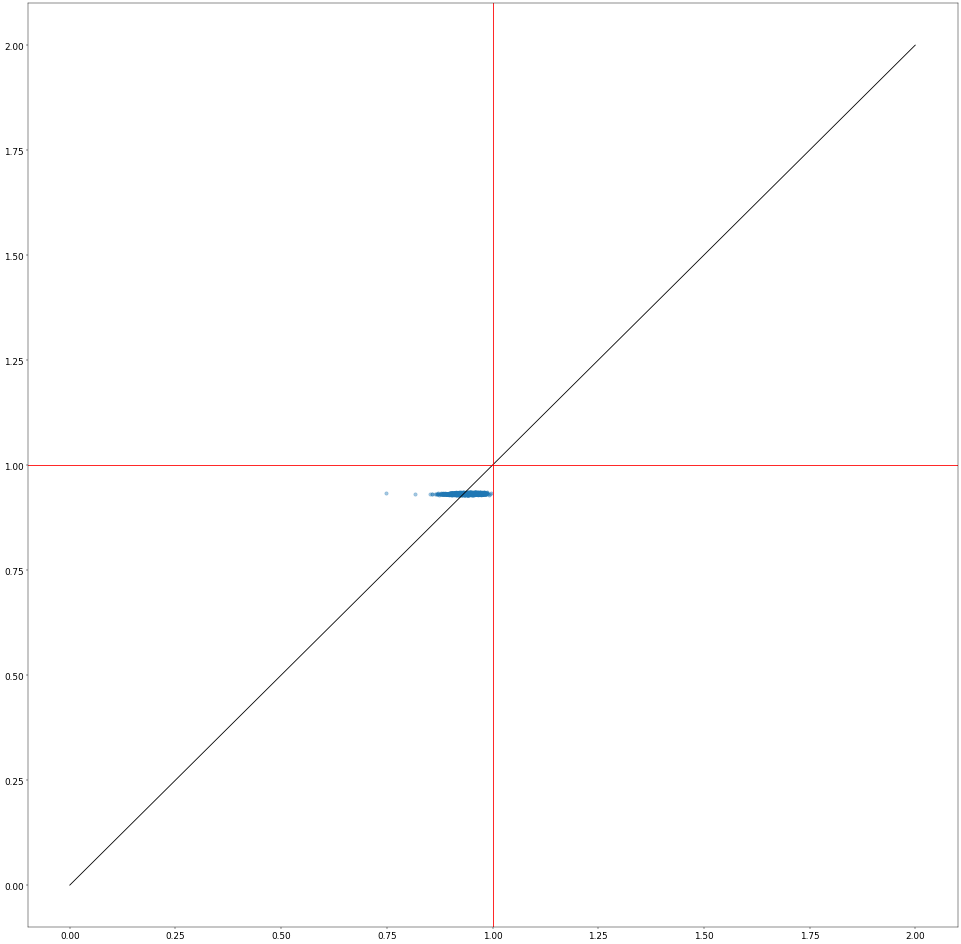

epoch: 31


100%|██████████| 121/121 [00:02<00:00, 42.82it/s]


batches for train: 121
train loss: 1.0161332335353883


100%|██████████| 61/61 [00:01<00:00, 50.29it/s]


batches for test: 61
test loss: 1.0144599207112046
pred - true / true mean: -0.0059266733
pred - true / true std: 0.018367805
mu,sig: -0.0059266733 0.018367805


<Figure size 640x480 with 0 Axes>

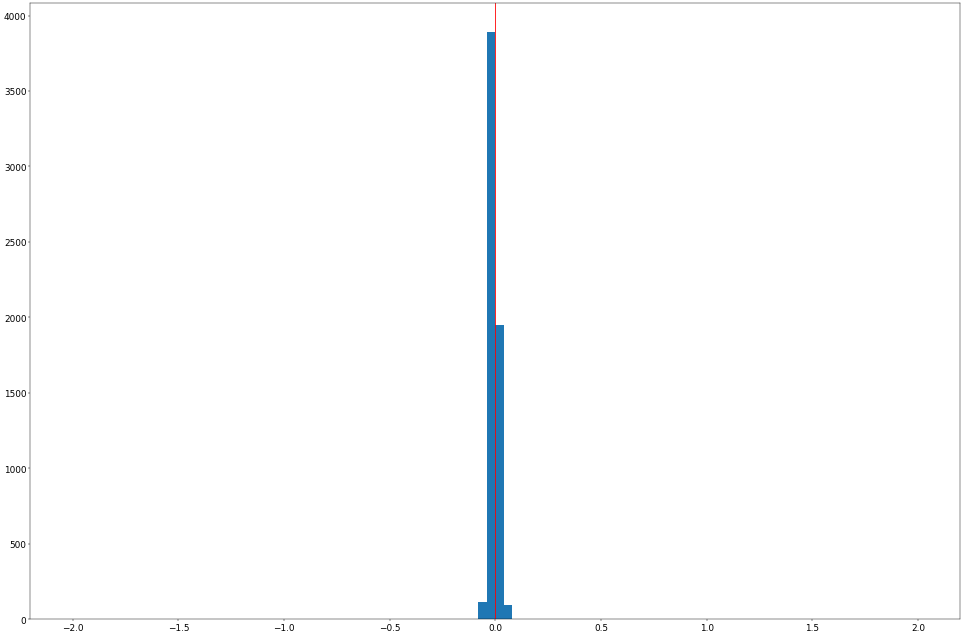

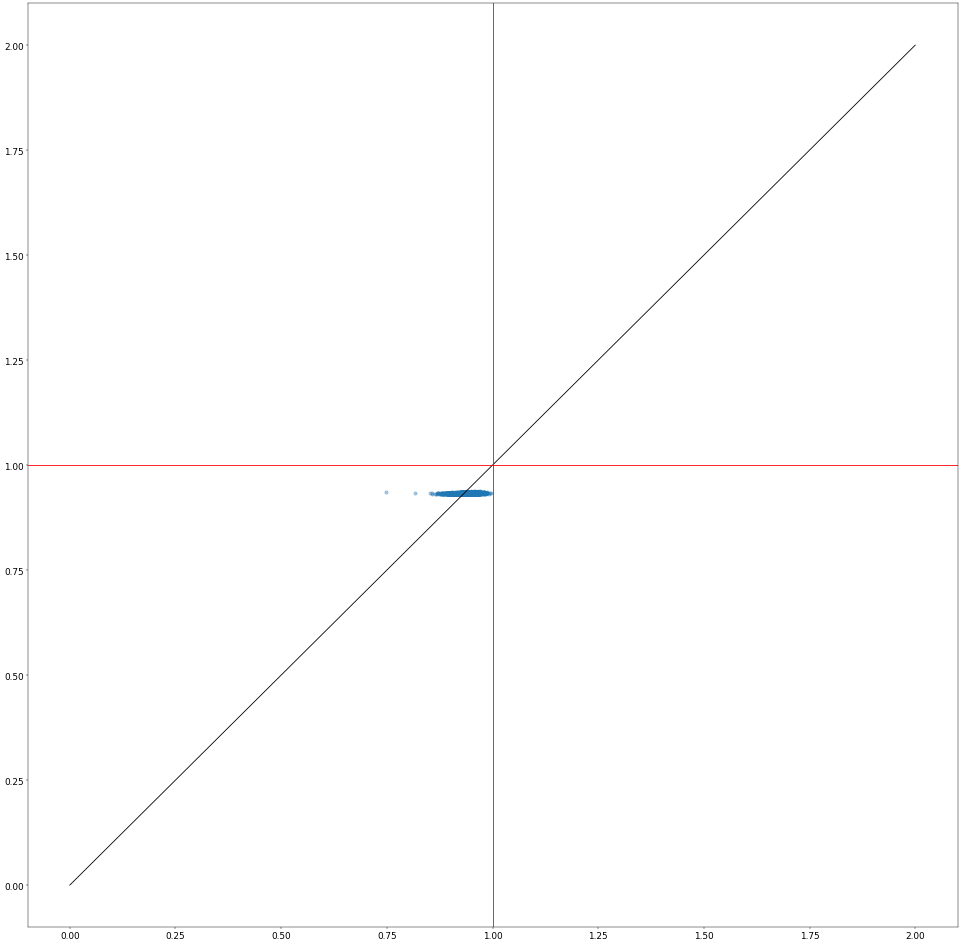

epoch: 32


100%|██████████| 121/121 [00:03<00:00, 32.46it/s]


batches for train: 121
train loss: 1.0154795006286998


100%|██████████| 61/61 [00:01<00:00, 44.96it/s]


batches for test: 61
test loss: 1.0149077352930287
pred - true / true mean: -0.0073054996
pred - true / true std: 0.0183182
mu,sig: -0.0073054996 0.0183182


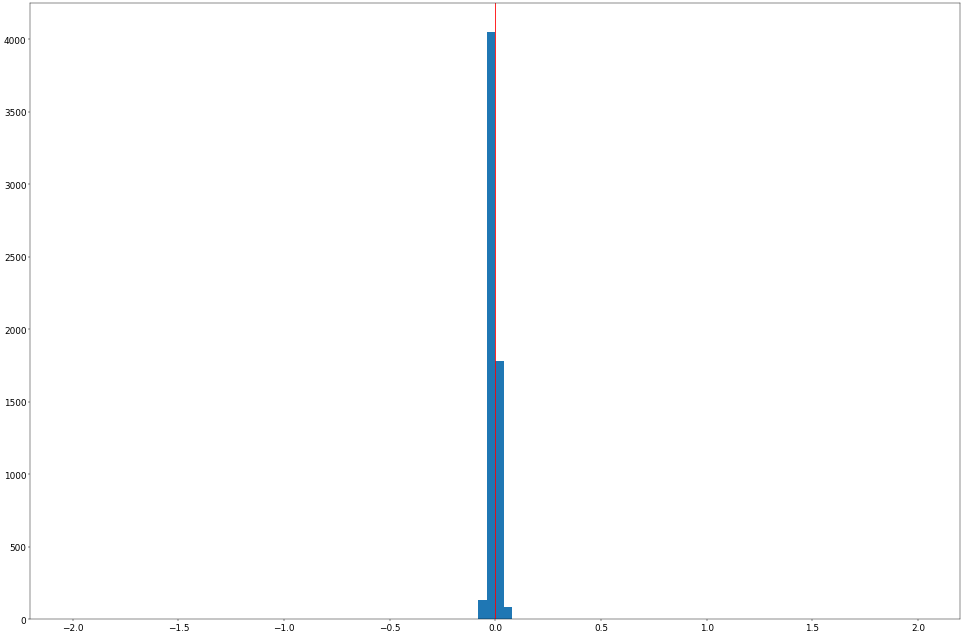

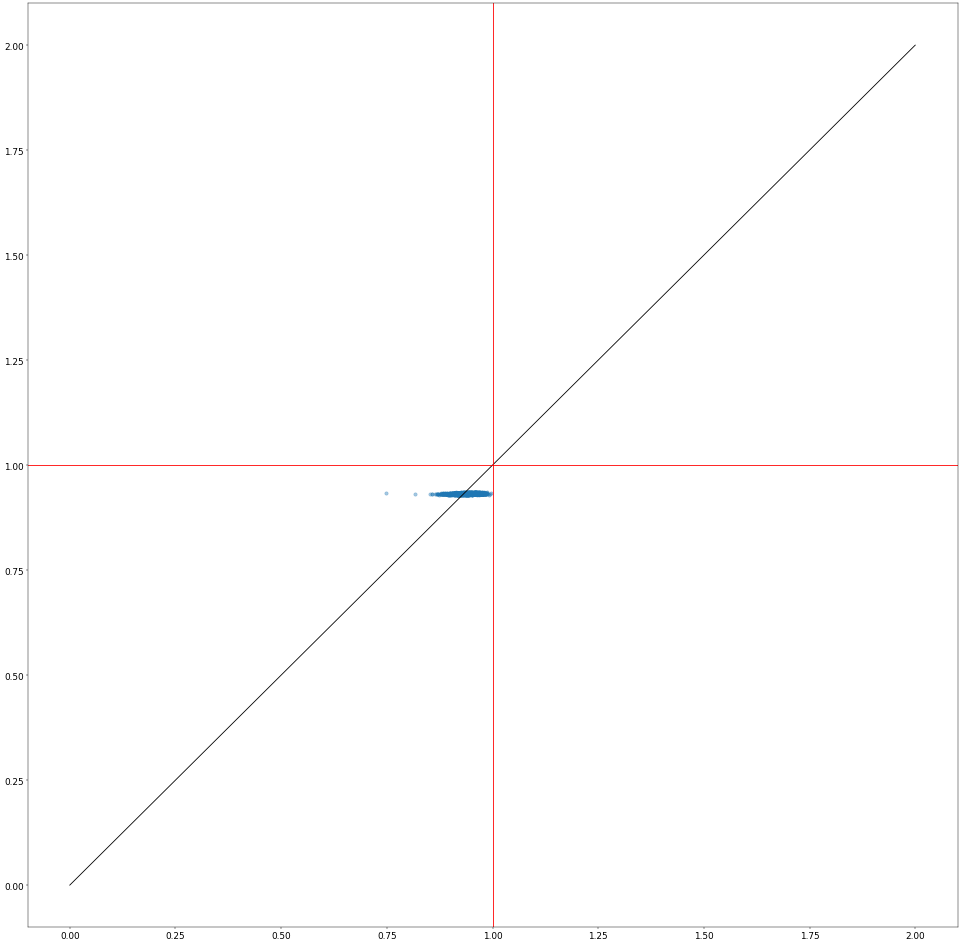

epoch: 33


100%|██████████| 121/121 [00:02<00:00, 42.52it/s]


batches for train: 121
train loss: 1.0151585803544225


100%|██████████| 61/61 [00:01<00:00, 54.87it/s]


batches for test: 61
test loss: 1.0143502559818205
pred - true / true mean: -0.0059188874
pred - true / true std: 0.018232996
mu,sig: -0.0059188874 0.018232996


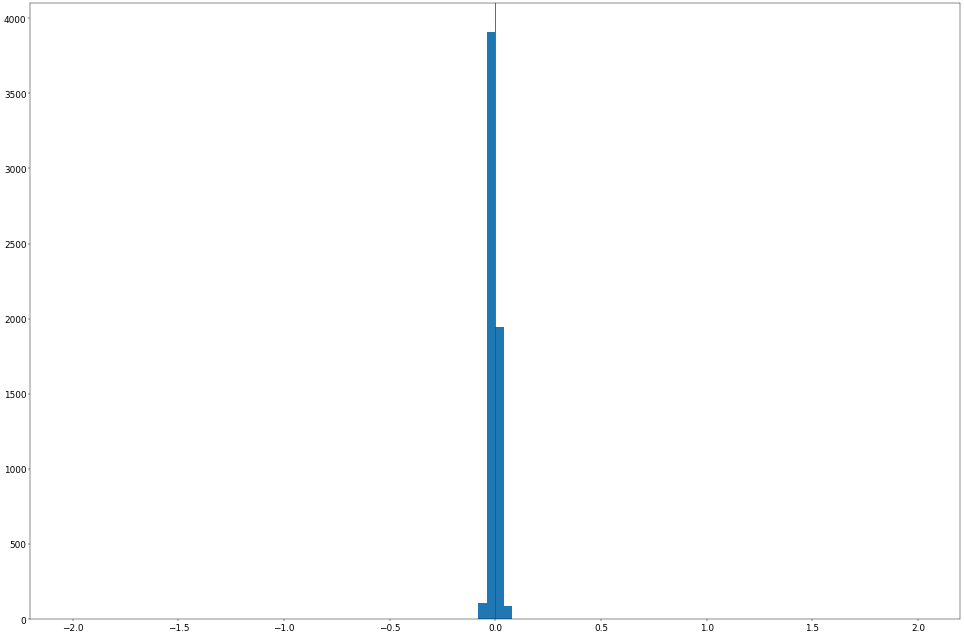

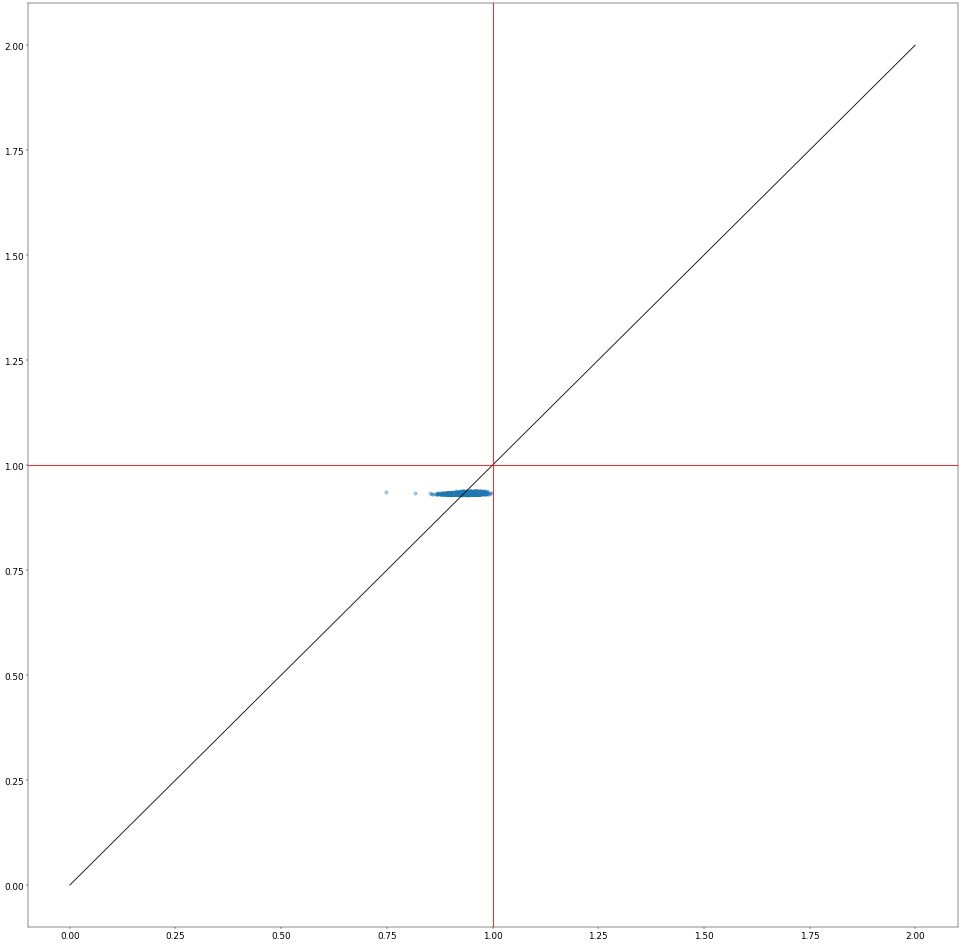

epoch: 34


100%|██████████| 121/121 [00:02<00:00, 42.98it/s]


batches for train: 121
train loss: 1.0147606873315227


100%|██████████| 61/61 [00:01<00:00, 42.71it/s]


batches for test: 61
test loss: 1.0145425933306333
pred - true / true mean: -0.0066760336
pred - true / true std: 0.018149683
mu,sig: -0.0066760336 0.018149683


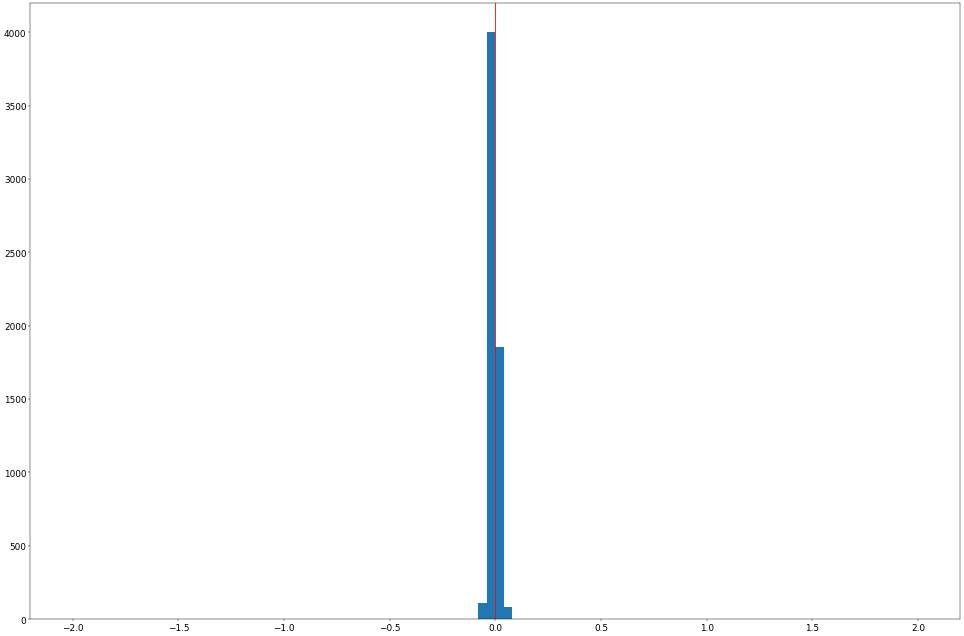

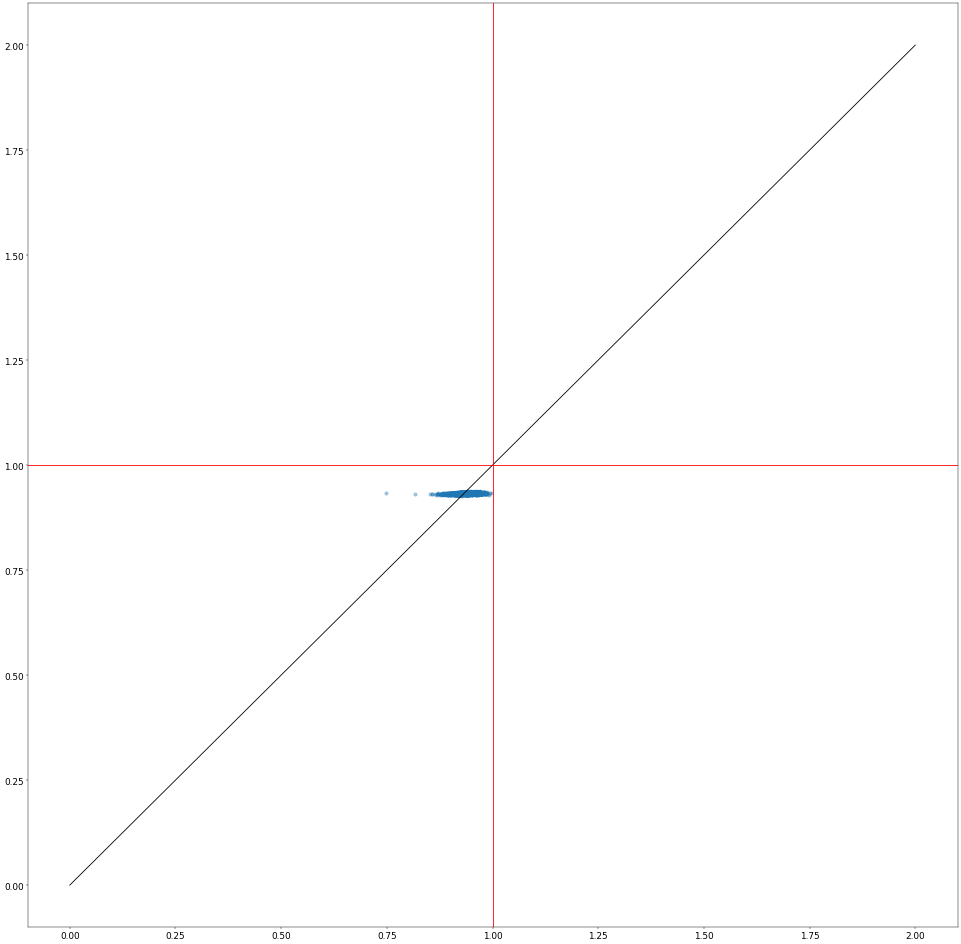

epoch: 35


100%|██████████| 121/121 [00:02<00:00, 43.33it/s]


batches for train: 121
train loss: 1.0145061232826926


100%|██████████| 61/61 [00:01<00:00, 52.83it/s]


batches for test: 61
test loss: 1.013574119474067
pred - true / true mean: -0.0036135218
pred - true / true std: 0.018057363
mu,sig: -0.0036135218 0.018057363


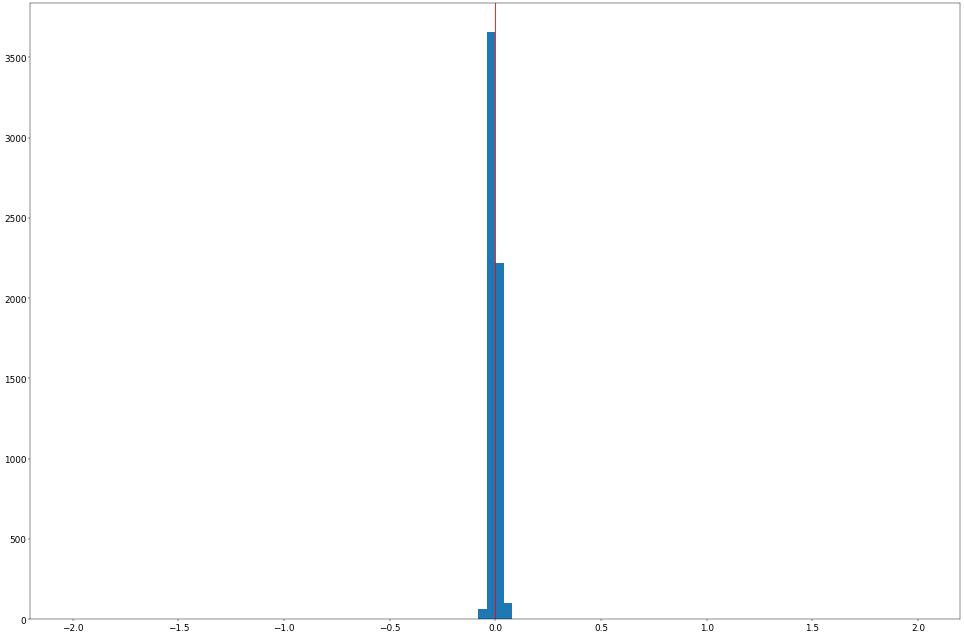

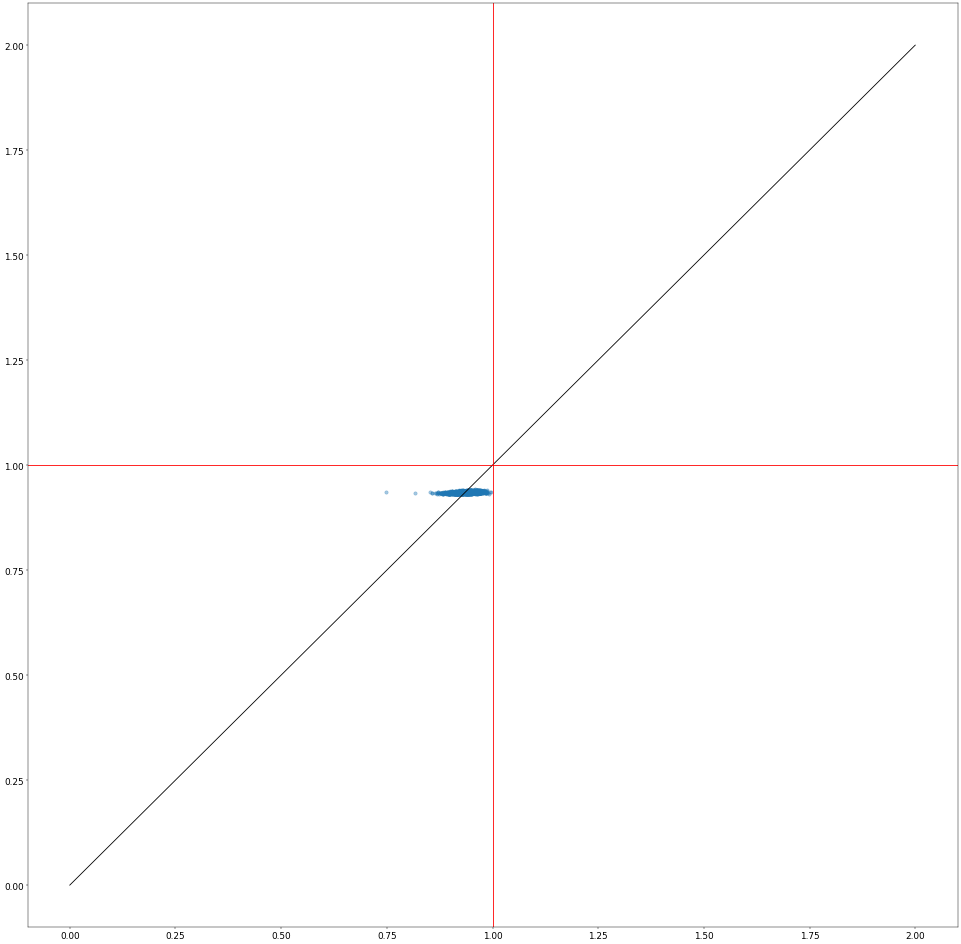

new best test loss: 1.013574119474067
epoch: 36


100%|██████████| 121/121 [00:03<00:00, 33.75it/s]


batches for train: 121
train loss: 1.0142530606797904


100%|██████████| 61/61 [00:01<00:00, 45.94it/s]


batches for test: 61
test loss: 1.014786808217158
pred - true / true mean: -0.0078815
pred - true / true std: 0.017871281
mu,sig: -0.0078815 0.017871281


<Figure size 640x480 with 0 Axes>

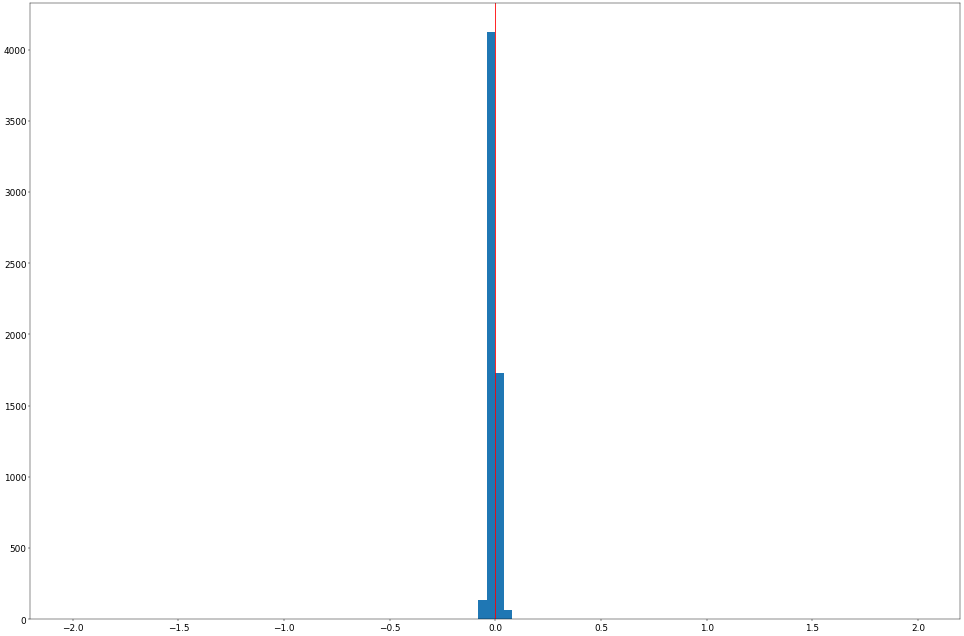

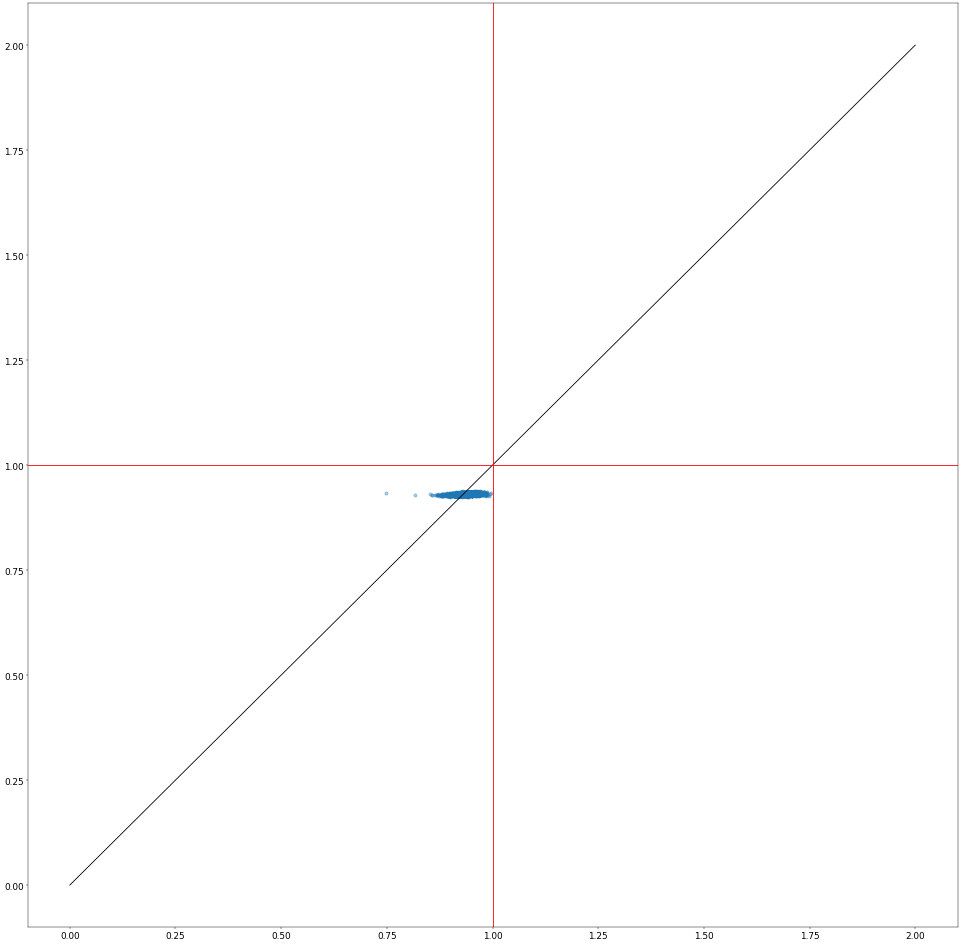

epoch: 37


100%|██████████| 121/121 [00:03<00:00, 34.25it/s]


batches for train: 121
train loss: 1.014154637155454


100%|██████████| 61/61 [00:01<00:00, 45.18it/s]


batches for test: 61
test loss: 1.0143553428962582
pred - true / true mean: -0.007099298
pred - true / true std: 0.017710935
mu,sig: -0.007099298 0.017710935


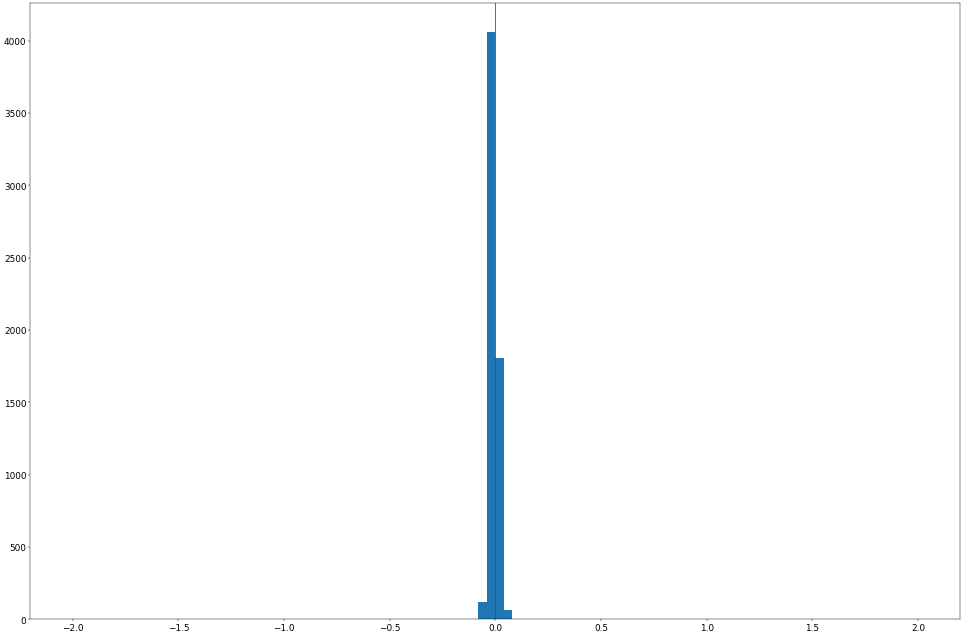

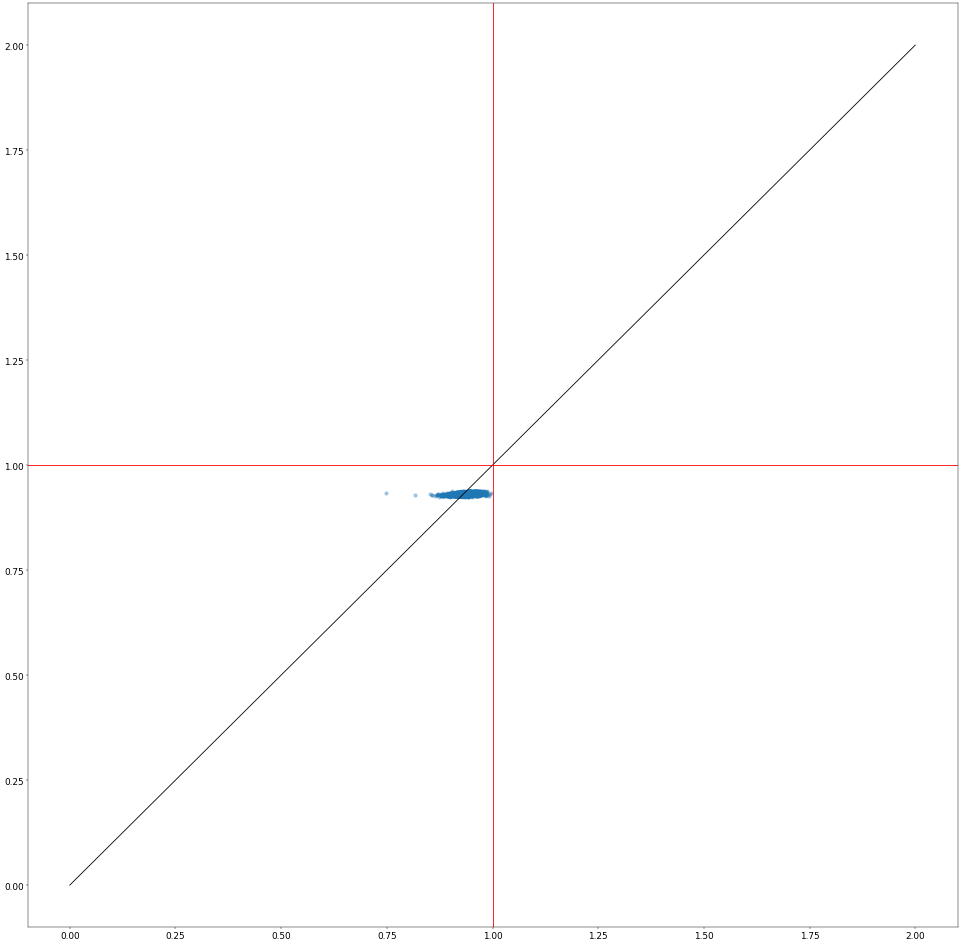

epoch: 38


100%|██████████| 121/121 [00:02<00:00, 42.93it/s]


batches for train: 121
train loss: 1.0139099664924558


100%|██████████| 61/61 [00:01<00:00, 45.18it/s]


batches for test: 61
test loss: 1.0141235707236118
pred - true / true mean: -0.0066382373
pred - true / true std: 0.01763
mu,sig: -0.0066382373 0.01763


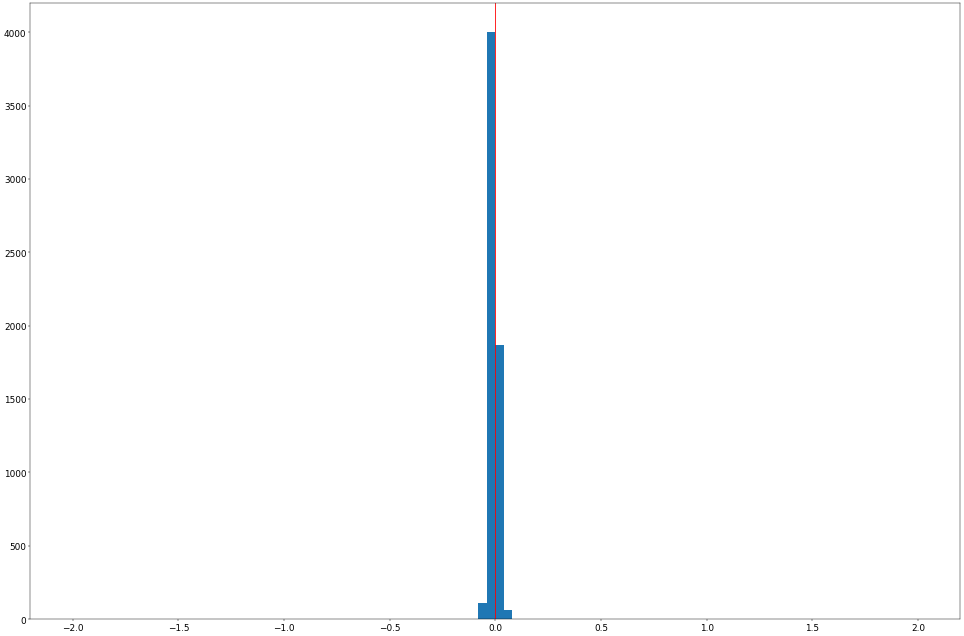

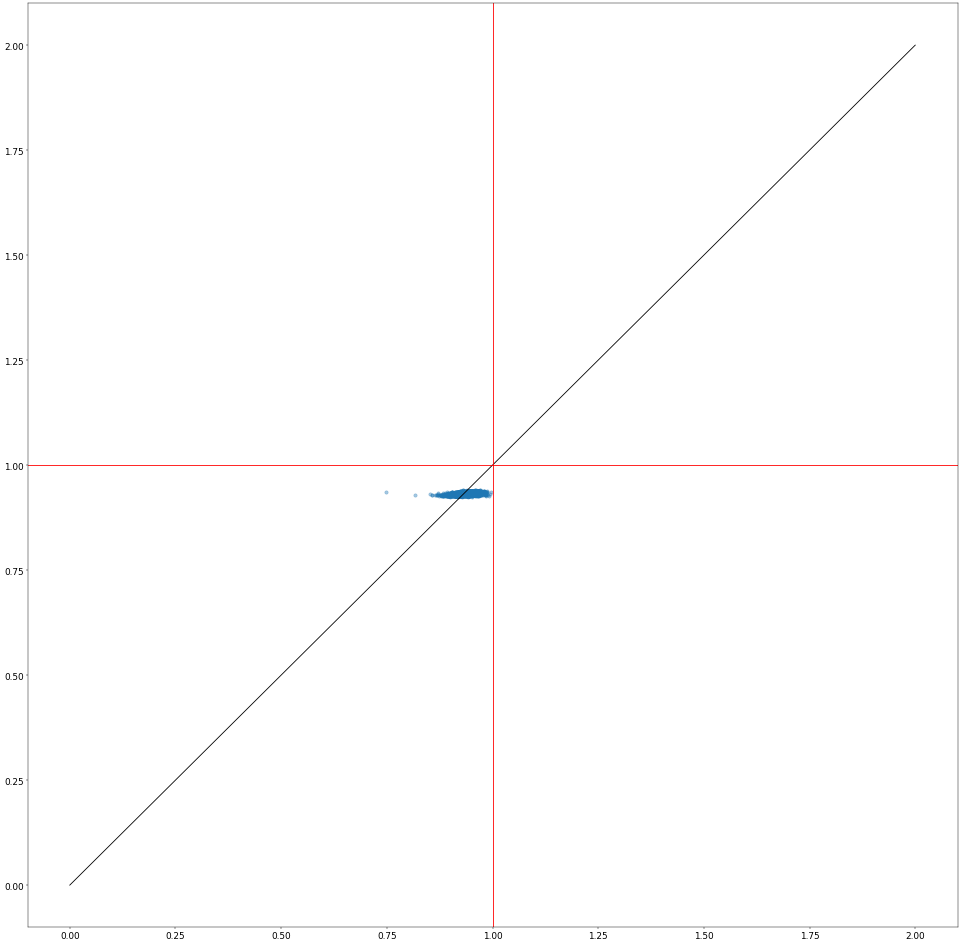

epoch: 39


100%|██████████| 121/121 [00:02<00:00, 42.59it/s]


batches for train: 121
train loss: 1.0137296333785886


100%|██████████| 61/61 [00:01<00:00, 42.91it/s]


batches for test: 61
test loss: 1.014469660696436
pred - true / true mean: -0.007807208
pred - true / true std: 0.017496346
mu,sig: -0.007807208 0.017496346


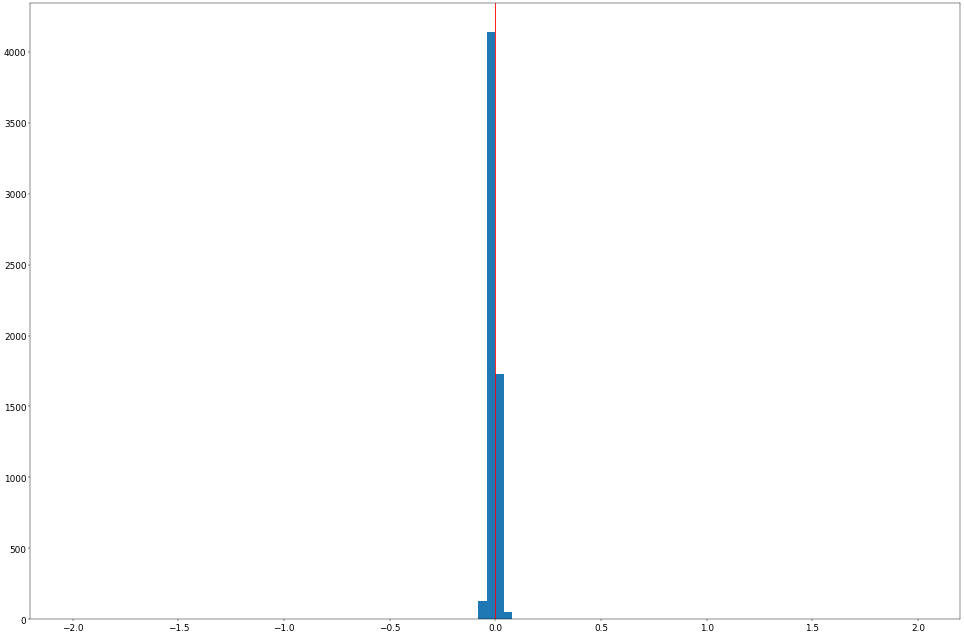

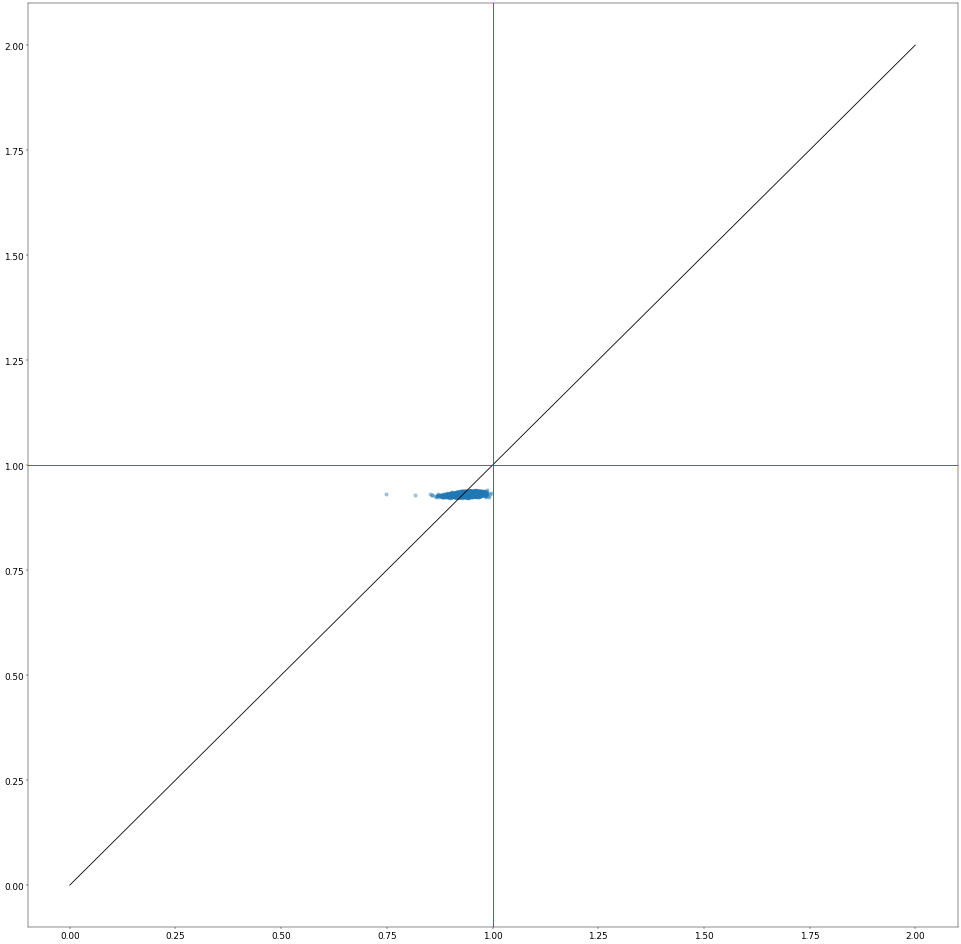

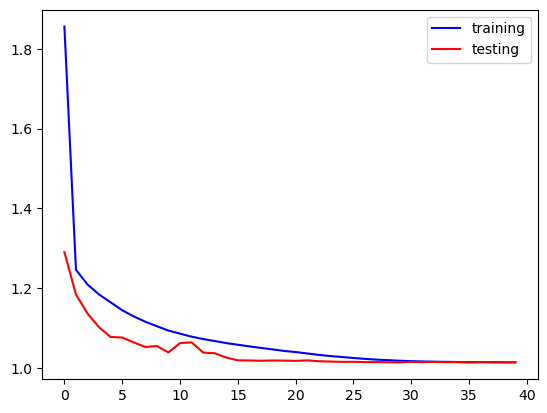

epoch: 40


100%|██████████| 121/121 [00:03<00:00, 33.74it/s]


batches for train: 121
train loss: 1.0136353664161746


100%|██████████| 61/61 [00:01<00:00, 45.72it/s]


batches for test: 61
test loss: 1.0147350186207256
pred - true / true mean: -0.008609468
pred - true / true std: 0.01741577
mu,sig: -0.008609468 0.01741577


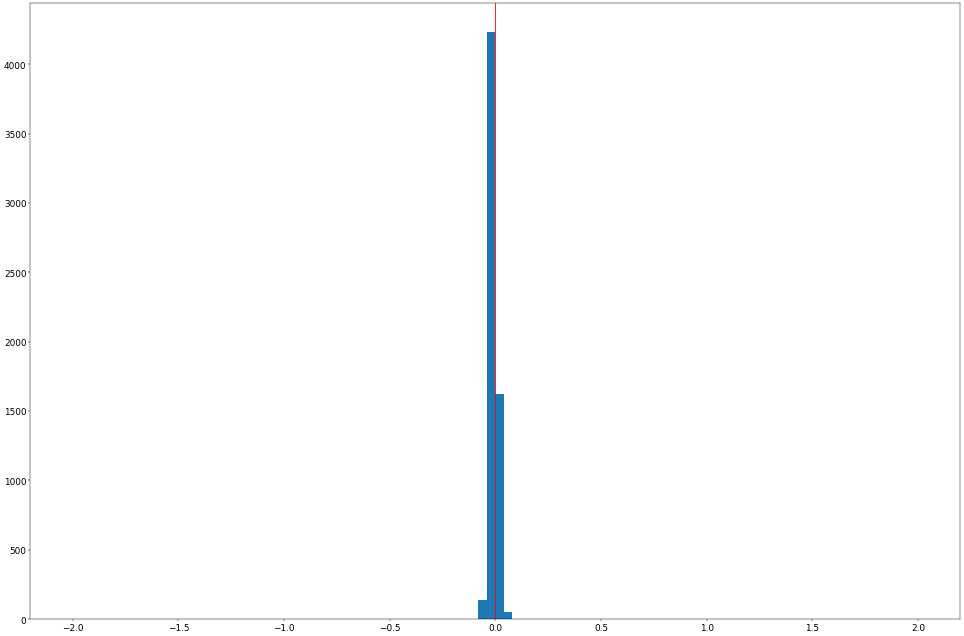

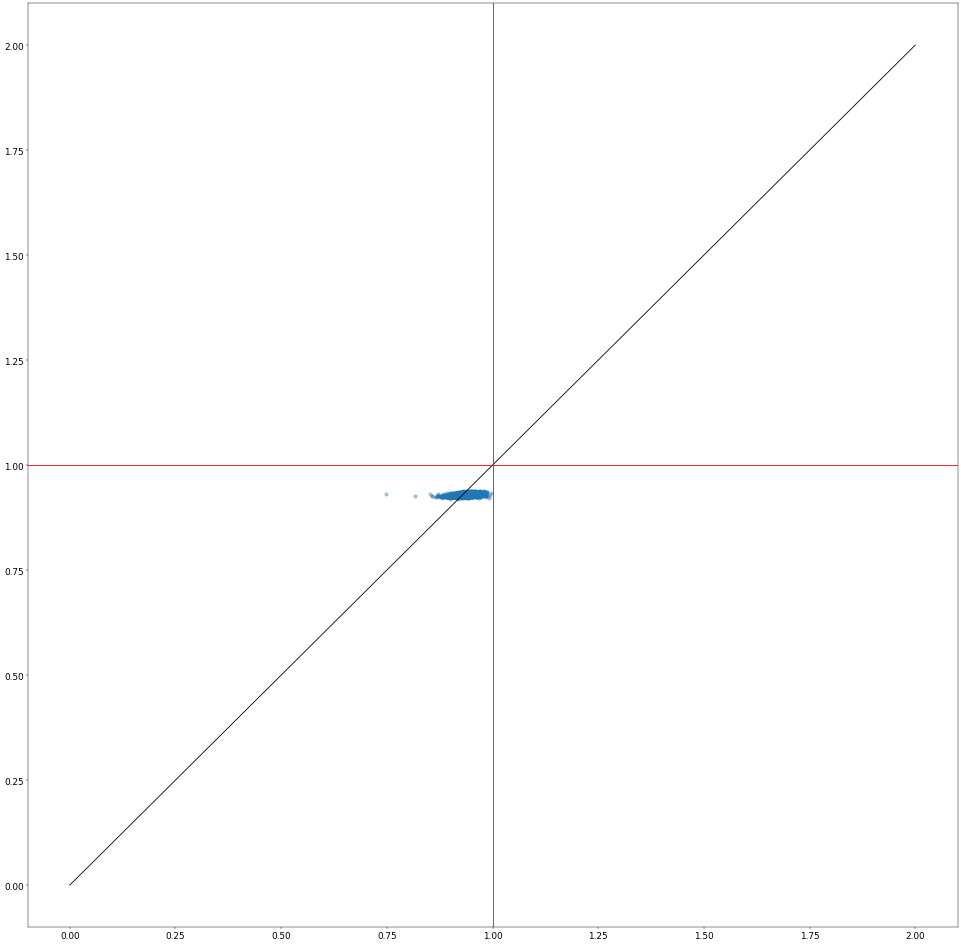

epoch: 41


100%|██████████| 121/121 [00:02<00:00, 42.18it/s]


batches for train: 121
train loss: 1.0135412895975033


100%|██████████| 61/61 [00:01<00:00, 54.51it/s]


batches for test: 61
test loss: 1.014326883144066
pred - true / true mean: -0.0077479733
pred - true / true std: 0.017348204
mu,sig: -0.0077479733 0.017348204


<Figure size 640x480 with 0 Axes>

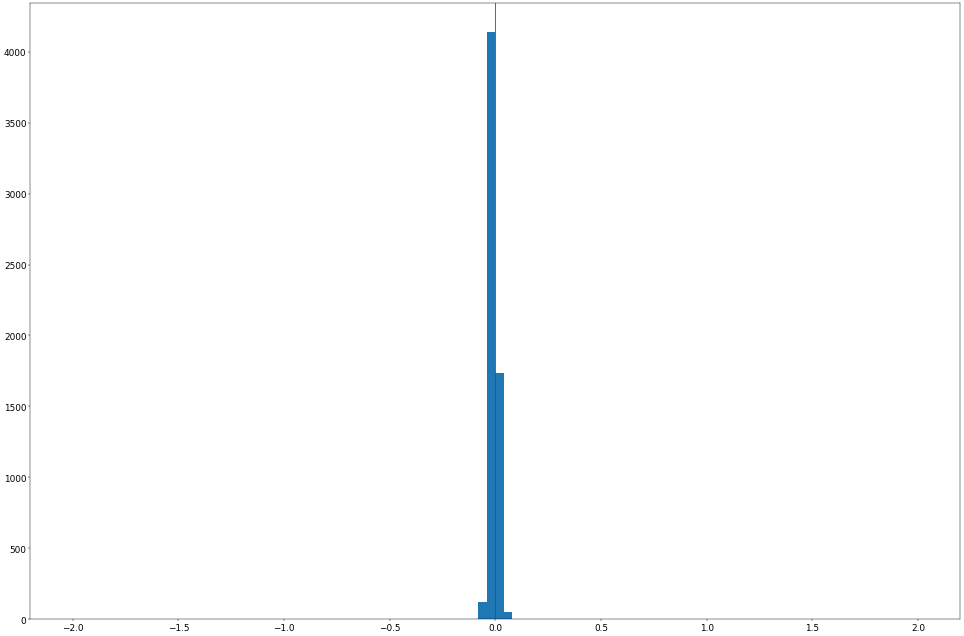

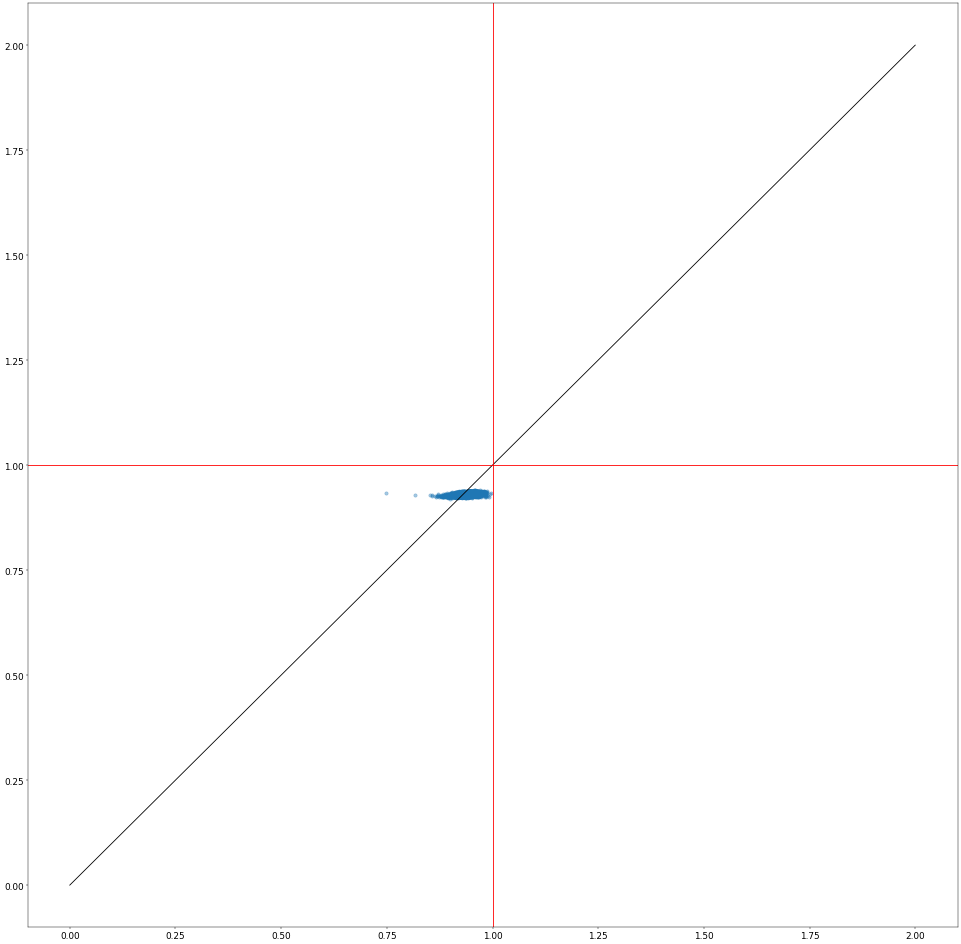

epoch: 42


100%|██████████| 121/121 [00:02<00:00, 42.20it/s]


batches for train: 121
train loss: 1.0134432877390838


100%|██████████| 61/61 [00:01<00:00, 41.46it/s]


batches for test: 61
test loss: 1.0147918130530686
pred - true / true mean: -0.0090846345
pred - true / true std: 0.017210344
mu,sig: -0.0090846345 0.017210344


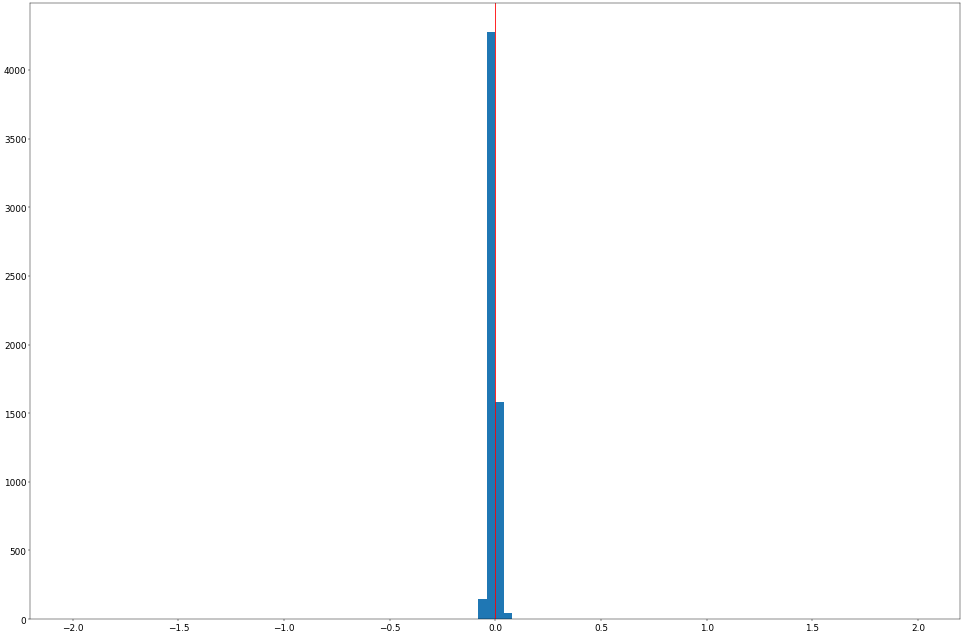

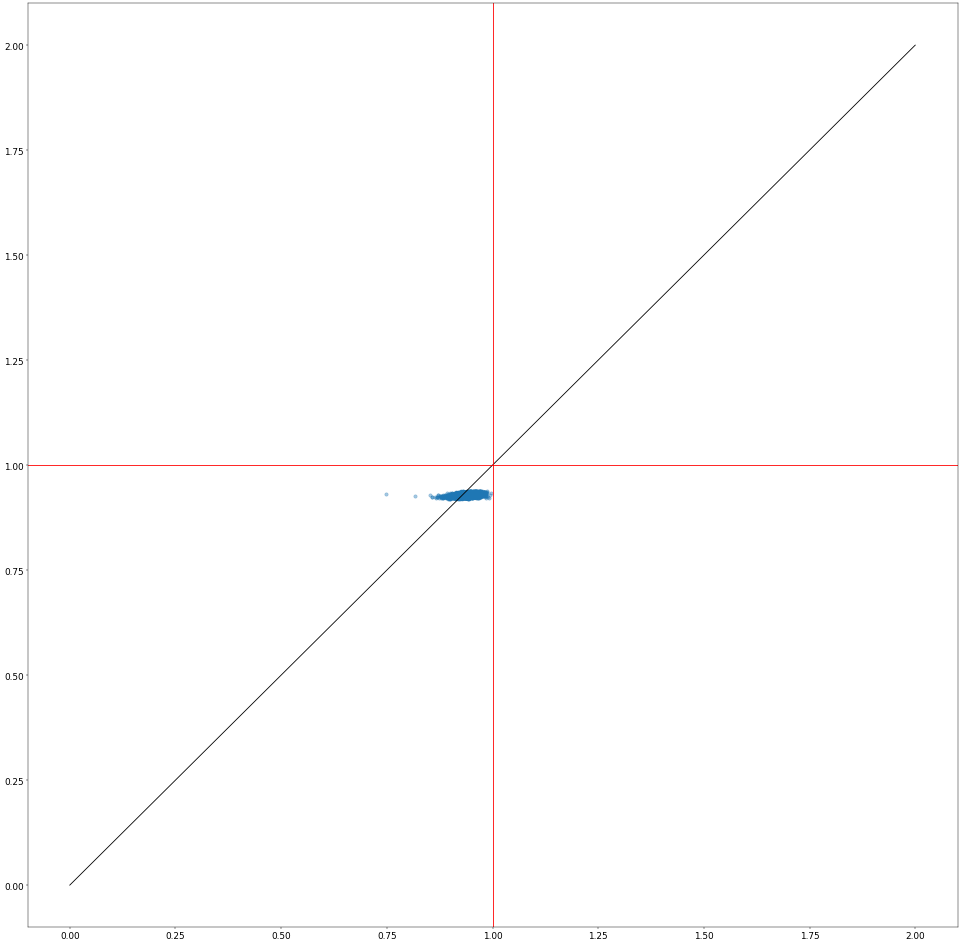

epoch: 43


100%|██████████| 121/121 [00:02<00:00, 44.03it/s]


batches for train: 121
train loss: 1.0132198836192612


100%|██████████| 61/61 [00:01<00:00, 54.09it/s]


batches for test: 61
test loss: 1.0136880679208724
pred - true / true mean: -0.0064409897
pred - true / true std: 0.017167341
mu,sig: -0.0064409897 0.017167341


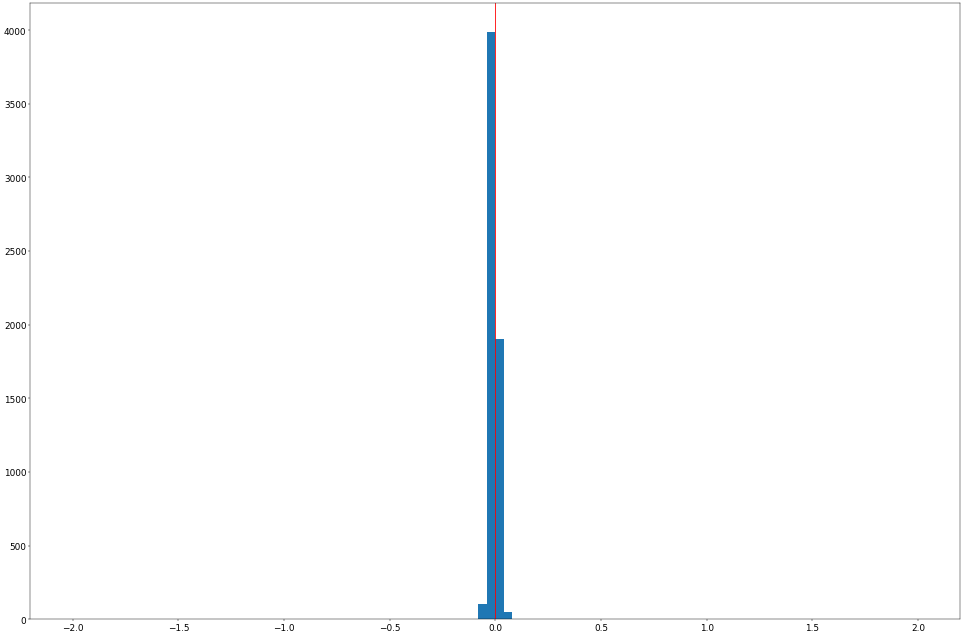

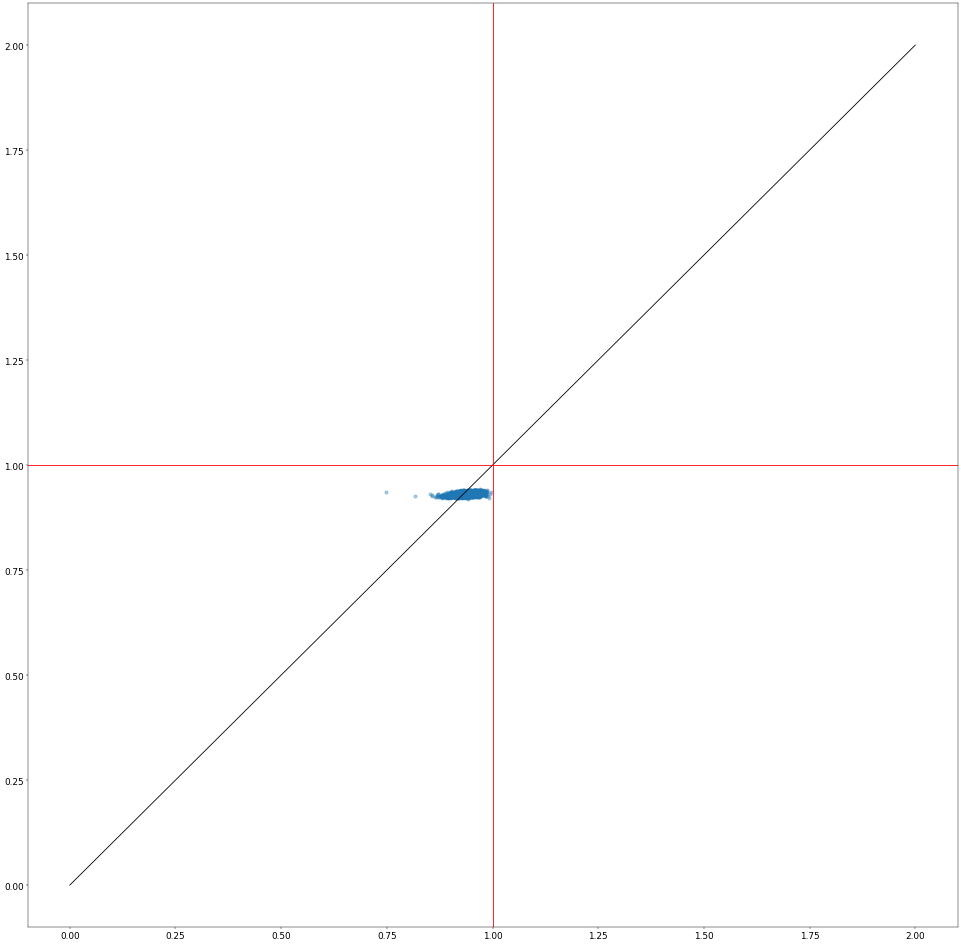

epoch: 44


100%|██████████| 121/121 [00:02<00:00, 44.08it/s]


batches for train: 121
train loss: 1.013236820205184


100%|██████████| 61/61 [00:01<00:00, 55.62it/s]


batches for test: 61
test loss: 1.0147478893154958
pred - true / true mean: -0.009255869
pred - true / true std: 0.017052488
mu,sig: -0.009255869 0.017052488


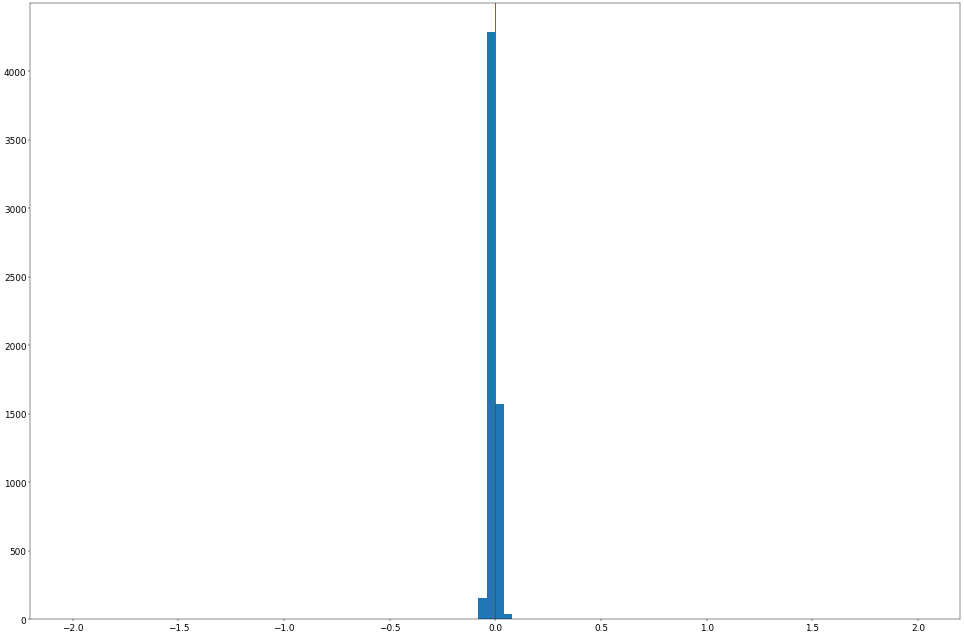

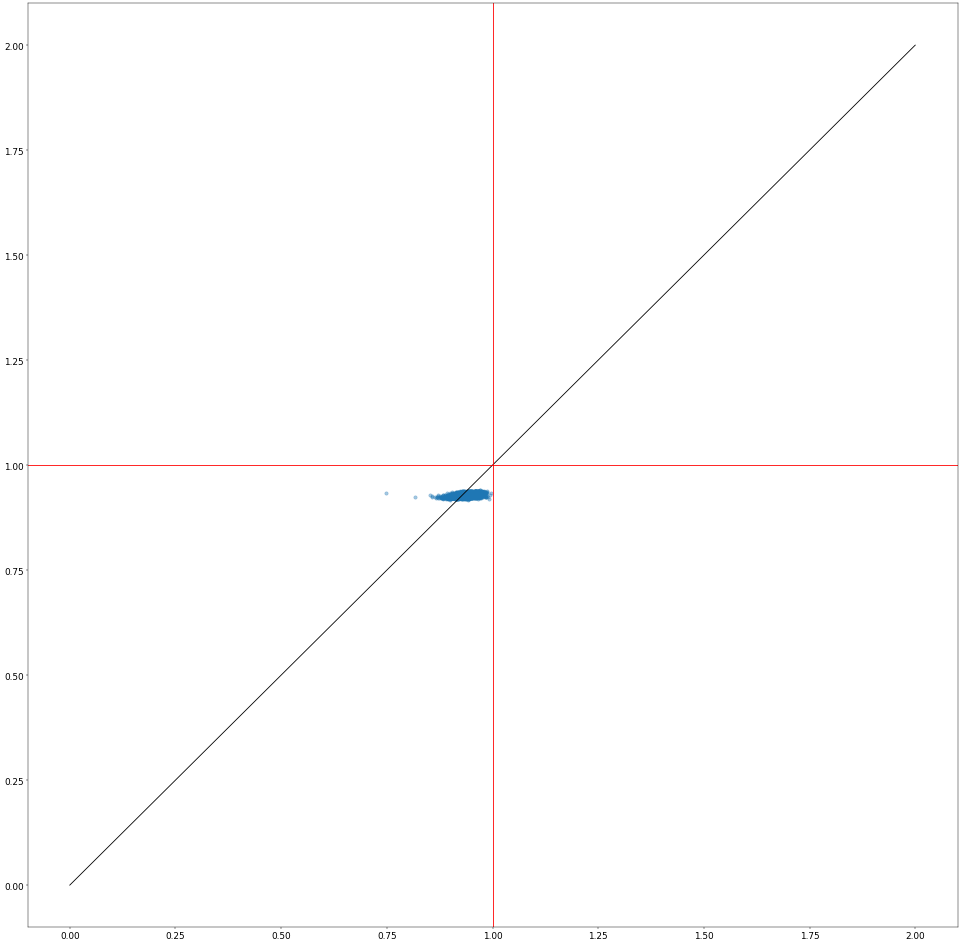

epoch: 45


100%|██████████| 121/121 [00:02<00:00, 43.73it/s]


batches for train: 121
train loss: 1.0131724511296296


100%|██████████| 61/61 [00:01<00:00, 51.35it/s]


batches for test: 61
test loss: 1.0141304242806357
pred - true / true mean: -0.007941972
pred - true / true std: 0.016997732
mu,sig: -0.007941972 0.016997732


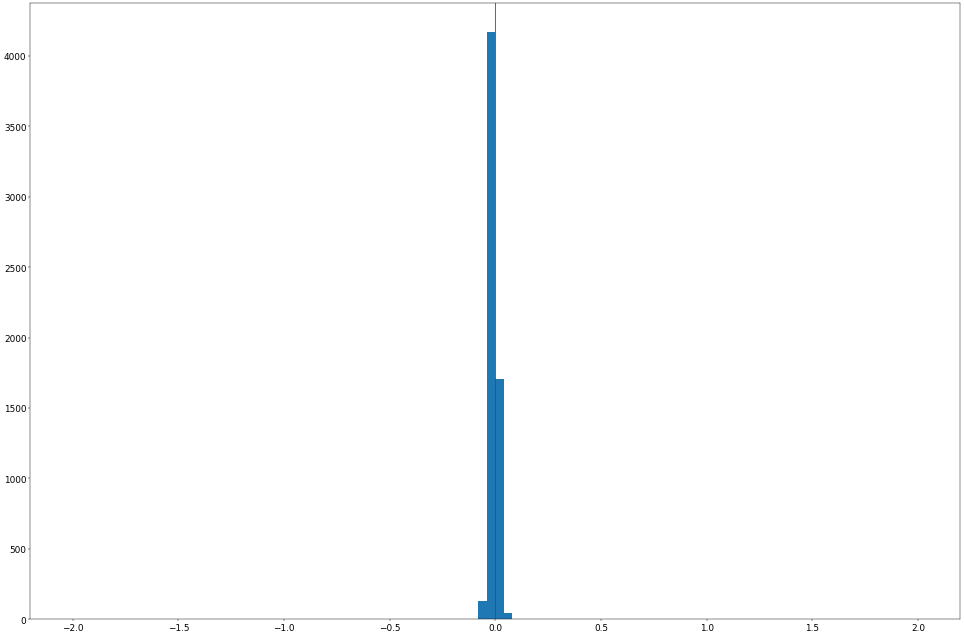

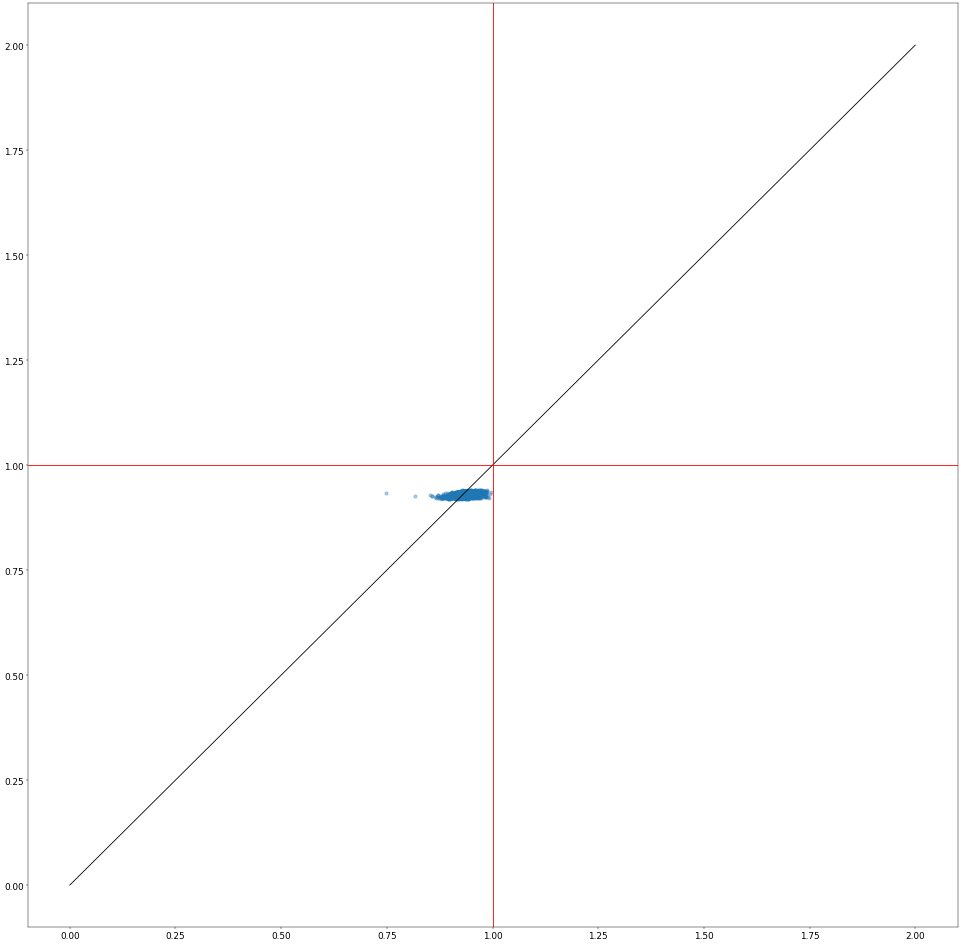

epoch: 46


100%|██████████| 121/121 [00:02<00:00, 44.20it/s]


batches for train: 121
train loss: 1.0131430133315158


100%|██████████| 61/61 [00:01<00:00, 56.09it/s]


batches for test: 61
test loss: 1.0135881490394718
pred - true / true mean: -0.0065574436
pred - true / true std: 0.016984336
mu,sig: -0.0065574436 0.016984336


<Figure size 640x480 with 0 Axes>

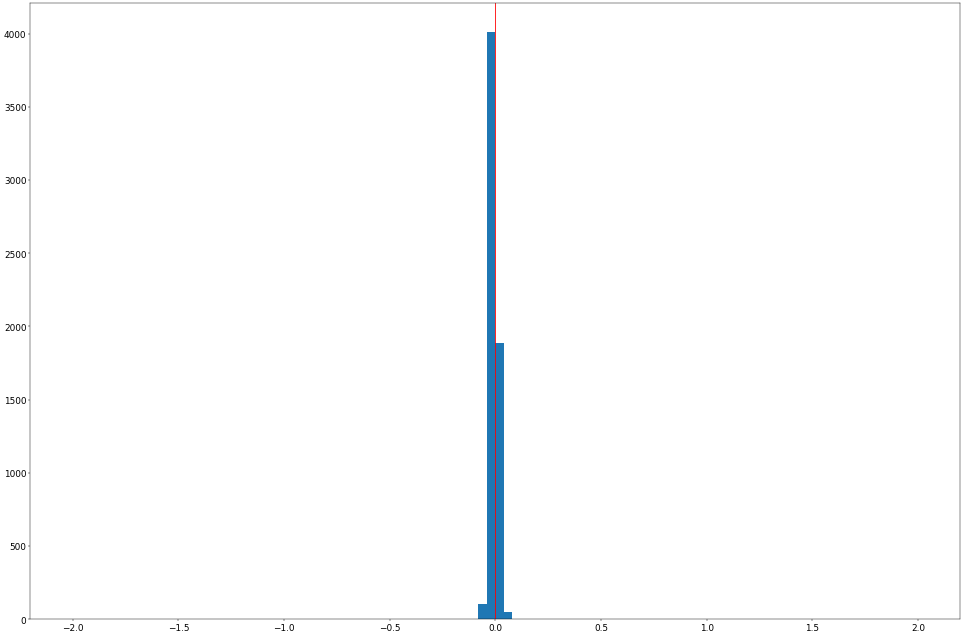

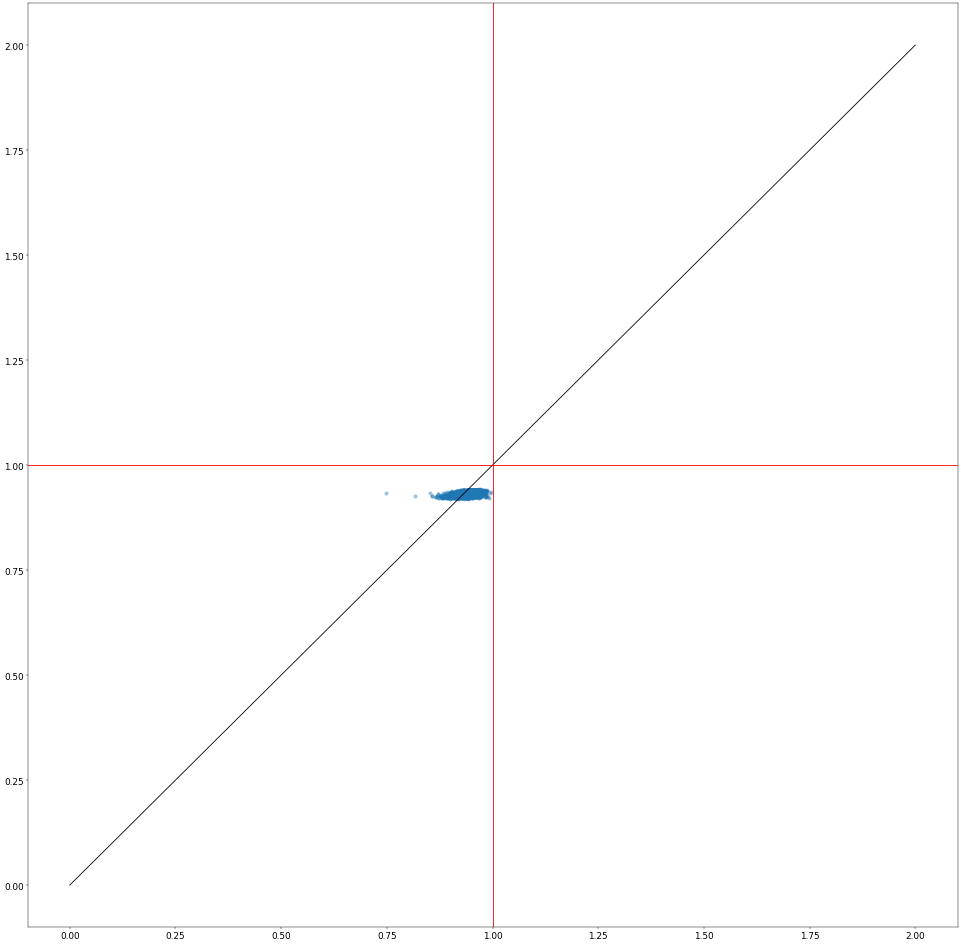

epoch: 47


100%|██████████| 121/121 [00:02<00:00, 43.50it/s]


batches for train: 121
train loss: 1.0130308777832788


100%|██████████| 61/61 [00:01<00:00, 55.86it/s]


batches for test: 61
test loss: 1.0143087613778037
pred - true / true mean: -0.008343348
pred - true / true std: 0.017004197
mu,sig: -0.008343348 0.017004197


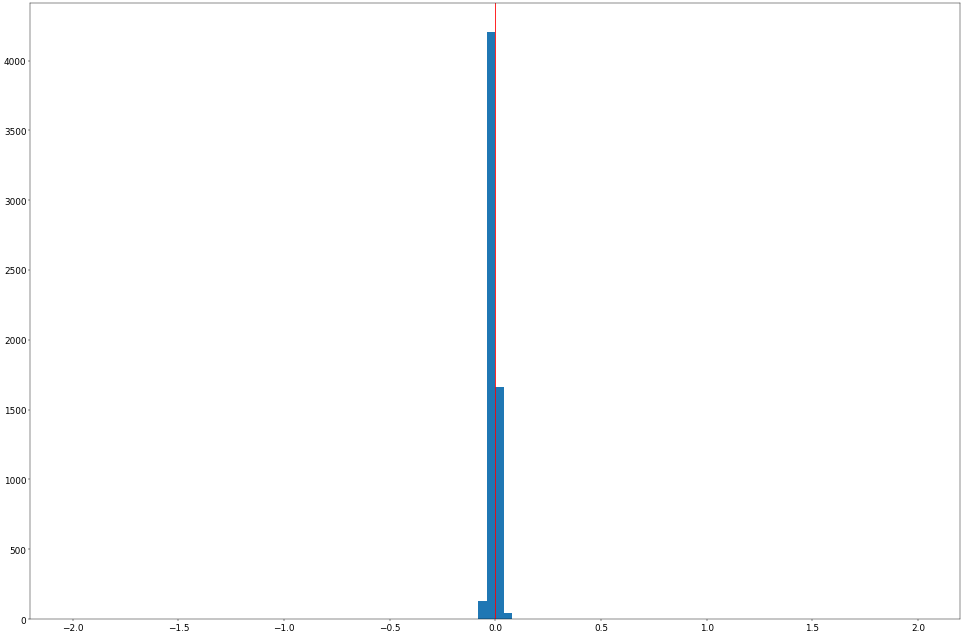

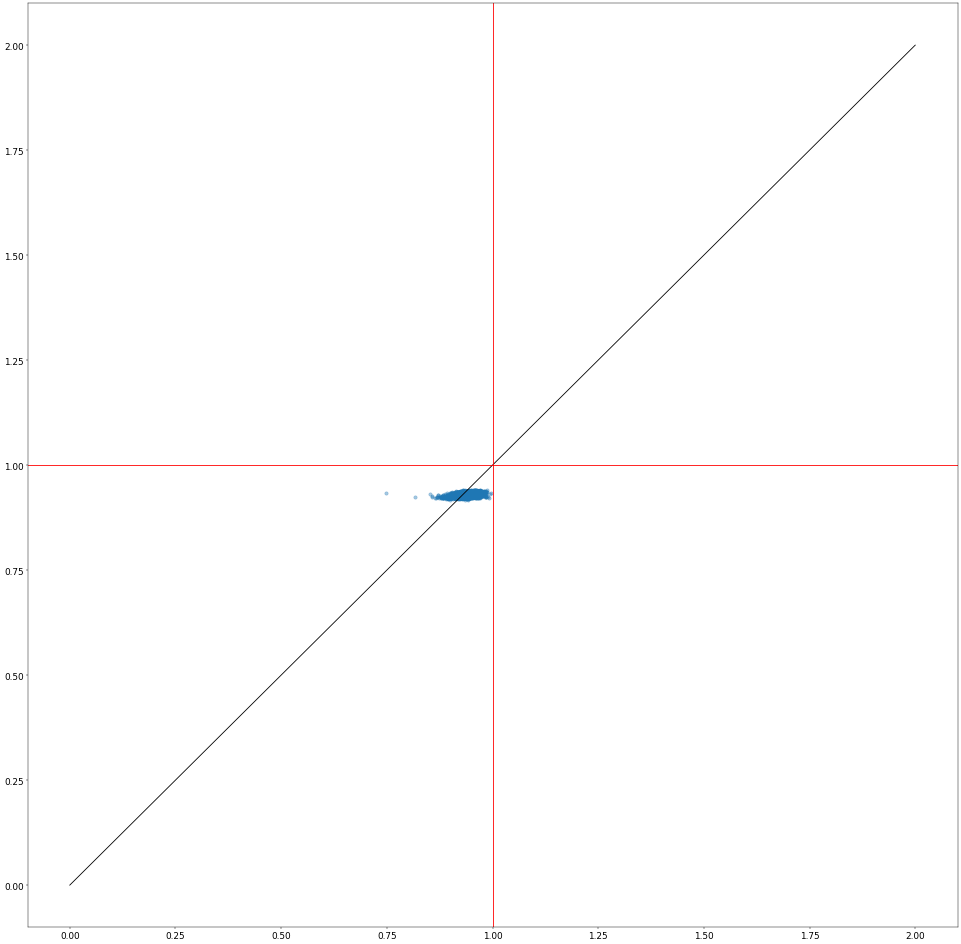

epoch: 48


100%|██████████| 121/121 [00:02<00:00, 44.62it/s]


batches for train: 121
train loss: 1.0129593019643106


100%|██████████| 61/61 [00:01<00:00, 55.95it/s]


batches for test: 61
test loss: 1.0137982798404381
pred - true / true mean: -0.0073100436
pred - true / true std: 0.016900616
mu,sig: -0.0073100436 0.016900616


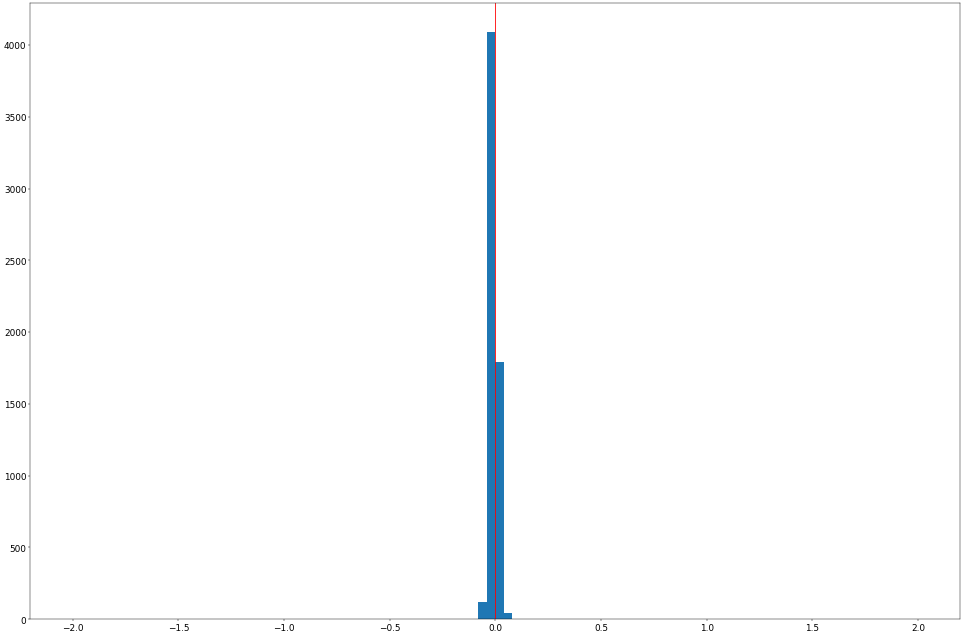

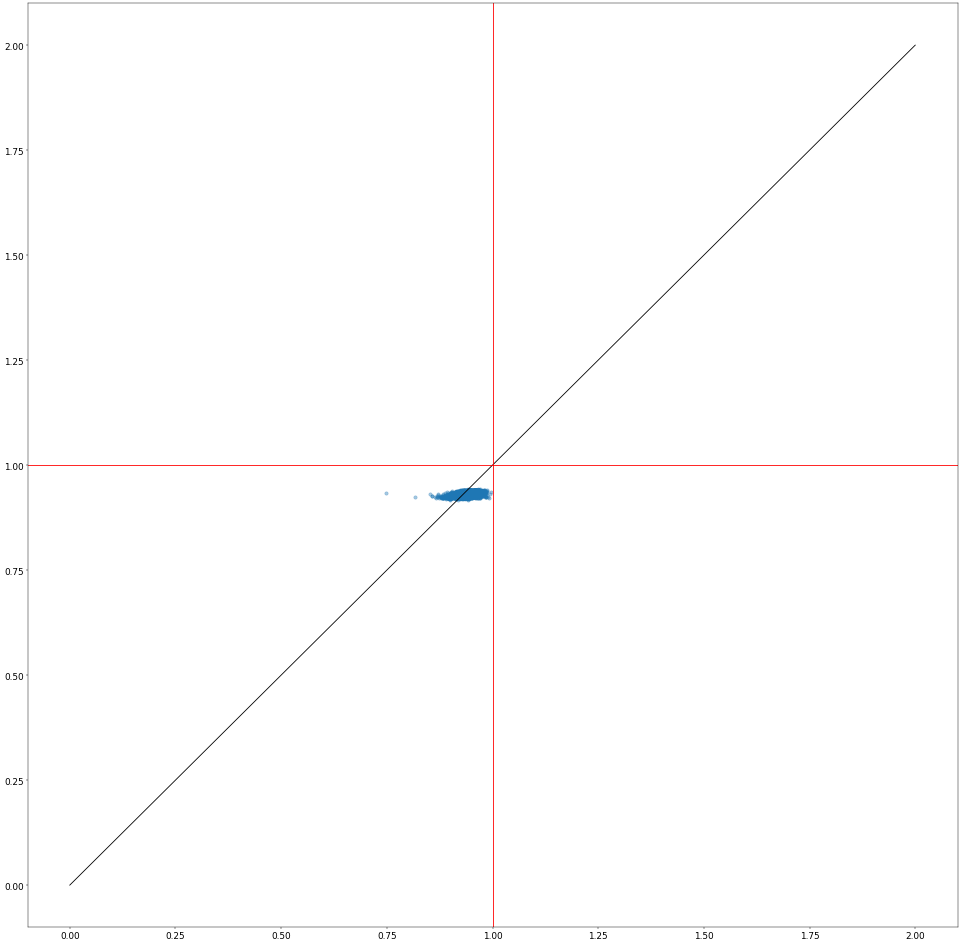

epoch: 49


100%|██████████| 121/121 [00:03<00:00, 37.24it/s]


batches for train: 121
train loss: 1.0129485248534147


100%|██████████| 61/61 [00:01<00:00, 47.15it/s]


batches for test: 61
test loss: 1.0142420862541823
pred - true / true mean: -0.008393319
pred - true / true std: 0.01689613
mu,sig: -0.008393319 0.01689613


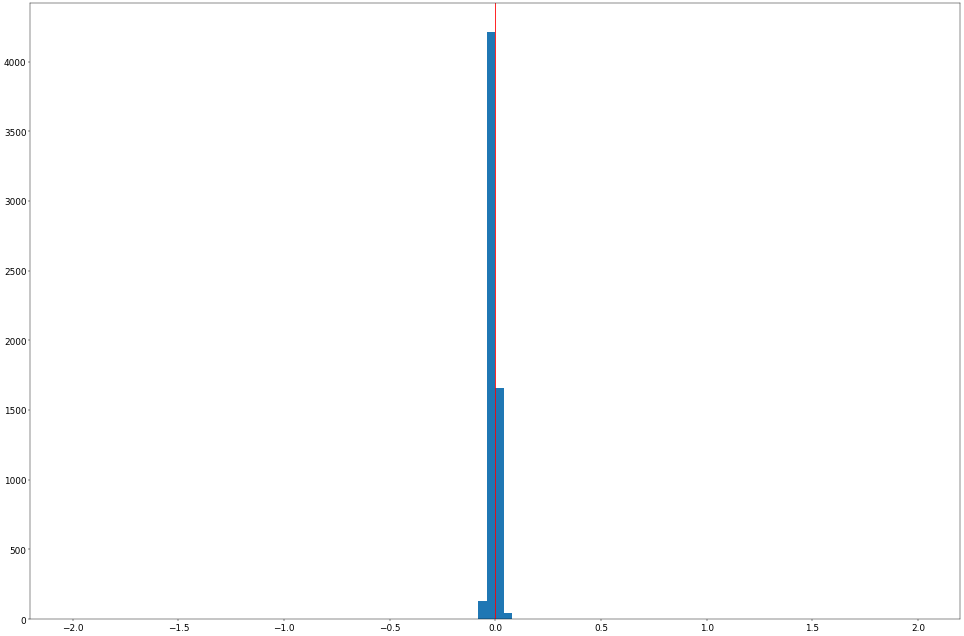

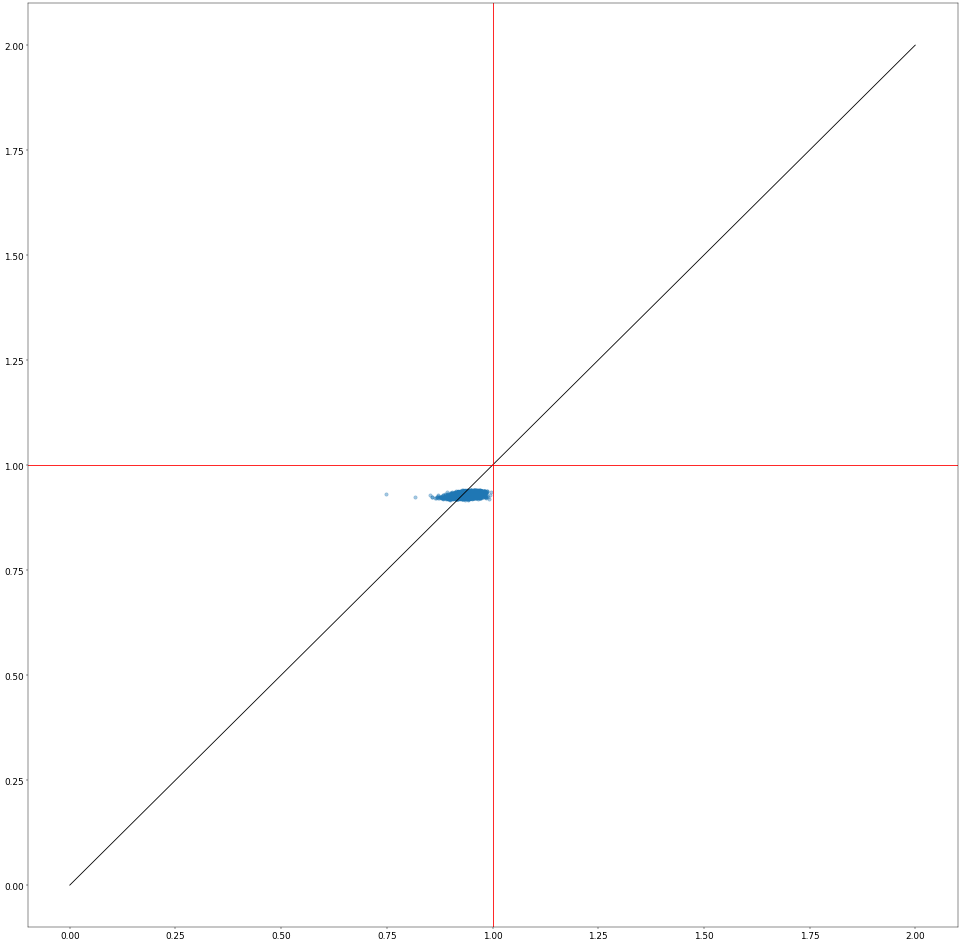

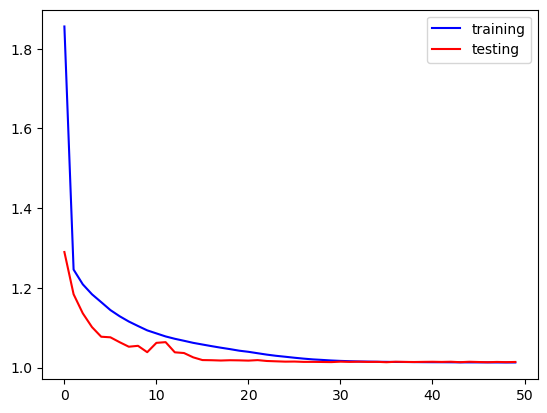

epoch: 50


100%|██████████| 121/121 [00:02<00:00, 43.03it/s]


batches for train: 121
train loss: 1.012813531662807


100%|██████████| 61/61 [00:01<00:00, 55.18it/s]


batches for test: 61
test loss: 1.0134867527445808
pred - true / true mean: -0.0064169113
pred - true / true std: 0.016927324
mu,sig: -0.0064169113 0.016927324


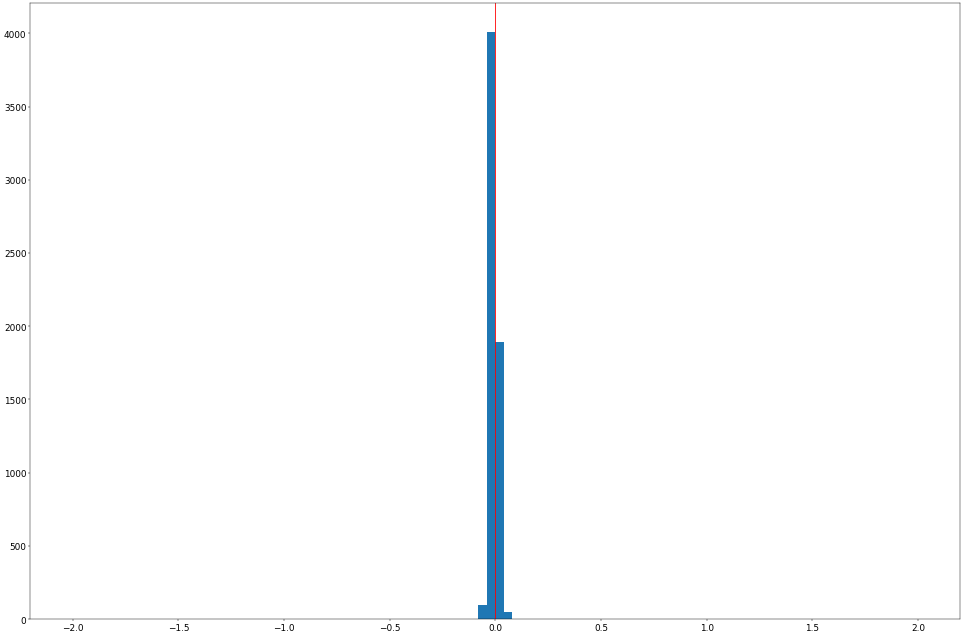

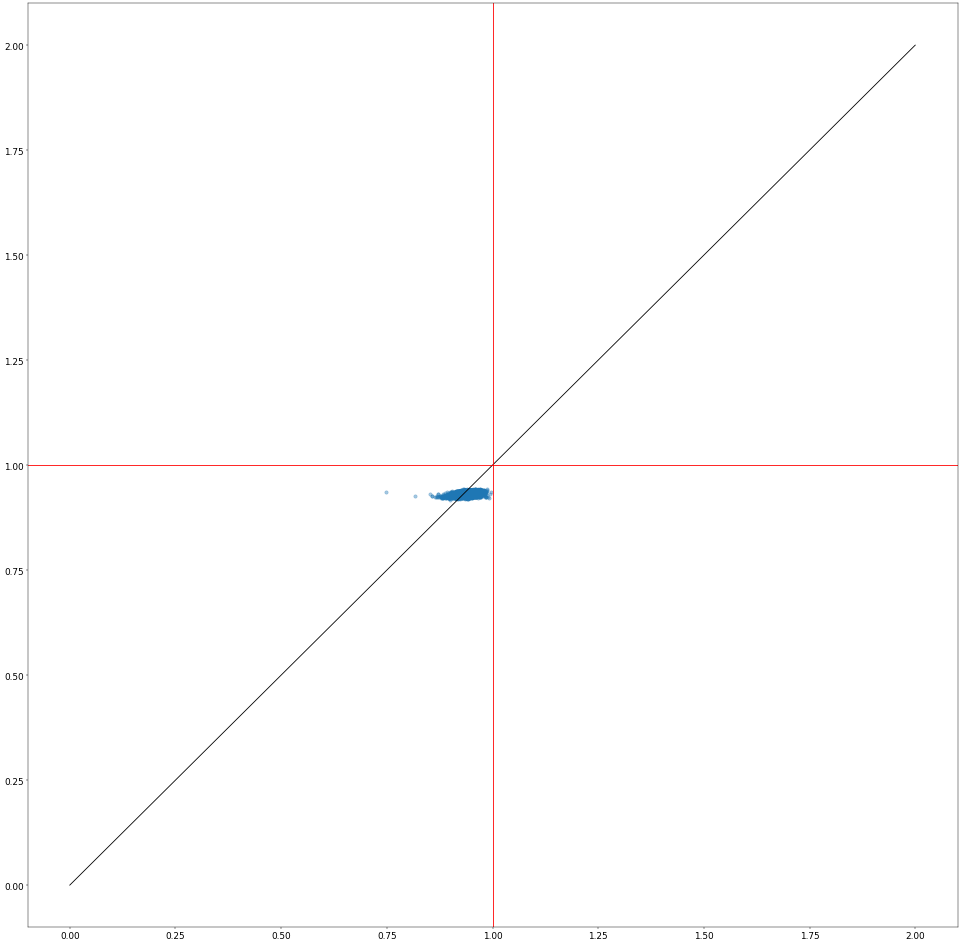

new best test loss: 1.0134867527445808
epoch: 51


100%|██████████| 121/121 [00:02<00:00, 44.11it/s]


batches for train: 121
train loss: 1.0127948384639645


 75%|███████▌  | 46/61 [00:01<00:00, 43.89it/s]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [88]:
#from tqdm import notebook.tqdm as tqdm
#import tqdm.notebook.tqdm as tqdm
#checkpoint_dir = '/home/sameasy2006/hgcal_ldrd-gravnet2_wip_trainer_args/ouput_regression_testtesttesttest_dyn2addlayer/'
#checkpoint_dir = '/home/sameasy2006/hgcal_ldrd-gravnet2_wip_trainer_args/ouput_regression_add1ip1dyn_binresoloss/'
#"/home/llr/cms/sghosh/GNNECAL/model_nopho_deepernet/"
checkpoint_dir = "/home/llr/cms/sghosh/TESTBEAM/Regression/models/testmodel2/"
plot_dir = "/home/llr/cms/sghosh/TESTBEAM/Regression/models/testmodel2/"
nepoch=500
os.makedirs(checkpoint_dir, exist_ok=True)
best_loss = 99999999
losst = []
lossv = []
epochs = []
for epoch in range(nepoch):
    print ('epoch:',epoch)
    losst.append(train(epoch))
    loss_epoch = evaluate(epoch)
    lossv.append(loss_epoch)
    epochs.append(epoch)
    checkpoint = {
    'epoch': epoch + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
    }
    
    checkpoint_file = 'model_epoch_%i.pth.tar' % ( epoch )
    torch.save(checkpoint,
                   os.path.join(checkpoint_dir,checkpoint_file ))
    if loss_epoch < best_loss:
        best_loss = loss_epoch
        print('new best test loss:',best_loss)
        torch.save(checkpoint,
                   os.path.join(checkpoint_dir,'model_checkpoint_best.pth.tar' ))
    if ((epoch+1)%10 == 0):
        plt.plot(np.array(epochs),np.array(losst),c='b',label='training')
        plt.plot(np.array(epochs),np.array(lossv),c='r',label='testing')
        plt.legend()
        if ((epoch+1) == nepoch):
            plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        plt.show()

 

In [ ]:
'''device = torch.device('cpu')#('cuda' if torch.cuda.is_available() else 'cpu')
#checkpoint_dir = '/export/home/phys/aharilal/MassRegressor/a2gg-regression/MODELS/GNN_scale50/'
ep_test=299
model_fname = checkpoint_dir + '/model_epoch_%d.pth.tar'%ep_test
model= Net().to(device)
model.load_state_dict(torch.load(model_fname)['state_dict'])
model.eval()'''
'''#model_fname = '/home/sameasy2006/hgcal_ldrd-gravnet2_wip_trainer_args/ouput_regression_phopi_comb_categ/model_cont3_checkpoint_best.pth.tar'
#model_fname = '/home/llr/cms/sghosh/HGCAL_TICL_STUFF/RECOTESTS_ORGANISED/MODTICLLXPLUS/CMSSW_11_2_0_pre10/src/RecoNtuples/HGCalAnalysis/test/GENGRAPHS/ouput_classification_PU_LC3213/model_checkpoint_best.pth.tar'
#checkpoint_dir = '/home/llr/cms/sghosh/HGCAL_TICL_STUFF/RECOTESTS_ORGANISED/MODTICLLXPLUS/CMSSW_11_2_0_pre10/src/RecoNtuples/HGCalAnalysis/test/GENGRAPHS/ouput_PU_morestats_ptweight/'

#model_fname = checkpoint_dir + 'model_checkpoint_best.pth.tar'
model_fname = checkpoint_dir + 'model_epoch_299.pth.tar'
mdl=Net().to(device)
mdl.load_state_dict(torch.load(model_fname)['state_dict'])
mdl.eval()
print(sum(p.numel() for p in model.parameters()))
loss_epoch = evaluate(epoch)'''

In [93]:
model_fname = checkpoint_dir + '/model_checkpoint_best.pth.tar'
device='cpu'
model= Net().to(device)
model.load_state_dict(torch.load(model_fname)['state_dict'])
model.eval()
valloader = torch_geometric.data.DataLoader(data_list[ntrain:], batch_size=1)
true=[]
pred=[]
calc=[]
for data in tqdm(valloader):
    data = data.to(device)        
    result = model(data)
    true.append(data.truen.detach().cpu().squeeze())
    val = 1./result*torch.sum(data.cl2d[:,3]).detach().cpu()
    pred.append(val.detach().cpu().squeeze())
    calc.append(torch.sum(data.cl2d[:,3]).detach().cpu())
    
    #print(data.truen.detach().cpu().squeeze(),val.detach().cpu().squeeze(),torch.sum(data.cl2d[:,3]).detach().cpu())
    #break

100%|██████████| 6048/6048 [00:48<00:00, 123.59it/s]


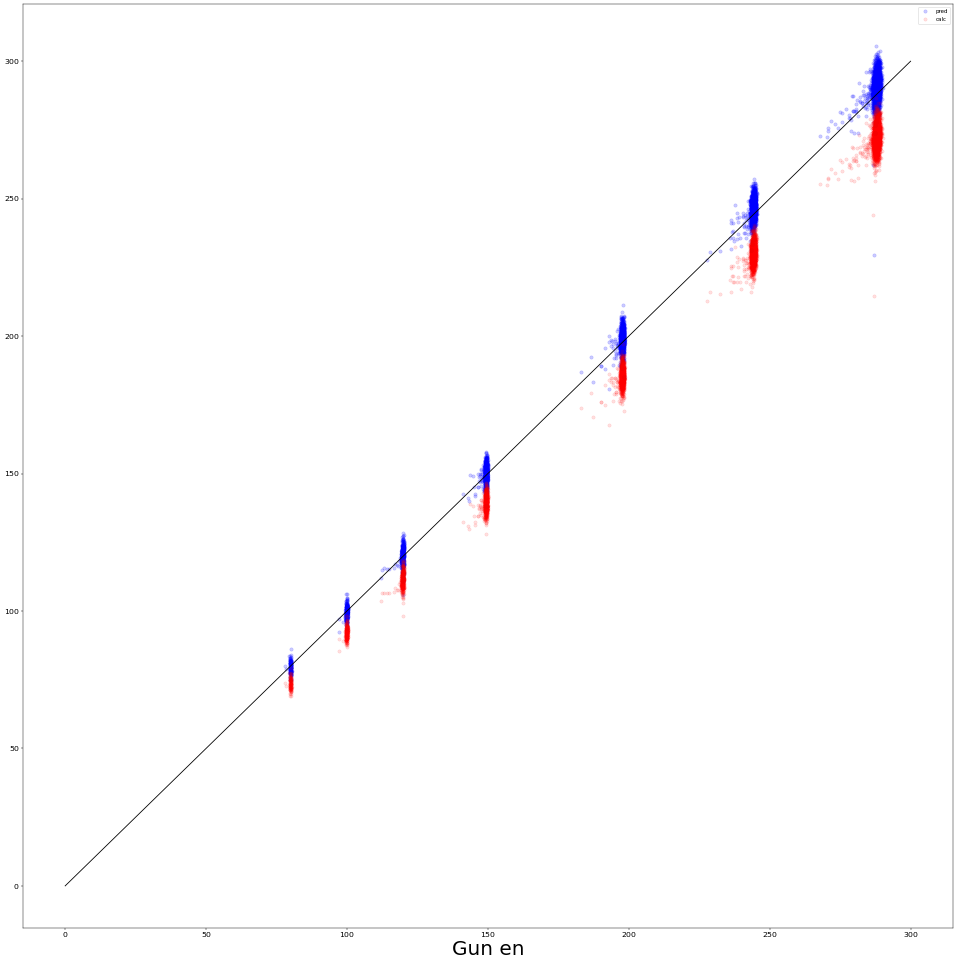

In [94]:
from matplotlib.pyplot import figure

figure(figsize=(30, 30), dpi=40)

plt.scatter(np.array(true),np.array(pred),c='b',label="pred",alpha=0.2)
plt.scatter(np.array(true),np.array(calc),c='r',label="calc",alpha=0.12)
plt.plot([0,300], [0,300], 'k-')
plt.xlabel("Gun en")
plt.legend()
plt.tick_params(labelsize=14)
plt.show()

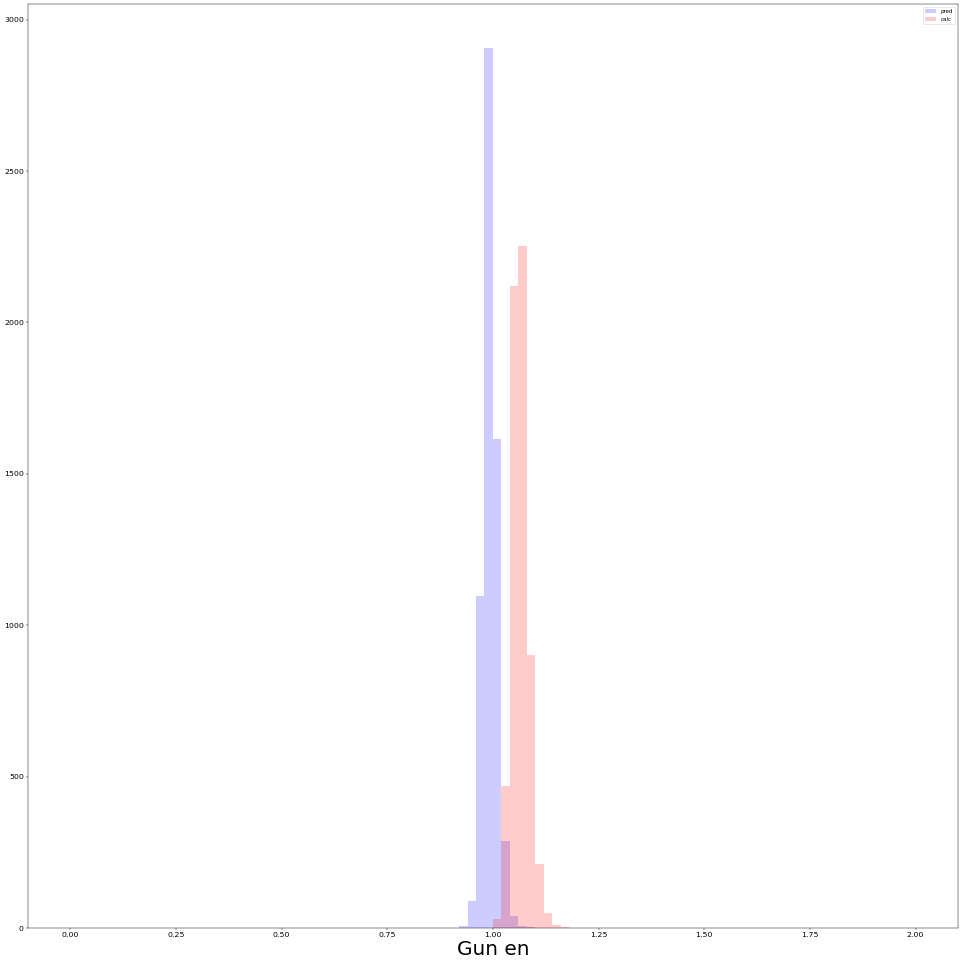

In [95]:
from matplotlib.pyplot import figure

figure(figsize=(30, 30), dpi=40)

plt.hist(np.array(true)/np.array(pred),color='b',label="pred",alpha=0.2,range=[0,2],bins=100)
plt.hist(np.array(true)/np.array(calc),color='r',label="calc",alpha=0.2,range=[0,2],bins=100)
#plt.plot([0,300], [0,300], 'k-')
plt.xlabel("Gun en")
plt.legend()
plt.tick_params(labelsize=14)
plt.show()